# Functions given by TMK 

In [8]:
import pandas as pd
import numpy as np
from math import ceil

def create_single_triangle(data, claims_target, fully_developed_period, current_year):
    ''' 
    Creates a single triangle from raw data. Raw data needs to be for 1 triangle.
    
    Parameters
    ----------
    data - pandas dataframe of claims data for 1 triangle only
    claims_target - column name of claims target. E.g. "Non-cat Incurred"
    fully_developed_periods - number of periods after which claims are considered fully developed
    current_year - current year of account. e.g. 2021

    '''


    df = data.copy()

    # Multiply value by -1
    df[claims_target] = df[claims_target]/-1000

    # Calculate dev period
    df["QUARTER"] = df["REPORTING_PERIOD"].apply(lambda x: x.split("Q")[1])
    df["QUARTER"] = df["QUARTER"].astype(int)

    df["REPORTING_YEAR"] = df["REPORTING_PERIOD"].apply(lambda x: x.split("Q")[0])
    df["REPORTING_YEAR"] = df["REPORTING_YEAR"].astype(int)

    df["DEV_PERIOD"] = (df["REPORTING_YEAR"] - df["YOA"]) * 4 + df["QUARTER"]

    # Pivot to triangle
    df = df.pivot(index='YOA', columns='DEV_PERIOD', values=claims_target)
    
    # Remove columns less than 1
    for col in df.columns.tolist():
        if col < 1:
            df = df.drop(col, axis=1)
            
    # Fill with 0
    df = df.fillna(0)
    
    #----------------------------------------------------------------------------------
    # Error handling: check if there are missing columns or indexes and fill it with 0s
    #----------------------------------------------------------------------------------
    # Set up an error log dict to collect all errors
    triangle_log = {
        "no_errors":0,
        "error_messages" : [],
        "first_year":0
    }
            
    # Look at shape (yoa x periods)
    yoa_list = df.index.tolist()
    period_list = df.columns.tolist()
    #print(yoa_list)
    # Calculate the first yoa
    if len(yoa_list) != 0:
        yoa_first = min(yoa_list)
    else:
        yoa_first = 0
    triangle_log["first_year"] = yoa_first

    # Get the expected columns
    expected_periods = list(range(1, fully_developed_period+1)) # e.g. 1,2,3,4,5,6 if 6 is fully devp
    expected_yoa = list(range(yoa_first, current_year+1)) # 2005,2006...2020 if first year is 2005

    # See if any years are missing
    yoa_missing = []
    for yoa in expected_yoa:
        if yoa not in yoa_list:
            yoa_missing.append(yoa)

    # See if any devperiods are missing
    period_missing = []
    for period in expected_periods:
        if period not in period_list:
            period_missing.append(period)

    # Add missing devperiods with 0 value
    for period in period_missing:
        df[period] = 0.0
    df = df[expected_periods]

    # Add missing rows
    df = pd.concat([df, pd.DataFrame(0, index=yoa_missing, columns=expected_periods)])
    df = df.sort_index()
    
    # Log if any errors have occured
    for period in period_missing:
        triangle_log["no_errors"] = triangle_log["no_errors"] + 1
        triangle_log["error_messages"].append(f"Period {period} was missing from data.")
        
    for yoa in yoa_missing:
        triangle_log["no_errors"] = triangle_log["no_errors"] + 1
        triangle_log["error_messages"].append(f"YOA {yoa} was missing from data.")
        
    return df, triangle_log

def get_periods_to_predict(reporting_year, reporting_number, fully_developed_period):
    '''
    Given a reporting period and the fully developed periods, returns what periods need to be predicted.

    Parameters
    -----------
    period: "2015Q3"
    fully_developed_period: 17

    '''
    period = reporting_year+'Q'+reporting_number
    # Get the period year and quarter
    period_year = int(period.split("Q")[0])
    period_quarter = int(period.split("Q")[1])

    # Get which years we are trying to predict
    number_of_years_to_predict = ceil((fully_developed_period - period_quarter)/4)
    years_to_predict = []

    for i in range(number_of_years_to_predict):
        years_to_predict.append(period_year - i)

    # Get which periods in those UW years do we predict
    periods_to_predict = {}
    for year in years_to_predict:
        periods_to_predict.update({year:list(range(period_quarter+1+4*(period_year - year), fully_developed_period+1))})

    return periods_to_predict

def mask_triangle(triangle, reporting_year, reporting_number):
    '''
    Replaces the values in the triangle that need to be predicted according to the given reporting period with NaN.

    Parameters
    -----------
    triange: triangle pandas dataframe generated with the create_single_triangle function
    period: reporting PERIOD when the triangle was generated. e.g. "2015Q2"
    '''
    # Get max period of the triangle
    max_period = max(triangle.columns.tolist())
    
    # Get the periods we need to replace
    period = reporting_year+'Q'+reporting_number
    periods_to_predict = get_periods_to_predict(reporting_year, reporting_number, max_period)
    
    # Drop any UW year that is after the period
    period_year = int(period.split("Q")[0])
    years_to_drop = [x for x in triangle.index.tolist() if x >period_year]
    triangle = triangle.drop(years_to_drop, axis=0)
    
    # Replace all values
    for ind in periods_to_predict.keys():
        for col in periods_to_predict[ind]:
            triangle[col][ind] = np.NaN
            
    return triangle

def get_chain_ladder_prediction_ultimate(df, reporting_year, reporting_number, uw_years, fully_developed_period):
    '''
    Generates a prediction of ultimate claims given a cumulative claims triangle.

    Parameters
    ------------
    df: has to be  a cummulative claims triangle
    uw_years - how many UW years to go back in time for calculating the development factors. e.g.: 5
    fully_developed_period - after how many development periods are the claims fully developed e.g.: 17
    '''

    # Roll back triangle to period
    df = mask_triangle(df, reporting_year, reporting_number)
    rep_period = reporting_year+'Q'+reporting_number
    
    # Limit to number of uw years that we consider
    df = df.tail(uw_years)

    # Limit data to fully developed
    df = df[list(range(1, fully_developed_period+1))]
            
    # Get the development factors 
    dev_factors = []
    
    for period in range(2, fully_developed_period+1):

        # Get the two columns out
        first_col = df[period-1].values.tolist()
        second_col = df[period].values.tolist()

        # Calculate how many needs to be deducted because not available
        deduction = 0
        for value in second_col[::-1]:
            if np.isnan(value):
                deduction+=1
            else:
                break

        # Apply deductions - if not 0
        if deduction != 0:
            first_col = first_col[:-deduction]
            second_col = second_col[:-deduction]
        if np.nansum(first_col) <= 0.1:
            dev_factors.append(1)  
        elif np.nansum(first_col) != 0:
            dev_factors.append(np.nansum(second_col) / np.nansum(first_col))   
            
#     print(dev_factors)
    # Get periods to predict
    periods_to_predict = get_periods_to_predict(reporting_year, reporting_number, fully_developed_period)
    
    # Go through each year, take the last value and multiply with the development factor sequence to ultimate
    pred_result = {}
    for uw_year in periods_to_predict.keys():
        
        # Determine the last known value and the number of values in row to fill
        row = df.loc[uw_year].values.tolist()
        for i, x in enumerate(row[::-1]):
            if ~np.isnan(x):
                rows_to_fill = i
                last_value = x
                break

        # Go through each dev period and perform projection
        for dev_fact in dev_factors[-rows_to_fill:]:
            last_value = last_value*dev_fact
        # Update results
        pred_result.update({uw_year:last_value})
            
    return pred_result

# Calculate MAE for CLM when CCY = 1

In [9]:
import pandas as pd
from sklearn.metrics import mean_absolute_error

# Generate data sets for four different scenarios

# Read data
raw_df = pd.read_csv("claims_data_20210422.csv")

result_CL_Full = []
for i in range(2010,2018):
    for j in range(1,5):
        for k in range(1,11):
            df = raw_df[(raw_df["DURG_CLASS"] == "DURG_"+str(k)) & (raw_df["CURRENCY_CODE"] == "CCY_1")]
            triangle, error_log = create_single_triangle(data = df,
                                                     claims_target = "Non-Cat Incurred",
                                                     fully_developed_period = 17,
                                                     current_year = 2021)
            assert error_log["no_errors"] == 0, "WARNING! Errors in triangle."
            
            res = get_chain_ladder_prediction_ultimate(df = triangle,
                                                   reporting_year= str(i),
                                                   reporting_number= str(j),
                                                   uw_years=9,
                                                   fully_developed_period=17)
            CL_MAE =  mean_absolute_error(triangle[17].loc[:i].iloc[-4:], list(res.values())[::-1])
            result_CL_Full.append(CL_MAE)
            
result_CL_Full_with_premium = []
for i in range(2014,2018):
    for j in range(1,5):
        for k in range(1,11):
            df = raw_df[(raw_df["DURG_CLASS"] == "DURG_"+str(k)) & (raw_df["CURRENCY_CODE"] == "CCY_1")]
            triangle, error_log = create_single_triangle(data = df,
                                                     claims_target = "Non-Cat Incurred",
                                                     fully_developed_period = 17,
                                                     current_year = 2021)
            assert error_log["no_errors"] == 0, "WARNING! Errors in triangle."
            
            res = get_chain_ladder_prediction_ultimate(df = triangle,
                                                   reporting_year= str(i),
                                                   reporting_number= str(j),
                                                   uw_years=9,
                                                   fully_developed_period=17)
            CL_MAE =  mean_absolute_error(triangle[17].loc[:i].iloc[-4:], list(res.values())[::-1])
            result_CL_Full_with_premium.append(CL_MAE)
            
result_CL_after_8_period = []
for i in range(2010,2018):
    for j in range(1,5):
        for k in range(1,11):
            df = raw_df[(raw_df["DURG_CLASS"] == "DURG_"+str(k)) & (raw_df["CURRENCY_CODE"] == "CCY_1")]
            triangle, error_log = create_single_triangle(data = df,
                                                     claims_target = "Non-Cat Incurred",
                                                     fully_developed_period = 17,
                                                     current_year = 2021)
            assert error_log["no_errors"] == 0, "WARNING! Errors in triangle."
            
            res = get_chain_ladder_prediction_ultimate(df = triangle,
                                                   reporting_year= str(i),
                                                   reporting_number= str(j),
                                                   uw_years=9,
                                                   fully_developed_period=17)
    
            CL_MAE =  mean_absolute_error(triangle[17].loc[:i][-4:][:2], list(res.values())[::-1][:2])
            result_CL_after_8_period.append(CL_MAE)
            
            
result_CL_after_8_period_with_premium = []
for i in range(2014,2018):
    for j in range(1,5):
        for k in range(1,11):
            df = raw_df[(raw_df["DURG_CLASS"] == "DURG_"+str(k)) & (raw_df["CURRENCY_CODE"] == "CCY_1")]
            triangle, error_log = create_single_triangle(data = df,
                                                     claims_target = "Non-Cat Incurred",
                                                     fully_developed_period = 17,
                                                     current_year = 2021)
            assert error_log["no_errors"] == 0, "WARNING! Errors in triangle."
            
            res = get_chain_ladder_prediction_ultimate(df = triangle,
                                                   reporting_year= str(i),
                                                   reporting_number= str(j),
                                                   uw_years=9,
                                                   fully_developed_period=17)
    
            CL_MAE =  mean_absolute_error(triangle[17].loc[:i][-4:][:2], list(res.values())[::-1][:2])
            result_CL_after_8_period_with_premium.append(CL_MAE)

# Building RF model for CCY = 1 without premium

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer



class RF_Model_CCY_1:
    def __init__(self, reporting_year, reporting_number):
        self.reporting_number = reporting_number
        self.reporting_year = reporting_year
        self.raw_data = pd.read_csv("claims_data_20210422.csv")
        self.non_cat_incurred = pd.DataFrame()
        self.triangle = {}
        self.claim_prediction =  {}
        self.setup_initial_non_cat_incurred()
        self.best_param = {}
        if int(self.reporting_number) > 4:
            raise ValueError('reporting period cannot exceed 4.')
            
            
    def setup_initial_non_cat_incurred(self):
        if self.non_cat_incurred.empty:
            for DURG_number in range(1, 11):
                tr_backtest_single_DURG_class = self.creat_initial_br_backtest_for_DURG_class(DURG_number)
                df_current = self.rolling_window_across_year(tr_backtest_single_DURG_class, DURG_number)
                self.non_cat_incurred = self.non_cat_incurred.append(df_current[df_current['target']!=0])
        

    ### Full dataset
    def creat_initial_br_backtest_for_DURG_class(self, DURG_number):
        df = self.raw_data[(self.raw_data["DURG_CLASS"] == "DURG_"+str(DURG_number)) & (self.raw_data["CURRENCY_CODE"] == "CCY_1")]
        triangle, _ = create_single_triangle(data = df,
                                                    claims_target = "Non-Cat Incurred",
                                                    fully_developed_period = 17,
                                                    current_year = 2021)
        self.triangle['DURG_'+str(DURG_number)] = triangle
        tr_backtest_single_DURG_class = mask_triangle(triangle, self.reporting_year, self.reporting_number)
        return tr_backtest_single_DURG_class
    
    
    def rolling_window_across_year(self, tr_backtest_single_DURG_class, DURG_number):
        df_1 = pd.DataFrame()
        for year in range(2000, int(self.reporting_year)+1):
            df_1 = df_1.append(self.rolling_window_per_year_per_DURG(year, tr_backtest_single_DURG_class, DURG_number))
        return df_1
    
    def rolling_window_per_year_per_DURG(self, year, tr_backtest_single_DURG_class, DURG_number):
        df_final = tr_backtest_single_DURG_class.loc[year]
        X_year = pd.DataFrame(index = range(1,17), columns = ["YOA"])
        X_DURG = pd.DataFrame(index = range(1,17), columns = ["DURG_Class"])
        for j in range(16):
            X_year.iloc[j] = year
            X_DURG.iloc[j] = "DURG_"+str(DURG_number)
        X1 = pd.concat([X_DURG,X_year,df_final.shift(3), df_final.shift(2), df_final.shift(1), df_final], axis=1).reset_index()
        X1.columns = ["index","DURG_Class","YOA","devp_4","devp_3","devp_2","devp_1"]
        X1 = X1.drop('index',axis = 1).iloc[:16,:]
        Y1 = pd.DataFrame(tr_backtest_single_DURG_class.loc[year,2:]).rename(columns = {year:'target'}).reset_index().drop('index',axis=1)
        df_year = pd.concat([X1,Y1],axis = 1)
        df_year.fillna(0,inplace=True)
        return df_year
    
    def get_prediction_single_DURG_class(self, DURG_number):
        tr_backtest_single_DURG_class = self.creat_initial_br_backtest_for_DURG_class(DURG_number)
        for k in range(16):
            array = self.train_dataset()[self.train_dataset()['DURG_Class'] == 'DURG_'+str(DURG_number)].values
            X_train = array[:,1:-1]
            y_train = array[:,-1]
            # Split the data into training and testing sets
            train_features = X_train[:]
            train_labels = y_train[:]
            
            df_test = self.rolling_window_per_year_per_DURG((int(self.reporting_year) - 3), tr_backtest_single_DURG_class, DURG_number).iloc[int(self.reporting_number) + 11 + k:int(self.reporting_number) + 12 + k].append([
                      self.rolling_window_per_year_per_DURG((int(self.reporting_year) - 2), tr_backtest_single_DURG_class, DURG_number).iloc[int(self.reporting_number) + 7 + k:int(self.reporting_number) + 8 + k],
                      self.rolling_window_per_year_per_DURG((int(self.reporting_year) - 1), tr_backtest_single_DURG_class, DURG_number).iloc[int(self.reporting_number)+ 3 + k:int(self.reporting_number) + 4 + k],
                      self.rolling_window_per_year_per_DURG((int(self.reporting_year)), tr_backtest_single_DURG_class, DURG_number).iloc[int(self.reporting_number) -1 + k:int(self.reporting_number) + k]])
            array_test = df_test.values
            X_test = array_test[:,1:-1]
            test_features = X_test[:]

            # fit random forest model
            model = RandomForestRegressor(n_estimators=self.best_param['n_estimators'], 
                                          max_features=self.best_param['max_features'],
                                          min_samples_split=self.best_param['min_samples_split'], 
                                          min_samples_leaf=self.best_param['min_samples_leaf'], 
                                          max_depth=self.best_param['max_depth'], random_state=42)
            model.fit(train_features, train_labels) 

            tr_backtest_len = len(tr_backtest_single_DURG_class)
            if k <= 4 - int(self.reporting_number):
                tr_backtest_single_DURG_class.iloc[tr_backtest_len-4,12+int(self.reporting_number)+k] = model.predict(test_features)[0]
                tr_backtest_single_DURG_class.iloc[tr_backtest_len-3,8+int(self.reporting_number)+k] = model.predict(test_features)[1]
                tr_backtest_single_DURG_class.iloc[tr_backtest_len-2,4+int(self.reporting_number)+k] = model.predict(test_features)[2]
                tr_backtest_single_DURG_class.iloc[tr_backtest_len-1,int(self.reporting_number)+k] = model.predict(test_features)[3]
            elif k <= 8 - int(self.reporting_number):
                tr_backtest_single_DURG_class.iloc[tr_backtest_len-3,8+int(self.reporting_number)+k] = model.predict(test_features)[0]
                tr_backtest_single_DURG_class.iloc[tr_backtest_len-2,4+int(self.reporting_number)+k] = model.predict(test_features)[1]
                tr_backtest_single_DURG_class.iloc[tr_backtest_len-1,int(self.reporting_number)+k] = model.predict(test_features)[2]
            elif k <= 12 - int(self.reporting_number):
                tr_backtest_single_DURG_class.iloc[tr_backtest_len-2,4+int(self.reporting_number)+k] = model.predict(test_features)[0]
                tr_backtest_single_DURG_class.iloc[tr_backtest_len-1,int(self.reporting_number)+k] = model.predict(test_features)[1]
            elif k <= 16 - int(self.reporting_number):
                tr_backtest_single_DURG_class.iloc[tr_backtest_len-1,int(self.reporting_number)+k] = model.predict(test_features)[0]
        self.claim_prediction['DURG_'+str(DURG_number)] = tr_backtest_single_DURG_class
        return tr_backtest_single_DURG_class
    
    def get_prediction_all_DURG(self):
        for DURG_number in range(1, 11):
            self.get_prediction_single_DURG_class(DURG_number)
            
    def train_dataset(self):
        train = []
        for DURG_number in range(1,11):
            for year in range(2000,2018):
                data_per_DURG_per_year = self.non_cat_incurred[(self.non_cat_incurred["DURG_Class"] == "DURG_"+str(DURG_number))&(self.non_cat_incurred["YOA"] == year)]
                train.append(data_per_DURG_per_year[:int(3*len(data_per_DURG_per_year)/4)])
        train = pd.concat(train)
        return train

    def val_dataset(self):
        val = []
        for DURG_number in range(1,11):
            for year in range(2000,2018):
                data_per_DURG_per_year = self.non_cat_incurred[(self.non_cat_incurred["DURG_Class"] == "DURG_"+str(DURG_number))&(self.non_cat_incurred["YOA"] == year)]
                val.append(data_per_DURG_per_year[int(3*len(data_per_DURG_per_year)/4):])
        val = pd.concat(val)
        return val
    
    def tune_param(self):
        array = self.val_dataset().values
        X_val = array[:,1:-1]
        y_val = array[:,-1]
        # number of trees
        n_estimators = [int(x) for x in np.linspace(start = 50, stop = 700, num = 10)]
        # max num of features to consider when split a node
        max_features = ['auto']
        # max num of levels in each tree
        max_depth = [10, 15, 20, 25]
        # min num of samples required to split a node
        min_samples_split = [2, 3, 4, 5, 6, 7]
        # min num of samples allowed in a leaf node
        min_samples_leaf = [2, 3, 4, 5, 6, 7]

        # candidate hyperparameters
        grid_para = {'n_estimators': n_estimators,
                     'max_features':max_features,
                     'max_depth': max_depth,
                     'min_samples_split': min_samples_split,
                     'min_samples_leaf': min_samples_leaf}

        # define model
        rfr = RandomForestRegressor(random_state=42, criterion = 'mse')


        # define search
        rfr_rand = RandomizedSearchCV(estimator=rfr,
                                      param_distributions=grid_para,
                                      n_iter=50, cv=10,
                                      scoring= make_scorer(mean_absolute_error, greater_is_better=False),
                                      verbose=2, n_jobs=-1,iid=True,
                                      random_state = 42)   

        # fit the random search model
        rfr_rand.fit(X_val, y_val)

        print('Best score: %f' %rfr_rand.best_score_)
        print('Best parameters: %s' %rfr_rand.best_params_)

        self.best_param = rfr_rand.best_params_

    def mae_of_rf_model(self):
        model_mae = {}
        for DURG_number in range(1, 11):
            true_value = self.triangle['DURG_'+str(DURG_number)].loc[:self.reporting_year].iloc[-4:,-1]
            ml_pred = self.claim_prediction['DURG_'+str(DURG_number)].iloc[-4:,-1]
            model_mae['DURG_'+str(DURG_number)] = mean_absolute_error(true_value, ml_pred)
        return model_mae
    
    def mae_of_rf_model_after_8_period(self):
        model_mae_after_8_period = {}
        for DURG_number in range(1, 11):
            true_value = self.triangle['DURG_'+str(DURG_number)].loc[:self.reporting_year].iloc[-4:,-1][:2]
            ml_pred = self.claim_prediction['DURG_'+str(DURG_number)].iloc[-4:,-1][:2]
            model_mae_after_8_period['DURG_'+str(DURG_number)] = mean_absolute_error(true_value, ml_pred)
        return model_mae_after_8_period

In [ ]:
# Output the MAE results and then restore them into dataframe

result = pd.DataFrame()
for reporting_year in range(2010, 2018):
    for reporting_number in range(1, 5):
        my_model_1 = RF_Model_CCY_1(str(reporting_year),str(reporting_number)) # limit the parameter to 4
        my_model_1.tune_param()
        my_model_1.get_prediction_all_DURG()
        mae = pd.DataFrame.from_dict(my_model_1.mae_of_rf_model(), orient='index')
        mae['reporting_year'] = reporting_year
        mae['reporting_number'] = reporting_number
        mae['RF_MAE_after_8_period'] = pd.DataFrame.from_dict(my_model_1.mae_of_rf_model_after_8_period(), orient='index')
        result = result.append(mae)

In [ ]:
result_processed = result.copy()
result_processed["CL_MAE"] = result_CL_Full
result_processed["CL_MAE_after_8_period"] = result_CL_after_8_period
result_processed = result_processed.reset_index().rename(columns = {0:"RF_MAE","index" : "DURG_Class"})
result_processed["reporting_year"] = result_processed["reporting_year"].astype(str)
result_processed["reporting_number"] = result_processed["reporting_number"].astype(str)
RF_CCY_1 = result_processed[["DURG_Class","reporting_year","reporting_number","RF_MAE","CL_MAE","RF_MAE_after_8_period","CL_MAE_after_8_period"]]
RF_CCY_1 = RF_CCY_1.assign(period=lambda x:x["reporting_year"] +"Q"+x["reporting_number"])
RF_CCY_1

In [ ]:
# output into csv file in order to use later

RF_CCY_1.to_csv("RF_Model.csv")

# Building RF model for CCY = 1 with premium

### Predicting premium first

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer



class RF_Model_Premium:
    def __init__(self, reporting_year, reporting_number):
        self.reporting_number = reporting_number
        self.reporting_year = reporting_year
        self.raw_data = pd.read_csv("proc_epi_20210618.csv")
        self.raw_data[["reporting_year", "reporting_number"]] = self.raw_data["REPORTING_PERIOD"].str.split("Q",1,expand = True)
        self.raw_data["reporting_year"] = self.raw_data["reporting_year"].astype(int)
        self.raw_data = self.raw_data[self.raw_data["reporting_year"] >= 2007]
        self.non_cat_incurred_for_premium = pd.DataFrame()
        self.triangle = {}
        self.premium_prediction =  {}
        self.setup_initial_non_cat_incurred_for_premium()
        self.best_param_for_premium = {}
        if int(self.reporting_number) > 4:
            raise ValueError('reporting period cannot exceed 4.')
            
            
    def setup_initial_non_cat_incurred_for_premium(self):
        if self.non_cat_incurred_for_premium.empty:
            for DURG_number in range(1, 11):
                tr_backtest_single_DURG_class_for_premium = self.creat_initial_br_backtest_for_DURG_class_for_premium(DURG_number)
                df_current = self.rolling_window_across_year_for_premium(tr_backtest_single_DURG_class_for_premium, DURG_number)
                self.non_cat_incurred_for_premium = self.non_cat_incurred_for_premium.append(df_current[df_current['target']!=0])
        

    ### Full dataset
    def creat_initial_br_backtest_for_DURG_class_for_premium(self, DURG_number):
        df = self.raw_data[(self.raw_data["DURG_CLASS"] == "DURG_"+str(DURG_number)) & (self.raw_data["CURRENCY_CODE"] == "CCY_1")]
        triangle, _ = create_single_triangle(data = df,
                                                    claims_target = "EarnedEPI",
                                                    fully_developed_period = 17,
                                                    current_year = 2021)
        self.triangle['DURG_'+str(DURG_number)] = triangle
        tr_backtest_single_DURG_class_for_premium = mask_triangle(triangle, self.reporting_year, self.reporting_number)
        return tr_backtest_single_DURG_class_for_premium
    
    
    def rolling_window_across_year_for_premium(self, tr_backtest_single_DURG_class_for_premium, DURG_number):
        df_1 = pd.DataFrame()
        for year in range(2007, int(self.reporting_year)+1):
            df_1 = df_1.append(self.rolling_window_per_year_per_DURG_for_premium(year, tr_backtest_single_DURG_class_for_premium, DURG_number))
        return df_1
    
    def rolling_window_per_year_per_DURG_for_premium(self, year, tr_backtest_single_DURG_class_for_premium, DURG_number):
        df_final = tr_backtest_single_DURG_class_for_premium.loc[year]
        X_year = pd.DataFrame(index = range(1,17), columns = ["YOA"])
        X_DURG = pd.DataFrame(index = range(1,17), columns = ["DURG_Class"])
        for j in range(16):
            X_year.iloc[j] = year
            X_DURG.iloc[j] = "DURG_"+str(DURG_number)
        X1 = pd.concat([X_DURG,X_year,df_final.shift(3), df_final.shift(2), df_final.shift(1), df_final], axis=1).reset_index()
        X1.columns = ["index","DURG_Class","YOA","devp_4","devp_3","devp_2","devp_1"]
        X1 = X1.drop('index',axis = 1).iloc[:16,:]
        Y1 = pd.DataFrame(tr_backtest_single_DURG_class_for_premium.loc[year,2:]).rename(columns = {year:'target'}).reset_index().drop('index',axis=1)
        df_year = pd.concat([X1,Y1],axis = 1)
        df_year.fillna(0,inplace=True)
        return df_year
    
    def get_prediction_single_DURG_class_for_premium(self, DURG_number):
        tr_backtest_single_DURG_class_for_premium = self.creat_initial_br_backtest_for_DURG_class_for_premium(DURG_number)
        for k in range(16):
            array = self.train_dataset()[self.train_dataset()['DURG_Class'] == 'DURG_'+str(DURG_number)].values
            X_train = array[:,1:-1]
            y_train = array[:,-1]
            # Split the data into training and testing sets
            train_features = X_train[:]
            train_labels = y_train[:]
            
            df_test = self.rolling_window_per_year_per_DURG_for_premium((int(self.reporting_year) - 3), tr_backtest_single_DURG_class_for_premium, DURG_number).iloc[int(self.reporting_number) + 11 + k:int(self.reporting_number) + 12 + k].append([
                      self.rolling_window_per_year_per_DURG_for_premium((int(self.reporting_year) - 2), tr_backtest_single_DURG_class_for_premium, DURG_number).iloc[int(self.reporting_number) + 7 + k:int(self.reporting_number) + 8 + k],
                      self.rolling_window_per_year_per_DURG_for_premium((int(self.reporting_year) - 1), tr_backtest_single_DURG_class_for_premium, DURG_number).iloc[int(self.reporting_number)+ 3 + k:int(self.reporting_number) + 4 + k],
                      self.rolling_window_per_year_per_DURG_for_premium((int(self.reporting_year)), tr_backtest_single_DURG_class_for_premium, DURG_number).iloc[int(self.reporting_number) -1 + k:int(self.reporting_number) + k]])
            array_test = df_test.values
            X_test = array_test[:,1:-1]
            test_features = X_test[:]

            # fit random forest model
            model = RandomForestRegressor(n_estimators=self.best_param['n_estimators'], 
                                          max_features=self.best_param['max_features'],
                                          min_samples_split=self.best_param['min_samples_split'], 
                                          min_samples_leaf=self.best_param['min_samples_leaf'], 
                                          max_depth=self.best_param['max_depth'], random_state=42)
            model.fit(train_features, train_labels) 

            tr_backtest_len = len(tr_backtest_single_DURG_class_for_premium)
            if k <= 4 - int(self.reporting_number):
                tr_backtest_single_DURG_class_for_premium.iloc[tr_backtest_len-4,12+int(self.reporting_number)+k] = model.predict(test_features)[0]
                tr_backtest_single_DURG_class_for_premium.iloc[tr_backtest_len-3,8+int(self.reporting_number)+k] = model.predict(test_features)[1]
                tr_backtest_single_DURG_class_for_premium.iloc[tr_backtest_len-2,4+int(self.reporting_number)+k] = model.predict(test_features)[2]
                tr_backtest_single_DURG_class_for_premium.iloc[tr_backtest_len-1,int(self.reporting_number)+k] = model.predict(test_features)[3]
            elif k <= 8 - int(self.reporting_number):
                tr_backtest_single_DURG_class_for_premium.iloc[tr_backtest_len-3,8+int(self.reporting_number)+k] = model.predict(test_features)[0]
                tr_backtest_single_DURG_class_for_premium.iloc[tr_backtest_len-2,4+int(self.reporting_number)+k] = model.predict(test_features)[1]
                tr_backtest_single_DURG_class_for_premium.iloc[tr_backtest_len-1,int(self.reporting_number)+k] = model.predict(test_features)[2]
            elif k <= 12 - int(self.reporting_number):
                tr_backtest_single_DURG_class_for_premium.iloc[tr_backtest_len-2,4+int(self.reporting_number)+k] = model.predict(test_features)[0]
                tr_backtest_single_DURG_class_for_premium.iloc[tr_backtest_len-1,int(self.reporting_number)+k] = model.predict(test_features)[1]
            elif k <= 16 - int(self.reporting_number):
                tr_backtest_single_DURG_class_for_premium.iloc[tr_backtest_len-1,int(self.reporting_number)+k] = model.predict(test_features)[0]
        self.premium_prediction['DURG_'+str(DURG_number)] = tr_backtest_single_DURG_class_for_premium
        return tr_backtest_single_DURG_class_for_premium
    
    def get_prediction_all_DURG_for_premium(self):
        for DURG_number in range(1, 11):
            self.get_prediction_single_DURG_class_for_premium(DURG_number)
            
    def train_dataset(self):
        train = []
        for DURG_number in range(1,11):
            for year in range(2007,2018):
                data_per_DURG_per_year = self.non_cat_incurred_for_premium[(self.non_cat_incurred_for_premium["DURG_Class"] == "DURG_"+str(DURG_number))&(self.non_cat_incurred_for_premium["YOA"] == year)]
                train.append(data_per_DURG_per_year[:int(3*len(data_per_DURG_per_year)/4)])
        train = pd.concat(train)
        return train

    def val_dataset(self):
        val = []
        for DURG_number in range(1,11):
            for year in range(2007,2018):
                data_per_DURG_per_year = self.non_cat_incurred_for_premium[(self.non_cat_incurred_for_premium["DURG_Class"] == "DURG_"+str(DURG_number))&(self.non_cat_incurred_for_premium["YOA"] == year)]
                val.append(data_per_DURG_per_year[int(3*len(data_per_DURG_per_year)/4):])
        val = pd.concat(val)
        return val
    
    def tune_param(self):
        array = self.val_dataset().values
        X_val = array[:,1:-1]
        y_val = array[:,-1]
        # number of trees
        n_estimators = [int(x) for x in np.linspace(start = 50, stop = 700, num = 10)]
        # max num of features to consider when split a node
        max_features = ['auto']
        # max num of levels in each tree
        max_depth = [10, 15, 20, 25]
        # min num of samples required to split a node
        min_samples_split = [2, 3, 4, 5, 6, 7]
        # min num of samples allowed in a leaf node
        min_samples_leaf = [2, 3, 4, 5, 6, 7]

        # candidate hyperparameters
        grid_para = {'n_estimators': n_estimators,
                     'max_features':max_features,
                     'max_depth': max_depth,
                     'min_samples_split': min_samples_split,
                     'min_samples_leaf': min_samples_leaf}

        # define model
        rfr = RandomForestRegressor(random_state=42, criterion = 'mse')


        # define search
        rfr_rand = RandomizedSearchCV(estimator=rfr,
                                      param_distributions=grid_para,
                                      n_iter=5, 
                                      scoring= make_scorer(mean_absolute_error, greater_is_better=False),
                                      verbose=2, n_jobs=-1,
                                      random_state = 42)   

        # fit the random search model
        rfr_rand.fit(X_val, y_val)

        print('Best score: %f' %rfr_rand.best_score_)
        print('Best parameters: %s' %rfr_rand.best_params_)

        self.best_param = rfr_rand.best_params_

    def mae_of_rf_model(self):
        model_mae = {}
        for DURG_number in range(1, 11):
            true_value = self.triangle['DURG_'+str(DURG_number)].loc[:self.reporting_year].iloc[-4:,-1]
            ml_pred = self.premium_prediction['DURG_'+str(DURG_number)].iloc[-4:,-1]
            model_mae['DURG_'+str(DURG_number)] = mean_absolute_error(true_value, ml_pred)
        return model_mae
    
    def mae_of_rf_model_after_8_period(self):
        model_mae_after_8_period = {}
        for DURG_number in range(1, 11):
            true_value = self.triangle['DURG_'+str(DURG_number)].loc[:self.reporting_year].iloc[-4:,-1][:2]
            ml_pred = self.premium_prediction['DURG_'+str(DURG_number)].iloc[-4:,-1][:2]
            model_mae_after_8_period['DURG_'+str(DURG_number)] = mean_absolute_error(true_value, ml_pred)
        return model_mae_after_8_period

In [ ]:
# output the predictions of premium first into csv file to avoid running the code again.

import os
def get_premium_prediction(reporting_year, reporting_number, DURG_number):
    file_name = "/project/premium_prediction/"+reporting_year+"_"+reporting_number+"_"+str(DURG_number)+".csv"
    if os.path.isfile(file_name):
        df = pd.read_csv(file_name, dtype={'index': 'Int64'}).set_index("index")
        df.columns = df.columns.astype(int)
        return df
    else:
        my_model_1 = RF_Model_Premium(reporting_year,reporting_number)
        my_model_1.tune_param()
        my_model_1.get_prediction_all_DURG_for_premium()
        df = pd.DataFrame.from_dict(my_model_1.premium_prediction["DURG_"+str(DURG_number)])
        df.reset_index().to_csv(file_name, index=False)
        return df

### Predicting claims

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer



class RF_Model_CCY_1:
    def __init__(self, reporting_year, reporting_number):
        self.reporting_number = reporting_number
        self.reporting_year = reporting_year
        self.raw_data = pd.read_csv("claims_data_20210422.csv")
        self.non_cat_incurred = pd.DataFrame()
        self.triangle = {}
        self.claim_prediction =  {}
        self.setup_initial_non_cat_incurred()
        self.best_param = {}
        if int(self.reporting_number) > 4:
            raise ValueError('reporting period cannot exceed 4.')
            
            
    def setup_initial_non_cat_incurred(self):
        if self.non_cat_incurred.empty:
            for DURG_number in range(1, 11):
                tr_backtest_single_DURG_class = self.creat_initial_br_backtest_for_DURG_class(DURG_number)
                df_current = self.rolling_window_across_year(tr_backtest_single_DURG_class, DURG_number)
                self.non_cat_incurred = self.non_cat_incurred.append(df_current[df_current['target']!=0])
        

    ### Full dataset
    def creat_initial_br_backtest_for_DURG_class(self, DURG_number):
        df = self.raw_data[(self.raw_data["DURG_CLASS"] == "DURG_"+str(DURG_number)) & (self.raw_data["CURRENCY_CODE"] == "CCY_1")]
        triangle, _ = create_single_triangle(data = df,
                                                    claims_target = "Non-Cat Incurred",
                                                    fully_developed_period = 17,
                                                    current_year = 2021)
        self.triangle['DURG_'+str(DURG_number)] = triangle
        tr_backtest_single_DURG_class = mask_triangle(triangle, self.reporting_year, self.reporting_number)
        return tr_backtest_single_DURG_class
    
    
    def rolling_window_across_year(self, tr_backtest_single_DURG_class, DURG_number):
        df_1 = pd.DataFrame()
        for year in range(2007, int(self.reporting_year)+1):
            df_1 = df_1.append(self.rolling_window_per_year_per_DURG(year, tr_backtest_single_DURG_class, DURG_number))
        return df_1
    
    def rolling_window_per_year_per_DURG(self, year, tr_backtest_single_DURG_class, DURG_number):
        df_final = tr_backtest_single_DURG_class.loc[year]
        X_premium = get_premium_prediction(self.reporting_year, self.reporting_number,DURG_number).loc[int(self.reporting_year)].to_frame(name="Premium")
        X1 = pd.concat([X_premium, df_final.shift(3), df_final.shift(2), df_final.shift(1), df_final], axis=1).reset_index()
        X1.columns = ["index","Premium","devp_4","devp_3","devp_2","devp_1"]
        X1["DURG_Class"] =  "DURG_"+str(DURG_number)
        X1["YOA"] = year
        X1 = X1[["index","DURG_Class","YOA","Premium","devp_4","devp_3","devp_2","devp_1"]]
        X1 = X1.drop('index',axis = 1).iloc[:16,:]
        Y1 = pd.DataFrame(tr_backtest_single_DURG_class.loc[year,2:]).rename(columns = {year:'target'}).reset_index().drop('index',axis=1)
        df_year = pd.concat([X1,Y1],axis = 1)
        df_year.fillna(0,inplace=True)
        return df_year
    
    def get_prediction_single_DURG_class(self, DURG_number):
        tr_backtest_single_DURG_class = self.creat_initial_br_backtest_for_DURG_class(DURG_number)
        for k in range(16):
            array = self.train_dataset()[self.train_dataset()['DURG_Class'] == 'DURG_'+str(DURG_number)].values
            X_train = array[:,1:-1]
            y_train = array[:,-1]
            # Split the data into training and testing sets
            train_features = X_train[:]
            train_labels = y_train[:]
            
            df_test = self.rolling_window_per_year_per_DURG((int(self.reporting_year) - 3), tr_backtest_single_DURG_class, DURG_number).iloc[int(self.reporting_number) + 11 + k:int(self.reporting_number) + 12 + k].append([
                      self.rolling_window_per_year_per_DURG((int(self.reporting_year) - 2), tr_backtest_single_DURG_class, DURG_number).iloc[int(self.reporting_number) + 7 + k:int(self.reporting_number) + 8 + k],
                      self.rolling_window_per_year_per_DURG((int(self.reporting_year) - 1), tr_backtest_single_DURG_class, DURG_number).iloc[int(self.reporting_number)+ 3 + k:int(self.reporting_number) + 4 + k],
                      self.rolling_window_per_year_per_DURG((int(self.reporting_year)), tr_backtest_single_DURG_class, DURG_number).iloc[int(self.reporting_number) -1 + k:int(self.reporting_number) + k]])
            array_test = df_test.values
            X_test = array_test[:,1:-1]
            test_features = X_test[:]

            # fit random forest model
            model = RandomForestRegressor(n_estimators=self.best_param['n_estimators'], 
                                          max_features=self.best_param['max_features'],
                                          min_samples_split=self.best_param['min_samples_split'], 
                                          min_samples_leaf=self.best_param['min_samples_leaf'], 
                                          max_depth=self.best_param['max_depth'], random_state=42)
            model.fit(train_features, train_labels) 

            tr_backtest_len = len(tr_backtest_single_DURG_class)
            if k <= 4 - int(self.reporting_number):
                tr_backtest_single_DURG_class.iloc[tr_backtest_len-4,12+int(self.reporting_number)+k] = model.predict(test_features)[0]
                tr_backtest_single_DURG_class.iloc[tr_backtest_len-3,8+int(self.reporting_number)+k] = model.predict(test_features)[1]
                tr_backtest_single_DURG_class.iloc[tr_backtest_len-2,4+int(self.reporting_number)+k] = model.predict(test_features)[2]
                tr_backtest_single_DURG_class.iloc[tr_backtest_len-1,int(self.reporting_number)+k] = model.predict(test_features)[3]
            elif k <= 8 - int(self.reporting_number):
                tr_backtest_single_DURG_class.iloc[tr_backtest_len-3,8+int(self.reporting_number)+k] = model.predict(test_features)[0]
                tr_backtest_single_DURG_class.iloc[tr_backtest_len-2,4+int(self.reporting_number)+k] = model.predict(test_features)[1]
                tr_backtest_single_DURG_class.iloc[tr_backtest_len-1,int(self.reporting_number)+k] = model.predict(test_features)[2]
            elif k <= 12 - int(self.reporting_number):
                tr_backtest_single_DURG_class.iloc[tr_backtest_len-2,4+int(self.reporting_number)+k] = model.predict(test_features)[0]
                tr_backtest_single_DURG_class.iloc[tr_backtest_len-1,int(self.reporting_number)+k] = model.predict(test_features)[1]
            elif k <= 16 - int(self.reporting_number):
                tr_backtest_single_DURG_class.iloc[tr_backtest_len-1,int(self.reporting_number)+k] = model.predict(test_features)[0]
        self.claim_prediction['DURG_'+str(DURG_number)] = tr_backtest_single_DURG_class
        return tr_backtest_single_DURG_class
    
    def get_prediction_all_DURG(self):
        for DURG_number in range(1, 11):
            self.get_prediction_single_DURG_class(DURG_number)
            
    def train_dataset(self):
        train = []
        for DURG_number in range(1,11):
            for year in range(2007,2018):
                data_per_DURG_per_year = self.non_cat_incurred[(self.non_cat_incurred["DURG_Class"] == "DURG_"+str(DURG_number))&(self.non_cat_incurred["YOA"] == year)]
                train.append(data_per_DURG_per_year[:int(3*len(data_per_DURG_per_year)/4)])
        train = pd.concat(train)
        return train

    def val_dataset(self):
        val = []
        for DURG_number in range(1,11):
            for year in range(2007,2018):
                data_per_DURG_per_year = self.non_cat_incurred[(self.non_cat_incurred["DURG_Class"] == "DURG_"+str(DURG_number))&(self.non_cat_incurred["YOA"] == year)]
                val.append(data_per_DURG_per_year[int(3*len(data_per_DURG_per_year)/4):])
        val = pd.concat(val)
        return val
    
    def tune_param(self):
        array = self.val_dataset().values
        X_val = array[:,1:-1]
        y_val = array[:,-1]
        # number of trees
        n_estimators = [int(x) for x in np.linspace(start = 50, stop = 700, num = 10)]
        # max num of features to consider when split a node
        max_features = ['auto']
        # max num of levels in each tree
        max_depth = [10, 15, 20, 25]
        # min num of samples required to split a node
        min_samples_split = [2, 3, 4, 5, 6]
        # min num of samples allowed in a leaf node
        min_samples_leaf = [2, 3, 4, 5, 6]

        # candidate hyperparameters
        grid_para = {'n_estimators': n_estimators,
                     'max_features':max_features,
                     'max_depth': max_depth,
                     'min_samples_split': min_samples_split,
                     'min_samples_leaf': min_samples_leaf}

        # define model
        rfr = RandomForestRegressor(random_state=42, criterion = 'mse')


        # define search
        rfr_rand = RandomizedSearchCV(estimator=rfr,
                                      param_distributions=grid_para,
                                      n_iter=30,
                                      scoring= make_scorer(mean_absolute_error, greater_is_better=False),
                                      verbose=2, n_jobs=-1,
                                      random_state = 42)   

        # fit the random search model
        rfr_rand.fit(X_val, y_val)

        print('Best score: %f' %rfr_rand.best_score_)
        print('Best parameters: %s' %rfr_rand.best_params_)

        self.best_param = rfr_rand.best_params_

    def mae_of_rf_model(self):
        model_mae = {}
        for DURG_number in range(1, 11):
            true_value = self.triangle['DURG_'+str(DURG_number)].loc[:self.reporting_year].iloc[-4:,-1]
            ml_pred = self.claim_prediction['DURG_'+str(DURG_number)].iloc[-4:,-1]
            model_mae['DURG_'+str(DURG_number)] = mean_absolute_error(true_value, ml_pred)
        return model_mae
    
    def mae_of_rf_model_after_8_period(self):
        model_mae_after_8_period = {}
        for DURG_number in range(1, 11):
            true_value = self.triangle['DURG_'+str(DURG_number)].loc[:self.reporting_year].iloc[-4:,-1][:2]
            ml_pred = self.claim_prediction['DURG_'+str(DURG_number)].iloc[-4:,-1][:2]
            model_mae_after_8_period['DURG_'+str(DURG_number)] = mean_absolute_error(true_value, ml_pred)
        return model_mae_after_8_period

In [ ]:
# output the results into dataframe, same as before
result = pd.DataFrame()
for reporting_year in range(2014, 2018):
    for reporting_number in range(1, 5):
        RF_model = RF_Model_CCY_1(str(reporting_year),str(reporting_number)) # limit the parameter to 4
        RF_model.tune_param()
        RF_model.get_prediction_all_DURG()
        mae = pd.DataFrame.from_dict(RF_model.mae_of_rf_model(), orient='index')
        mae['reporting_year'] = reporting_year
        mae['reporting_number'] = reporting_number
        mae['RF_MAE_after_8_period'] = pd.DataFrame.from_dict(RF_model.mae_of_rf_model_after_8_period(), orient='index')
        result = result.append(mae)

In [ ]:
result_processed = result.copy()
result_processed["CL_MAE_with_premium"] = result_CL_Full_with_premium
result_processed["CL_MAE_after_8_period_with_premium"] = result_CL_after_8_period_with_premium
result_processed = result_processed.reset_index().rename(columns = {0:"RF_MAE_with_premium","index" : "DURG_Class", "RF_MAE_after_8_period": "RF_MAE_after_8_period_with_premium"})
result_processed["reporting_year"] = result_processed["reporting_year"].astype(str)
result_processed["reporting_number"] = result_processed["reporting_number"].astype(str)
RF_CCY_1_with_premium = result_processed[["DURG_Class","reporting_year","reporting_number","RF_MAE_with_premium","RF_MAE_after_8_period_with_premium","CL_MAE_with_premium","CL_MAE_after_8_period_with_premium"]]
RF_CCY_1_with_premium = RF_CCY_1_with_premium.assign(period=lambda x:x["reporting_year"] +"Q"+x["reporting_number"])
RF_CCY_1_with_premium

In [ ]:
# restore the result into csv file
RF_CCY_1_with_premium.to_csv("RF_Model_with_premium.csv")

# Using RNN with premium

In [ ]:
pip install keras

In [4]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras.layers import LSTM
from keras.layers import GRU
import numpy as np
import seaborn as sns
import keras
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from numpy.random import seed
import tensorflow

class RNN_Model_CCY_1_with_premium:
    def __init__(self, reporting_year, reporting_number, keep_row):
        self.reporting_number = reporting_number
        self.reporting_year = reporting_year
        self.keep_row = keep_row
        self.raw_data = pd.read_csv("claims_data_20210422.csv")
        self.df_premium = -1*pd.read_csv("proc_epi_20210618.csv")
        self.claim_prediction_LSTM = {}
        self.claim_prediction_GRU = {}
        self.triangle = {}
        self.tri_premium = {}
        self.train_X = {}
        self.val_X = {}
        self.test_X = {}
        self.train_Y = {}
        self.val_Y = {}
        self.test_Y = {}
        self.best_param_LSTM = {}
        self.best_param_GRU = {}
        if int(self.reporting_number) > 4:
            raise ValueError('reporting period cannot exceed 4.')
            
    def generating_padding_df(self, year):
        dict_pad = {}
        for i in range(2000,year+1):
            dict_pad[i] = np.repeat(-99,16)
            df = pd.DataFrame.from_dict(dict_pad, orient='index')
            df = df.rename(columns = {0:-15,1:-14,2:-13,3:-12,4:-11,5:-10,6:-9,7:-8,
                               8:-7,9:-6,10:-5,11:-4,12:-3,13:-2,14:-1,15:0,})
        return df


    def generating_df_per_DURG(self, DURG_number):
        df = self.df_premium[(self.df_premium["DURG_CLASS"] == "DURG_"+str(DURG_number)) & (self.df_premium["CURRENCY_CODE"] == "CCY_1")]
        tri_premium, _ = create_single_triangle(data = df,
                                                     claims_target = "EarnedEPI",
                                                     fully_developed_period = 17,
                                                     current_year = 2021)
        for i in range(2,18):
            tri_premium[i]=tri_premium[i].replace(0,tri_premium[i].mean())
        self.tri_premium['DURG_'+str(DURG_number)] = mask_triangle(tri_premium.loc[2000:],"2021","1")
        data = self.raw_data[(self.raw_data["DURG_CLASS"] == "DURG_"+str(DURG_number)) & (self.raw_data["CURRENCY_CODE"] == "CCY_1")]
        # Build a triangle
        triangle, _ = create_single_triangle(data = data,
                                                claims_target = "Non-Cat Incurred",
                                                fully_developed_period = 17,
                                                current_year = 2021)
        self.triangle['DURG_'+str(DURG_number)] = triangle
        data_period = pd.DataFrame()
        for year in range(2010, self.reporting_year+1):
            raw_triangle = mask_triangle(self.triangle['DURG_'+str(DURG_number)],str(year),str(self.reporting_number))
            mask_pre = mask_triangle(self.tri_premium['DURG_'+str(DURG_number)],str(year),str(self.reporting_number))
            mask = pd.concat([mask_pre,raw_triangle]).reset_index().sort_values("index").set_index("index")
            raw_tri = pd.concat([self.generating_padding_df(year),mask], axis = 1)
            index_row = list(range(-8,0))
            index_row.pop(2*self.keep_row)
            index_row.pop(2*self.keep_row+1)
            reformed_triangle = raw_tri.drop(raw_tri.index[index_row])
            data_period = data_period.append(reformed_triangle)
        return data_period
    
    def generating_train_val_test_per_DURG(self, DURG_number):
        is_NaN = self.generating_df_per_DURG(DURG_number).isnull()
        row_has_NaN = is_NaN.any(axis=1)
        rows_with_NaN = self.generating_df_per_DURG(DURG_number)[row_has_NaN]
        no_of_nan = rows_with_NaN.iloc[0].isna().sum()
        df = pd.concat([self.generating_df_per_DURG(DURG_number).dropna(), rows_with_NaN])
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_data = df.iloc[:,:-no_of_nan]
        Y_data = df.iloc[:,no_of_nan:]            
        X_data_values = X_data.values
        X_data_values = X_data_values.astype('float32')
        scaled_X = scaler.fit_transform(X_data_values)
        Y_data_values = Y_data.values
        Y_data_values = Y_data_values.astype('float32')
        scaled_Y = scaler.fit_transform(Y_data_values)

        self.train_X['DURG_'+str(DURG_number)] = scaled_X[:-len(rows_with_NaN),:][:int(3*len(scaled_X)/4),:]
        self.val_X['DURG_'+str(DURG_number)] = scaled_X[:-len(rows_with_NaN),:][int(3*len(scaled_X)/4):,:]
        self.test_X['DURG_'+str(DURG_number)] = scaled_X[-len(rows_with_NaN):,:][::2]
        self.train_Y['DURG_'+str(DURG_number)] = scaled_Y[:-len(rows_with_NaN),:][:int(3*len(scaled_Y)/4),:]
        self.val_Y['DURG_'+str(DURG_number)] = scaled_Y[:-len(rows_with_NaN),:][int(3*len(scaled_Y)/4):,:]
        self.test_Y['DURG_'+str(DURG_number)] = scaled_Y[-len(rows_with_NaN):,:][::2]

#         print(self.train_X['DURG_'+str(DURG_number)].shape,self.val_X['DURG_'+str(DURG_number)].shape,self.test_X['DURG_'+str(DURG_number)].shape,
#               self.train_Y['DURG_'+str(DURG_number)].shape,self.val_Y['DURG_'+str(DURG_number)].shape,self.test_Y['DURG_'+str(DURG_number)].shape)

        self.train_X['DURG_'+str(DURG_number)] = self.train_X['DURG_'+str(DURG_number)].reshape((self.train_X['DURG_'+str(DURG_number)].shape[0], self.train_X['DURG_'+str(DURG_number)].shape[1], 1))
        self.val_X['DURG_'+str(DURG_number)] = self.val_X['DURG_'+str(DURG_number)].reshape((self.val_X['DURG_'+str(DURG_number)].shape[0], self.val_X['DURG_'+str(DURG_number)].shape[1], 1))
        self.test_X['DURG_'+str(DURG_number)] = self.test_X['DURG_'+str(DURG_number)].reshape((self.test_X['DURG_'+str(DURG_number)].shape[0], self.test_X['DURG_'+str(DURG_number)].shape[1], 1))
        self.train_Y['DURG_'+str(DURG_number)] = self.train_Y['DURG_'+str(DURG_number)].reshape((self.train_Y['DURG_'+str(DURG_number)].shape[0], self.train_Y['DURG_'+str(DURG_number)].shape[1], 1))
        self.val_Y['DURG_'+str(DURG_number)] = self.val_Y['DURG_'+str(DURG_number)].reshape((self.val_Y['DURG_'+str(DURG_number)].shape[0], self.val_Y['DURG_'+str(DURG_number)].shape[1], 1))
        self.test_Y['DURG_'+str(DURG_number)] = self.test_Y['DURG_'+str(DURG_number)].reshape((self.test_Y['DURG_'+str(DURG_number)].shape[0], self.test_Y['DURG_'+str(DURG_number)].shape[1], 1))
    
    def generating_train_val_test_all_DURG(self):
        for DURG_number in range(1,11):
            self.generating_train_val_test_per_DURG(DURG_number)
        
        
    def GRU_MAE_per_DURG(self, DURG_number):
        seed(0)
        tensorflow.random.set_seed(0)
        is_NaN = self.generating_df_per_DURG(DURG_number).isnull()
        row_has_NaN = is_NaN.any(axis=1)
        rows_with_NaN = self.generating_df_per_DURG(DURG_number)[row_has_NaN]
        no_of_nan = rows_with_NaN.iloc[0].isna().sum()
        df = pd.concat([self.generating_df_per_DURG(DURG_number).dropna(), rows_with_NaN])
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_data = df.iloc[:,:-no_of_nan]
        Y_data = df.iloc[:,no_of_nan:]            
        X_data_values = X_data.values
        X_data_values = X_data_values.astype('float32')
        scaled_X = scaler.fit_transform(X_data_values)
        Y_data_values = Y_data.values
        Y_data_values = Y_data_values.astype('float32')
        scaled_Y = scaler.fit_transform(Y_data_values)

        self.train_X['DURG_'+str(DURG_number)] = scaled_X[:-len(rows_with_NaN),:][:int(3*len(scaled_X)/4),:]
        self.val_X['DURG_'+str(DURG_number)] = scaled_X[:-len(rows_with_NaN),:][int(3*len(scaled_X)/4):,:]
        self.test_X['DURG_'+str(DURG_number)] = scaled_X[-len(rows_with_NaN):,:][::2]
        self.train_Y['DURG_'+str(DURG_number)] = scaled_Y[:-len(rows_with_NaN),:][:int(3*len(scaled_Y)/4),:]
        self.val_Y['DURG_'+str(DURG_number)] = scaled_Y[:-len(rows_with_NaN),:][int(3*len(scaled_Y)/4):,:]
        self.test_Y['DURG_'+str(DURG_number)] = scaled_Y[-len(rows_with_NaN):,:][::2]


        self.train_X['DURG_'+str(DURG_number)] = self.train_X['DURG_'+str(DURG_number)].reshape((self.train_X['DURG_'+str(DURG_number)].shape[0], self.train_X['DURG_'+str(DURG_number)].shape[1], 1))
        self.val_X['DURG_'+str(DURG_number)] = self.val_X['DURG_'+str(DURG_number)].reshape((self.val_X['DURG_'+str(DURG_number)].shape[0], self.val_X['DURG_'+str(DURG_number)].shape[1], 1))
        self.test_X['DURG_'+str(DURG_number)] = self.test_X['DURG_'+str(DURG_number)].reshape((self.test_X['DURG_'+str(DURG_number)].shape[0], self.test_X['DURG_'+str(DURG_number)].shape[1], 1))
        self.train_Y['DURG_'+str(DURG_number)] = self.train_Y['DURG_'+str(DURG_number)].reshape((self.train_Y['DURG_'+str(DURG_number)].shape[0], self.train_Y['DURG_'+str(DURG_number)].shape[1], 1))
        self.val_Y['DURG_'+str(DURG_number)] = self.val_Y['DURG_'+str(DURG_number)].reshape((self.val_Y['DURG_'+str(DURG_number)].shape[0], self.val_Y['DURG_'+str(DURG_number)].shape[1], 1))
        self.test_Y['DURG_'+str(DURG_number)] = self.test_Y['DURG_'+str(DURG_number)].reshape((self.test_Y['DURG_'+str(DURG_number)].shape[0], self.test_Y['DURG_'+str(DURG_number)].shape[1], 1))
        
        
        model = keras.models.Sequential()
        model.add(keras.layers.LSTM(self.best_param_GRU['DURG_'+str(DURG_number)]['n_neurons'], return_sequences=True, input_shape=(None, 1), dropout = 0.2, recurrent_dropout = 0.2))
        for layer in range(self.best_param_GRU['DURG_'+str(DURG_number)]['n_hidden']):
            model.add(keras.layers.LSTM(self.best_param_GRU['DURG_'+str(DURG_number)]['n_neurons'], return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
        model.add(keras.layers.Dense(self.test_X['DURG_'+str(DURG_number)].shape[0]))
        optimizer = keras.optimizers.Adam(self.best_param_GRU['DURG_'+str(DURG_number)]['learning_rate'])
        model.compile(loss="mae", optimizer=optimizer)
    
        history = model.fit(self.train_X['DURG_'+str(DURG_number)], self.train_Y['DURG_'+str(DURG_number)], epochs=self.best_param_GRU['DURG_'+str(DURG_number)]['epochs'], batch_size=self.best_param_GRU['DURG_'+str(DURG_number)]['batch_size'], 
                            callbacks=[keras.callbacks.EarlyStopping(patience=10)],
                            validation_data=(self.val_X['DURG_'+str(DURG_number)], self.val_Y['DURG_'+str(DURG_number)]), verbose=0, shuffle=False) 
        
#         pyplot.plot(history.history['loss'], label='train')
#         pyplot.plot(history.history['val_loss'], label='val')
#         pyplot.legend()
#         pyplot.show()
        
        yhat = model(self.test_X['DURG_'+str(DURG_number)])
        array_yhat = np.array(yhat[:,:,0])
        inv_yhat = scaler.inverse_transform(array_yhat)
        pred = inv_yhat[:,-1][-1:]
        true = self.triangle['DURG_'+str(DURG_number)][17].iloc[self.keep_row-4]
        mae = abs(true - pred)
        return mae

    
    def GRU_Model_MAE(self):
        GRU_model_mae = {}
        for DURG_number in range(1, 11):
            GRU_model_mae['DURG_'+str(DURG_number)] = self.GRU_MAE_per_DURG(DURG_number)
        return GRU_model_mae
    
        
    def LSTM_MAE_per_DURG(self, DURG_number):
        seed(0)
        tensorflow.random.set_seed(0)
        is_NaN = self.generating_df_per_DURG(DURG_number).isnull()
        row_has_NaN = is_NaN.any(axis=1)
        rows_with_NaN = self.generating_df_per_DURG(DURG_number)[row_has_NaN]
        no_of_nan = rows_with_NaN.iloc[0].isna().sum()
        df = pd.concat([self.generating_df_per_DURG(DURG_number).dropna(), rows_with_NaN])
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_data = df.iloc[:,:-no_of_nan]
        Y_data = df.iloc[:,no_of_nan:]            
        X_data_values = X_data.values
        X_data_values = X_data_values.astype('float32')
        scaled_X = scaler.fit_transform(X_data_values)
        Y_data_values = Y_data.values
        Y_data_values = Y_data_values.astype('float32')
        scaled_Y = scaler.fit_transform(Y_data_values)

        self.train_X['DURG_'+str(DURG_number)] = scaled_X[:-len(rows_with_NaN),:][:int(3*len(scaled_X)/4),:]
        self.val_X['DURG_'+str(DURG_number)] = scaled_X[:-len(rows_with_NaN),:][int(3*len(scaled_X)/4):,:]
        self.test_X['DURG_'+str(DURG_number)] = scaled_X[-len(rows_with_NaN):,:][::2]
        self.train_Y['DURG_'+str(DURG_number)] = scaled_Y[:-len(rows_with_NaN),:][:int(3*len(scaled_Y)/4),:]
        self.val_Y['DURG_'+str(DURG_number)] = scaled_Y[:-len(rows_with_NaN),:][int(3*len(scaled_Y)/4):,:]
        self.test_Y['DURG_'+str(DURG_number)] = scaled_Y[-len(rows_with_NaN):,:][::2]


        self.train_X['DURG_'+str(DURG_number)] = self.train_X['DURG_'+str(DURG_number)].reshape((self.train_X['DURG_'+str(DURG_number)].shape[0], self.train_X['DURG_'+str(DURG_number)].shape[1], 1))
        self.val_X['DURG_'+str(DURG_number)] = self.val_X['DURG_'+str(DURG_number)].reshape((self.val_X['DURG_'+str(DURG_number)].shape[0], self.val_X['DURG_'+str(DURG_number)].shape[1], 1))
        self.test_X['DURG_'+str(DURG_number)] = self.test_X['DURG_'+str(DURG_number)].reshape((self.test_X['DURG_'+str(DURG_number)].shape[0], self.test_X['DURG_'+str(DURG_number)].shape[1], 1))
        self.train_Y['DURG_'+str(DURG_number)] = self.train_Y['DURG_'+str(DURG_number)].reshape((self.train_Y['DURG_'+str(DURG_number)].shape[0], self.train_Y['DURG_'+str(DURG_number)].shape[1], 1))
        self.val_Y['DURG_'+str(DURG_number)] = self.val_Y['DURG_'+str(DURG_number)].reshape((self.val_Y['DURG_'+str(DURG_number)].shape[0], self.val_Y['DURG_'+str(DURG_number)].shape[1], 1))
        self.test_Y['DURG_'+str(DURG_number)] = self.test_Y['DURG_'+str(DURG_number)].reshape((self.test_Y['DURG_'+str(DURG_number)].shape[0], self.test_Y['DURG_'+str(DURG_number)].shape[1], 1))
        
        model = keras.models.Sequential()
        model.add(keras.layers.LSTM(self.best_param_LSTM['DURG_'+str(DURG_number)]['n_neurons'], return_sequences=True, input_shape=(None, 1)))
        for layer in range(self.best_param_LSTM['DURG_'+str(DURG_number)]['n_hidden']):
            model.add(keras.layers.LSTM(self.best_param_LSTM['DURG_'+str(DURG_number)]['n_neurons'], return_sequences=True, activation="relu"))
        model.add(keras.layers.Dense(self.test_X['DURG_'+str(DURG_number)].shape[0]))
        optimizer = keras.optimizers.Adam(self.best_param_LSTM['DURG_'+str(DURG_number)]['learning_rate'])
        model.compile(loss="mae", optimizer=optimizer)
    
        history = model.fit(self.train_X['DURG_'+str(DURG_number)], self.train_Y['DURG_'+str(DURG_number)], epochs=self.best_param_LSTM['DURG_'+str(DURG_number)]['epochs'], batch_size=self.best_param_LSTM['DURG_'+str(DURG_number)]['batch_size'], 
                            callbacks=[keras.callbacks.EarlyStopping(patience=10)],
                            validation_data=(self.val_X['DURG_'+str(DURG_number)], self.val_Y['DURG_'+str(DURG_number)]), verbose=0, shuffle=False) 
        
#         pyplot.plot(history.history['loss'], label='train')
#         pyplot.plot(history.history['val_loss'], label='val')
#         pyplot.legend()
#         pyplot.show()
        
        
        yhat = model(self.test_X['DURG_'+str(DURG_number)])
#         print(yhat.shape)
        array_yhat = np.array(yhat[:,:,0])
        inv_yhat = scaler.inverse_transform(array_yhat)
        pred = inv_yhat[:,-1][-1:]
        self.claim_prediction_LSTM['DURG_'+str(DURG_number)] = pred
        true = self.triangle['DURG_'+str(DURG_number)][17].iloc[self.keep_row-4]
        mae = abs(true - pred)
        return mae
    
    def LSTM_Model_MAE(self):
        LSTM_model_mae = {}
        for DURG_number in range(1, 11):
            LSTM_model_mae['DURG_'+str(DURG_number)] = self.LSTM_MAE_per_DURG(DURG_number)
        return LSTM_model_mae
    
    
    def build_model_LSTM(self, n_hidden=1, n_neurons=30, learning_rate=3e-3):
        model = keras.models.Sequential()
        model.add(keras.layers.LSTM(n_neurons, return_sequences=True, input_shape=(None, 1)))
        for layer in range(n_hidden):
            model.add(keras.layers.LSTM(n_neurons, return_sequences=True, activation="relu"))
        model.add(keras.layers.Dense(1))
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(loss="mae", optimizer=optimizer)
        return model
    

    def tune_param_per_DURG_LSTM(self, DURG_number):
        seed(0)
        tensorflow.random.set_seed(0)
        keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_fn = self.build_model_LSTM, verbose=0)

        batch_size = [15]#[5, 10, 15, 20]
        epochs = [150]#[250, 300, 350, 400]
        n_hidden = [1]#[0,1,2,3]
        n_neurons = [60]#[30, 60, 90, 120]
        learning_rate = [0.001, 0.01]#[0.001, 0.01, 0.1]
        param_grid = dict(batch_size=batch_size, epochs=epochs, n_hidden=n_hidden, n_neurons=n_neurons, learning_rate=learning_rate)
        grid = GridSearchCV(estimator=keras_reg, param_grid=param_grid, n_jobs=-1, cv=3)
        grid.fit(self.train_X['DURG_'+str(DURG_number)], self.train_Y['DURG_'+str(DURG_number)])

        print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

        self.best_param_LSTM['DURG_'+str(DURG_number)] = grid.best_params_

    def tune_param_all_DURG_LSTM(self):
        for DURG_number in range(1,11):
            self.tune_param_per_DURG_LSTM(DURG_number)
            
            
    def build_model_GRU(self, n_hidden=1, n_neurons=30, learning_rate=3e-3):
        model = keras.models.Sequential()
        model.add(keras.layers.GRU(n_neurons, return_sequences=True, input_shape=(None, 1), dropout = 0.2, recurrent_dropout = 0.2))
        for layer in range(n_hidden):
            model.add(keras.layers.LSTM(n_neurons, return_sequences=True,dropout = 0.2, recurrent_dropout = 0.2))
        model.add(keras.layers.Dense(1))
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(loss="mae", optimizer=optimizer)
        return model
    
    
    def tune_param_per_DURG_GRU(self, DURG_number):
        seed(0)
        tensorflow.random.set_seed(0)
        keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_fn = self.build_model_GRU, verbose=0)

        batch_size = [15]#[5, 10, 15, 20]
        epochs = [150]#[250, 300, 350, 400]
        n_hidden = [1]#[0,1,2,3]
        n_neurons = [60]#[30, 60, 90, 120]
        learning_rate = [0.001]#[0.001, 0.01, 0.1]
        param_grid = dict(batch_size=batch_size, epochs=epochs, n_hidden=n_hidden, n_neurons=n_neurons, learning_rate=learning_rate)
        grid = GridSearchCV(estimator=keras_reg, param_grid=param_grid, n_jobs=-1, cv=3)
        grid.fit(self.train_X['DURG_'+str(DURG_number)], self.train_Y['DURG_'+str(DURG_number)])

        print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

        self.best_param_GRU['DURG_'+str(DURG_number)] = grid.best_params_

    def tune_param_all_DURG_GRU(self):
        for DURG_number in range(1,11):
            self.tune_param_per_DURG_GRU(DURG_number)

In [10]:
# when I output the result, I splitted it into several parts
# For GRU full data with premium, I split into two cases: 2014&2015 and 2016&2017
result_RNN_with_premium = pd.DataFrame()
for reporting_year in range(2014,2018):
    for reporting_number in range(1,5):
        for keep_row in range(-4,0):
            RNN_model = RNN_Model_CCY_1_with_premium(reporting_year,reporting_number,keep_row)
            RNN_model.generating_train_val_test_all_DURG()
            RNN_model.tune_param_all_DURG_GRU()
            mae = pd.DataFrame.from_dict(RNN_model.GRU_Model_MAE(), orient='index')
            mae['reporting_year'] = reporting_year
            mae['reporting_number'] = reporting_number
            result_RNN_with_premium = result_RNN_with_premium.append(mae)

result_RNN_with_premium.to_csv("result_GRU_with_premium.csv") 

In [ ]:
# For LSTM full data with premium, I split into five cases: 2014, 2015_1, 2015_2, 2016 and 2017
result_RNN_with_premium = pd.DataFrame()
for reporting_year in range(2014,2018):
    for reporting_number in range(1,5):
        for keep_row in range(-4,0):
            RNN_model = RNN_Model_CCY_1_with_premium(reporting_year,reporting_number,keep_row)
            RNN_model.generating_train_val_test_all_DURG()
            RNN_model.tune_param_all_DURG_LSTM()
            mae = pd.DataFrame.from_dict(RNN_model.LSTM_Model_MAE(), orient='index')
            mae['reporting_year'] = reporting_year
            mae['reporting_number'] = reporting_number
            result_RNN_with_premium = result_RNN_with_premium.append(mae)

result_RNN_with_premium.to_csv("result_LSTM_with_premium.csv")

In [ ]:
# For GRU after 8 periods data with premium, I split into two cases: 2014&2015 and 2016&2017
result_RNN_with_premium = pd.DataFrame()
for reporting_year in range(2014,2018):
    for reporting_number in range(1,5):
        for keep_row in range(-4,-2):
            RNN_model = RNN_Model_CCY_1_with_premium(reporting_year,reporting_number,keep_row)
            RNN_model.generating_train_val_test_all_DURG()
            RNN_model.tune_param_all_DURG_GRU()
            mae = pd.DataFrame.from_dict(RNN_model.GRU_Model_MAE(), orient='index')
            mae['reporting_year'] = reporting_year
            mae['reporting_number'] = reporting_number
            result_RNN_with_premium = result_RNN_with_premium.append(mae)

result_RNN_with_premium.to_csv("result_GRU_with_premium_8periods.csv") 

In [ ]:
# For LSTM after 8 periods data with premium, I split into three cases: 2014, 2015 and 2016&2017
result_RNN_with_premium = pd.DataFrame()
for reporting_year in range(2014,2018):
    for reporting_number in range(1,5):
        for keep_row in range(-4,-2):
            RNN_model = RNN_Model_CCY_1_with_premium(reporting_year,reporting_number,keep_row)
            RNN_model.generating_train_val_test_all_DURG()
            RNN_model.tune_param_all_DURG_LSTM()
            mae = pd.DataFrame.from_dict(RNN_model.LSTM_Model_MAE(), orient='index')
            mae['reporting_year'] = reporting_year
            mae['reporting_number'] = reporting_number
            result_RNN_with_premium = result_RNN_with_premium.append(mae)

result_RNN_with_premium.to_csv("result_LSTM_with_premium_8periods.csv")

# Using RNN without premium

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras.layers import LSTM
from keras.layers import GRU
import numpy as np
import seaborn as sns
import keras
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from numpy.random import seed
import tensorflow

class RNN_Model_CCY_1:
    def __init__(self, reporting_year, reporting_number, keep_row):
        self.reporting_number = reporting_number
        self.reporting_year = reporting_year
        self.keep_row = keep_row
        self.raw_data = pd.read_csv("claims_data_20210422.csv")
        self.claim_prediction_LSTM = {}
        self.claim_prediction_GRU = {}
        self.triangle = {}
        self.tri_premium = {}
        self.train_X = {}
        self.val_X = {}
        self.test_X = {}
        self.train_Y = {}
        self.val_Y = {}
        self.test_Y = {}
        self.best_param_LSTM = {}
        self.best_param_GRU = {}
        if int(self.reporting_number) > 4:
            raise ValueError('reporting period cannot exceed 4.')
            
    def generating_padding_df(self, year):
        dict_pad = {}
        for i in range(2000,year+1):
            dict_pad[i] = np.repeat(-99,16)
            df = pd.DataFrame.from_dict(dict_pad, orient='index')
            df = df.rename(columns = {0:-15,1:-14,2:-13,3:-12,4:-11,5:-10,6:-9,7:-8,
                               8:-7,9:-6,10:-5,11:-4,12:-3,13:-2,14:-1,15:0,})
        return df


    def generating_df_per_DURG(self, DURG_number):
        # Build a triangle
        data = self.raw_data[(self.raw_data["DURG_CLASS"] == "DURG_"+str(DURG_number)) & (self.raw_data["CURRENCY_CODE"] == "CCY_1")]
        triangle, _ = create_single_triangle(data = data,
                                                claims_target = "Non-Cat Incurred",
                                                fully_developed_period = 17,
                                                current_year = 2017)
        self.triangle['DURG_'+str(DURG_number)] = triangle
        data_period = pd.DataFrame()
        for year in range(2010, self.reporting_year+1):
            raw_triangle = mask_triangle(self.triangle['DURG_'+str(DURG_number)],str(year),str(self.reporting_number))
            raw_tri = pd.concat([self.generating_padding_df(year),raw_triangle], axis = 1)
#             print(raw_tri)
            index_row = list(range(-4,0))
            index_row.pop(self.keep_row)
            reformed_triangle = raw_tri.drop(raw_tri.index[index_row])
            data_period = data_period.append(reformed_triangle)
        return data_period
    
    def generating_train_val_test_per_DURG(self, DURG_number):
        is_NaN = self.generating_df_per_DURG(DURG_number).isnull()
        row_has_NaN = is_NaN.any(axis=1)
        rows_with_NaN = self.generating_df_per_DURG(DURG_number)[row_has_NaN]
        no_of_nan = rows_with_NaN.iloc[0].isna().sum()
        df = pd.concat([self.generating_df_per_DURG(DURG_number).dropna(), rows_with_NaN])
#         print(df)
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_data = df.iloc[:,:-no_of_nan]
        Y_data = df.iloc[:,no_of_nan:]            
        X_data_values = X_data.values
        X_data_values = X_data_values.astype('float32')
        scaled_X = scaler.fit_transform(X_data_values)
        Y_data_values = Y_data.values
        Y_data_values = Y_data_values.astype('float32')
        scaled_Y = scaler.fit_transform(Y_data_values)

        self.train_X['DURG_'+str(DURG_number)] = scaled_X[:-len(rows_with_NaN),:][:int(3*len(scaled_X)/4),:]
        self.val_X['DURG_'+str(DURG_number)] = scaled_X[:-len(rows_with_NaN),:][int(3*len(scaled_X)/4):,:]
        self.test_X['DURG_'+str(DURG_number)] = scaled_X[-len(rows_with_NaN):,:]
        self.train_Y['DURG_'+str(DURG_number)] = scaled_Y[:-len(rows_with_NaN),:][:int(3*len(scaled_Y)/4),:]
        self.val_Y['DURG_'+str(DURG_number)] = scaled_Y[:-len(rows_with_NaN),:][int(3*len(scaled_Y)/4):,:]
        self.test_Y['DURG_'+str(DURG_number)] = scaled_Y[-len(rows_with_NaN):,:]
        

#         print(self.train_X['DURG_'+str(DURG_number)].shape,self.val_X['DURG_'+str(DURG_number)].shape,self.test_X['DURG_'+str(DURG_number)].shape,
#               self.train_Y['DURG_'+str(DURG_number)].shape,self.val_Y['DURG_'+str(DURG_number)].shape,self.test_Y['DURG_'+str(DURG_number)].shape)

        self.train_X['DURG_'+str(DURG_number)] = self.train_X['DURG_'+str(DURG_number)].reshape((self.train_X['DURG_'+str(DURG_number)].shape[0], self.train_X['DURG_'+str(DURG_number)].shape[1], 1))
        self.val_X['DURG_'+str(DURG_number)] = self.val_X['DURG_'+str(DURG_number)].reshape((self.val_X['DURG_'+str(DURG_number)].shape[0], self.val_X['DURG_'+str(DURG_number)].shape[1], 1))
        self.test_X['DURG_'+str(DURG_number)] = self.test_X['DURG_'+str(DURG_number)].reshape((self.test_X['DURG_'+str(DURG_number)].shape[0], self.test_X['DURG_'+str(DURG_number)].shape[1], 1))
        self.train_Y['DURG_'+str(DURG_number)] = self.train_Y['DURG_'+str(DURG_number)].reshape((self.train_Y['DURG_'+str(DURG_number)].shape[0], self.train_Y['DURG_'+str(DURG_number)].shape[1], 1))
        self.val_Y['DURG_'+str(DURG_number)] = self.val_Y['DURG_'+str(DURG_number)].reshape((self.val_Y['DURG_'+str(DURG_number)].shape[0], self.val_Y['DURG_'+str(DURG_number)].shape[1], 1))
        self.test_Y['DURG_'+str(DURG_number)] = self.test_Y['DURG_'+str(DURG_number)].reshape((self.test_Y['DURG_'+str(DURG_number)].shape[0], self.test_Y['DURG_'+str(DURG_number)].shape[1], 1))
    
    def generating_train_val_test_all_DURG(self):
        for DURG_number in range(1,11):
            self.generating_train_val_test_per_DURG(DURG_number)
        
        
    def GRU_MAE_per_DURG(self, DURG_number):
        seed(0)
        tensorflow.random.set_seed(0)
        is_NaN = self.generating_df_per_DURG(DURG_number).isnull()
        row_has_NaN = is_NaN.any(axis=1)
        rows_with_NaN = self.generating_df_per_DURG(DURG_number)[row_has_NaN]
        no_of_nan = rows_with_NaN.iloc[0].isna().sum()
        df = pd.concat([self.generating_df_per_DURG(DURG_number).dropna(), rows_with_NaN])
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_data = df.iloc[:,:-no_of_nan]
        Y_data = df.iloc[:,no_of_nan:]            
        X_data_values = X_data.values
        X_data_values = X_data_values.astype('float32')
        scaled_X = scaler.fit_transform(X_data_values)
        Y_data_values = Y_data.values
        Y_data_values = Y_data_values.astype('float32')
        scaled_Y = scaler.fit_transform(Y_data_values)

        self.train_X['DURG_'+str(DURG_number)] = scaled_X[:-len(rows_with_NaN),:][:int(3*len(scaled_X)/4),:]
        self.val_X['DURG_'+str(DURG_number)] = scaled_X[:-len(rows_with_NaN),:][int(3*len(scaled_X)/4):,:]
        self.test_X['DURG_'+str(DURG_number)] = scaled_X[-len(rows_with_NaN):,:]
        self.train_Y['DURG_'+str(DURG_number)] = scaled_Y[:-len(rows_with_NaN),:][:int(3*len(scaled_Y)/4),:]
        self.val_Y['DURG_'+str(DURG_number)] = scaled_Y[:-len(rows_with_NaN),:][int(3*len(scaled_Y)/4):,:]
        self.test_Y['DURG_'+str(DURG_number)] = scaled_Y[-len(rows_with_NaN):,:]


        self.train_X['DURG_'+str(DURG_number)] = self.train_X['DURG_'+str(DURG_number)].reshape((self.train_X['DURG_'+str(DURG_number)].shape[0], self.train_X['DURG_'+str(DURG_number)].shape[1], 1))
        self.val_X['DURG_'+str(DURG_number)] = self.val_X['DURG_'+str(DURG_number)].reshape((self.val_X['DURG_'+str(DURG_number)].shape[0], self.val_X['DURG_'+str(DURG_number)].shape[1], 1))
        self.test_X['DURG_'+str(DURG_number)] = self.test_X['DURG_'+str(DURG_number)].reshape((self.test_X['DURG_'+str(DURG_number)].shape[0], self.test_X['DURG_'+str(DURG_number)].shape[1], 1))
        self.train_Y['DURG_'+str(DURG_number)] = self.train_Y['DURG_'+str(DURG_number)].reshape((self.train_Y['DURG_'+str(DURG_number)].shape[0], self.train_Y['DURG_'+str(DURG_number)].shape[1], 1))
        self.val_Y['DURG_'+str(DURG_number)] = self.val_Y['DURG_'+str(DURG_number)].reshape((self.val_Y['DURG_'+str(DURG_number)].shape[0], self.val_Y['DURG_'+str(DURG_number)].shape[1], 1))
        self.test_Y['DURG_'+str(DURG_number)] = self.test_Y['DURG_'+str(DURG_number)].reshape((self.test_Y['DURG_'+str(DURG_number)].shape[0], self.test_Y['DURG_'+str(DURG_number)].shape[1], 1))
        
        
        model = keras.models.Sequential()
        model.add(keras.layers.LSTM(self.best_param_GRU['DURG_'+str(DURG_number)]['n_neurons'], return_sequences=True, input_shape=(None, 1), dropout = 0.2, recurrent_dropout = 0.2))
        for layer in range(self.best_param_GRU['DURG_'+str(DURG_number)]['n_hidden']):
            model.add(keras.layers.LSTM(self.best_param_GRU['DURG_'+str(DURG_number)]['n_neurons'], return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
        model.add(keras.layers.Dense(self.test_X['DURG_'+str(DURG_number)].shape[0]))
        optimizer = keras.optimizers.Adam(self.best_param_GRU['DURG_'+str(DURG_number)]['learning_rate'])
        model.compile(loss="mae", optimizer=optimizer)
    
        history = model.fit(self.train_X['DURG_'+str(DURG_number)], self.train_Y['DURG_'+str(DURG_number)], epochs=self.best_param_GRU['DURG_'+str(DURG_number)]['epochs'], batch_size=self.best_param_GRU['DURG_'+str(DURG_number)]['batch_size'], 
                            callbacks=[keras.callbacks.EarlyStopping(patience=10)],
                            validation_data=(self.val_X['DURG_'+str(DURG_number)], self.val_Y['DURG_'+str(DURG_number)]), verbose=0, shuffle=False) 
        
#         pyplot.plot(history.history['loss'], label='train')
#         pyplot.plot(history.history['val_loss'], label='val')
#         pyplot.legend()
#         pyplot.show()
        
        yhat = model(self.test_X['DURG_'+str(DURG_number)])
        array_yhat = np.array(yhat[:,:,0])
        inv_yhat = scaler.inverse_transform(array_yhat)
        pred = inv_yhat[:,-1][-1:]
        true = self.triangle['DURG_'+str(DURG_number)][17].iloc[self.keep_row-4]
        mae = abs(true - pred)
        return mae

    
    def GRU_Model_MAE(self):
        GRU_model_mae = {}
        for DURG_number in range(1, 11):
            GRU_model_mae['DURG_'+str(DURG_number)] = self.GRU_MAE_per_DURG(DURG_number)
        return GRU_model_mae
    
        
    def LSTM_MAE_per_DURG(self, DURG_number):
        seed(0)
        tensorflow.random.set_seed(0)
        is_NaN = self.generating_df_per_DURG(DURG_number).isnull()
        row_has_NaN = is_NaN.any(axis=1)
        rows_with_NaN = self.generating_df_per_DURG(DURG_number)[row_has_NaN]
        no_of_nan = rows_with_NaN.iloc[0].isna().sum()
        df = pd.concat([self.generating_df_per_DURG(DURG_number).dropna(), rows_with_NaN])
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_data = df.iloc[:,:-no_of_nan]
        Y_data = df.iloc[:,no_of_nan:]            
        X_data_values = X_data.values
        X_data_values = X_data_values.astype('float32')
        scaled_X = scaler.fit_transform(X_data_values)
        Y_data_values = Y_data.values
        Y_data_values = Y_data_values.astype('float32')
        scaled_Y = scaler.fit_transform(Y_data_values)

        self.train_X['DURG_'+str(DURG_number)] = scaled_X[:-len(rows_with_NaN),:][:int(3*len(scaled_X)/4),:]
        self.val_X['DURG_'+str(DURG_number)] = scaled_X[:-len(rows_with_NaN),:][int(3*len(scaled_X)/4):,:]
        self.test_X['DURG_'+str(DURG_number)] = scaled_X[-len(rows_with_NaN):,:]
        self.train_Y['DURG_'+str(DURG_number)] = scaled_Y[:-len(rows_with_NaN),:][:int(3*len(scaled_Y)/4),:]
        self.val_Y['DURG_'+str(DURG_number)] = scaled_Y[:-len(rows_with_NaN),:][int(3*len(scaled_Y)/4):,:]
        self.test_Y['DURG_'+str(DURG_number)] = scaled_Y[-len(rows_with_NaN):,:]


        self.train_X['DURG_'+str(DURG_number)] = self.train_X['DURG_'+str(DURG_number)].reshape((self.train_X['DURG_'+str(DURG_number)].shape[0], self.train_X['DURG_'+str(DURG_number)].shape[1], 1))
        self.val_X['DURG_'+str(DURG_number)] = self.val_X['DURG_'+str(DURG_number)].reshape((self.val_X['DURG_'+str(DURG_number)].shape[0], self.val_X['DURG_'+str(DURG_number)].shape[1], 1))
        self.test_X['DURG_'+str(DURG_number)] = self.test_X['DURG_'+str(DURG_number)].reshape((self.test_X['DURG_'+str(DURG_number)].shape[0], self.test_X['DURG_'+str(DURG_number)].shape[1], 1))
        self.train_Y['DURG_'+str(DURG_number)] = self.train_Y['DURG_'+str(DURG_number)].reshape((self.train_Y['DURG_'+str(DURG_number)].shape[0], self.train_Y['DURG_'+str(DURG_number)].shape[1], 1))
        self.val_Y['DURG_'+str(DURG_number)] = self.val_Y['DURG_'+str(DURG_number)].reshape((self.val_Y['DURG_'+str(DURG_number)].shape[0], self.val_Y['DURG_'+str(DURG_number)].shape[1], 1))
        self.test_Y['DURG_'+str(DURG_number)] = self.test_Y['DURG_'+str(DURG_number)].reshape((self.test_Y['DURG_'+str(DURG_number)].shape[0], self.test_Y['DURG_'+str(DURG_number)].shape[1], 1))
        
        model = keras.models.Sequential()
        model.add(keras.layers.LSTM(self.best_param_LSTM['DURG_'+str(DURG_number)]['n_neurons'], return_sequences=True, input_shape=(None, 1)))
        for layer in range(self.best_param_LSTM['DURG_'+str(DURG_number)]['n_hidden']):
            model.add(keras.layers.LSTM(self.best_param_LSTM['DURG_'+str(DURG_number)]['n_neurons'], return_sequences=True, activation="relu"))
        model.add(keras.layers.Dense(self.test_X['DURG_'+str(DURG_number)].shape[0]))
        optimizer = keras.optimizers.Adam(self.best_param_LSTM['DURG_'+str(DURG_number)]['learning_rate'])
        model.compile(loss="mae", optimizer=optimizer)
    
        history = model.fit(self.train_X['DURG_'+str(DURG_number)], self.train_Y['DURG_'+str(DURG_number)], epochs=self.best_param_LSTM['DURG_'+str(DURG_number)]['epochs'], batch_size=self.best_param_LSTM['DURG_'+str(DURG_number)]['batch_size'], 
                            callbacks=[keras.callbacks.EarlyStopping(patience=10)],
                            validation_data=(self.val_X['DURG_'+str(DURG_number)], self.val_Y['DURG_'+str(DURG_number)]), verbose=0, shuffle=False) 
        
#         pyplot.plot(history.history['loss'], label='train')
#         pyplot.plot(history.history['val_loss'], label='val')
#         pyplot.legend()
#         pyplot.show()
        
        
        yhat = model(self.test_X['DURG_'+str(DURG_number)])
#         print(yhat.shape)
        array_yhat = np.array(yhat[:,:,0])
        inv_yhat = scaler.inverse_transform(array_yhat)
        pred = inv_yhat[:,-1][-1:]
        self.claim_prediction_LSTM['DURG_'+str(DURG_number)] = pred
        true = self.triangle['DURG_'+str(DURG_number)][17].iloc[self.keep_row-4]
        mae = abs(true - pred)
        return mae
    
    def LSTM_Model_MAE(self):
        LSTM_model_mae = {}
        for DURG_number in range(1, 11):
            LSTM_model_mae['DURG_'+str(DURG_number)] = self.LSTM_MAE_per_DURG(DURG_number)
        return LSTM_model_mae
    
    
    def build_model_LSTM(self, n_hidden=1, n_neurons=30, learning_rate=3e-3):
        model = keras.models.Sequential()
        model.add(keras.layers.LSTM(n_neurons, return_sequences=True, input_shape=(None, 1)))
        for layer in range(n_hidden):
            model.add(keras.layers.LSTM(n_neurons, return_sequences=True, activation="relu"))
        model.add(keras.layers.Dense(1))
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(loss="mae", optimizer=optimizer)
        return model
    

    def tune_param_per_DURG_LSTM(self, DURG_number):
        seed(0)
        tensorflow.random.set_seed(0)
        keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_fn = self.build_model_LSTM, verbose=0)

        batch_size = [15]#[5, 10, 15, 20]
        epochs = [150]#[250, 300, 350, 400]
        n_hidden = [1]#[0,1,2,3]
        n_neurons = [60]#[30, 60, 90, 120]
        learning_rate = [0.001]#[0.001, 0.01, 0.1]
        param_grid = dict(batch_size=batch_size, epochs=epochs, n_hidden=n_hidden, n_neurons=n_neurons, learning_rate=learning_rate)
        grid = GridSearchCV(estimator=keras_reg, param_grid=param_grid, n_jobs=-1, cv=3)
        grid.fit(self.train_X['DURG_'+str(DURG_number)], self.train_Y['DURG_'+str(DURG_number)])

        print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

        self.best_param_LSTM['DURG_'+str(DURG_number)] = grid.best_params_

    def tune_param_all_DURG_LSTM(self):
        for DURG_number in range(1,11):
            self.tune_param_per_DURG_LSTM(DURG_number)
            
            
    def build_model_GRU(self, n_hidden=1, n_neurons=30, learning_rate=3e-3):
        model = keras.models.Sequential()
        model.add(keras.layers.GRU(n_neurons, return_sequences=True, input_shape=(None, 1), dropout = 0.2, recurrent_dropout = 0.2))
        for layer in range(n_hidden):
            model.add(keras.layers.LSTM(n_neurons, return_sequences=True,dropout = 0.2, recurrent_dropout = 0.2))
        model.add(keras.layers.Dense(1))
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(loss="mae", optimizer=optimizer)
        return model
    
    
    def tune_param_per_DURG_GRU(self, DURG_number):
        seed(0)
        tensorflow.random.set_seed(0)
        keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_fn = self.build_model_GRU, verbose=0)

        batch_size = [15]#[5, 10, 15, 20]
        epochs = [150]#[250, 300, 350, 400]
        n_hidden = [1]#[0,1,2,3]
        n_neurons = [60]#[30, 60, 90, 120]
        learning_rate = [0.001]#[0.001, 0.01, 0.1]
        param_grid = dict(batch_size=batch_size, epochs=epochs, n_hidden=n_hidden, n_neurons=n_neurons, learning_rate=learning_rate)
        grid = GridSearchCV(estimator=keras_reg, param_grid=param_grid, n_jobs=-1, cv=3)
        grid.fit(self.train_X['DURG_'+str(DURG_number)], self.train_Y['DURG_'+str(DURG_number)])

        print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

        self.best_param_GRU['DURG_'+str(DURG_number)] = grid.best_params_

    def tune_param_all_DURG_GRU(self):
        for DURG_number in range(1,11):
            self.tune_param_per_DURG_GRU(DURG_number)

In [ ]:
# For GRU full data without premium, I split into four cases: 2010-2011, 2012-2013, 2014-2015 and 2016-2017
result_RNN_without_premium = pd.DataFrame()
for reporting_year in range(2010,2018):
    for reporting_number in range(1,5):
        for keep_row in range(-4,0):
            RNN_model = RNN_Model_CCY_1(reporting_year,reporting_number,keep_row)
            RNN_model.generating_train_val_test_all_DURG()
            RNN_model.tune_param_all_DURG_GRU()
            mae = pd.DataFrame.from_dict(RNN_model.GRU_Model_MAE(), orient='index')
            mae['reporting_year'] = reporting_year
            mae['reporting_number'] = reporting_number
            result_RNN_without_premium = result_RNN_without_premium.append(mae)

result_RNN_without_premium.to_csv("result_GRU_up_to.csv") 

In [ ]:
# For LSTM full data without premium, I split into six cases: 2010-2011, 2012, 2013, 2014, 2015 and 2016-2017
result_RNN_without_premium = pd.DataFrame()
for reporting_year in range(2010,2018):
    for reporting_number in range(1,5):
        for keep_row in range(-4,0):
            RNN_model = RNN_Model_CCY_1(reporting_year,reporting_number,keep_row)
            RNN_model.generating_train_val_test_all_DURG()
            RNN_model.tune_param_all_DURG_LSTM()
            mae = pd.DataFrame.from_dict(RNN_model.LSTM_Model_MAE(), orient='index')
            mae['reporting_year'] = reporting_year
            mae['reporting_number'] = reporting_number
            result_RNN_without_premium = result_RNN_without_premium.append(mae)

result_RNN_without_premium.to_csv("result_RNN_up_to.csv") 

In [ ]:
# For GRU after 8 periods data without premium, I split into two cases: 2010-2013 and 2014-2017
result_RNN_without_premium = pd.DataFrame()
for reporting_year in range(2010,2018):
    for reporting_number in range(1,5):
        for keep_row in range(-4,-2):
            RNN_model = RNN_Model_CCY_1(reporting_year,reporting_number,keep_row)
            RNN_model.generating_train_val_test_all_DURG()
            RNN_model.tune_param_all_DURG_GRU()
            mae = pd.DataFrame.from_dict(RNN_model.GRU_Model_MAE(), orient='index')
            mae['reporting_year'] = reporting_year
            mae['reporting_number'] = reporting_number
            result_RNN_without_premium = result_RNN_without_premium.append(mae)

result_RNN_without_premium.to_csv("result_GRU_without_premium_8periods.csv") 

In [ ]:
# For LSTM after 8 periods data without premium, I split into three cases: 2010-2013, 2014&2015 and 2016&2017
result_RNN_without_premium = pd.DataFrame()
for reporting_year in range(2010,2018):
    for reporting_number in range(1,5):
        for keep_row in range(-4,-2):
            RNN_model = RNN_Model_CCY_1(reporting_year,reporting_number,keep_row)
            RNN_model.generating_train_val_test_all_DURG()
            RNN_model.tune_param_all_DURG_LSTM()
            mae = pd.DataFrame.from_dict(RNN_model.LSTM_Model_MAE(), orient='index')
            mae['reporting_year'] = reporting_year
            mae['reporting_number'] = reporting_number
            result_RNN_without_premium = result_RNN_without_premium.append(mae)

result_RNN_without_premium.to_csv("result_LSTM_without_premium_8periods.csv") 

# Output the data without premium

In [11]:
RF_CCY_1 = pd.read_csv("RF_Model.csv")
RF_CCY_1 = RF_CCY_1.drop('Unnamed: 0', axis = 1)

In [18]:
# LSTM full data
df_2012 = pd.read_csv("result_RNN_up_to_2012.csv")
df_2013 = pd.read_csv("result_RNN_up_to_2013.csv")
df_2014 = pd.read_csv("result_RNN_up_to_2014.csv")
df_2015 = pd.read_csv("result_RNN_up_to_2015.csv")
df_2016 = pd.read_csv("result_RNN_up_to_2016.csv")
df_2018 = pd.read_csv("result_RNN_up_to_2018.csv")
result_LSTM = pd.concat([df_2012,df_2013,df_2014,df_2015,df_2016,df_2018])
result_processed_LSTM = result_LSTM.copy()
result_processed_LSTM = result_processed_LSTM.rename(columns = {'0':"LSTM_MAE", 'Unnamed: 0':"DURG_Class"})
result_processed_LSTM["reporting_year"] = result_processed_LSTM["reporting_year"].astype(str)
result_processed_LSTM["reporting_number"] = result_processed_LSTM["reporting_number"].astype(str)
LSTM_CCY_1 = result_processed_LSTM[["DURG_Class","reporting_year","reporting_number","LSTM_MAE"]]
LSTM_CCY_1 = LSTM_CCY_1.groupby(["DURG_Class","reporting_year","reporting_number" ]).mean().reset_index()
LSTM_CCY_1 = LSTM_CCY_1.assign(period=lambda x:x["reporting_year"] +"Q"+x["reporting_number"])
LSTM_CCY_1['DURG_Class'] = pd.Categorical(LSTM_CCY_1['DURG_Class'], ["DURG_1","DURG_2","DURG_3","DURG_4","DURG_5","DURG_6","DURG_7","DURG_8","DURG_9","DURG_10"])
LSTM_CCY_1 = LSTM_CCY_1.sort_values(["reporting_year","reporting_number","DURG_Class"])
LSTM_CCY_1_value = list(LSTM_CCY_1["LSTM_MAE"])
RF_CCY_1["LSTM_MAE"] = LSTM_CCY_1_value

# LSTM after 8 periods data
df_1 = pd.read_csv("result_LSTM_without_premium_up_to_2014_8periods.csv")
df_2 = pd.read_csv("result_LSTM_without_premium_2016&2017_8periods.csv")
df_3 = pd.read_csv("result_LSTM_without_premium_2014&2015_8periods.csv")

result_LSTM = pd.concat([df_1, df_2, df_3])
result_processed_LSTM = result_LSTM.copy()
result_processed_LSTM = result_processed_LSTM.rename(columns = {'0':"LSTM_MAE_after_8periods", 'Unnamed: 0':"DURG_Class"})
result_processed_LSTM["reporting_year"] = result_processed_LSTM["reporting_year"].astype(str)
result_processed_LSTM["reporting_number"] = result_processed_LSTM["reporting_number"].astype(str)
LSTM_CCY_1 = result_processed_LSTM[["DURG_Class","reporting_year","reporting_number","LSTM_MAE_after_8periods"]]
LSTM_CCY_1 = LSTM_CCY_1.groupby(["DURG_Class","reporting_year","reporting_number" ]).mean().reset_index()
LSTM_CCY_1 = LSTM_CCY_1.assign(period=lambda x:x["reporting_year"] +"Q"+x["reporting_number"])
LSTM_CCY_1['DURG_Class'] = pd.Categorical(LSTM_CCY_1['DURG_Class'], ["DURG_1","DURG_2","DURG_3","DURG_4","DURG_5","DURG_6","DURG_7","DURG_8","DURG_9","DURG_10"])
LSTM_CCY_1 = LSTM_CCY_1.sort_values(["reporting_year","reporting_number","DURG_Class"])
LSTM_CCY_1_value = list(LSTM_CCY_1["LSTM_MAE_after_8periods"])
RF_CCY_1["LSTM_MAE_after_8periods"] = LSTM_CCY_1_value


# GRU full data
df_GRU_2012 = pd.read_csv("result_GRU_up_to_2012.csv")
df_GRU_2014 = pd.read_csv("result_GRU_up_to_2014.csv")
df_GRU_2016 = pd.read_csv("result_GRU_up_to_2016.csv")
df_GRU_2018 = pd.read_csv("result_GRU_up_to_2018.csv")
result_GRU = pd.concat([df_GRU_2012,df_GRU_2014,df_GRU_2016,df_GRU_2018])
result_processed_GRU = result_GRU.copy()
result_processed_GRU = result_processed_GRU.rename(columns = {'0':"GRU_MAE", 'Unnamed: 0':"DURG_Class"})
result_processed_GRU["reporting_year"] = result_processed_GRU["reporting_year"].astype(str)
result_processed_GRU["reporting_number"] = result_processed_GRU["reporting_number"].astype(str)
GRU_CCY_1 = result_processed_GRU[["DURG_Class","reporting_year","reporting_number","GRU_MAE"]]
GRU_CCY_1 = GRU_CCY_1.groupby(["DURG_Class","reporting_year","reporting_number" ]).mean().reset_index()
GRU_CCY_1 = GRU_CCY_1.assign(period=lambda x:x["reporting_year"] +"Q"+x["reporting_number"])
GRU_CCY_1['DURG_Class'] = pd.Categorical(GRU_CCY_1['DURG_Class'], ["DURG_1","DURG_2","DURG_3","DURG_4","DURG_5","DURG_6","DURG_7","DURG_8","DURG_9","DURG_10"])
GRU_CCY_1 = GRU_CCY_1.sort_values(["reporting_year","reporting_number","DURG_Class"])
GRU_CCY_1_value = list(GRU_CCY_1["GRU_MAE"])
RF_CCY_1["GRU_MAE"] = GRU_CCY_1_value

# GRU after 8 periods data
df_GRU_1 = pd.read_csv("result_GRU_without_premium_up_to_2014_8periods.csv")
df_GRU_2 = pd.read_csv("result_GRU_without_premium_up_to_2017_8periods.csv")
result_GRU = pd.concat([df_GRU_1,df_GRU_2])
result_processed_GRU = result_GRU.copy()
result_processed_GRU = result_processed_GRU.rename(columns = {'0':"GRU_MAE_after_8periods", 'Unnamed: 0':"DURG_Class"})
result_processed_GRU["reporting_year"] = result_processed_GRU["reporting_year"].astype(str)
result_processed_GRU["reporting_number"] = result_processed_GRU["reporting_number"].astype(str)
GRU_CCY_1 = result_processed_GRU[["DURG_Class","reporting_year","reporting_number","GRU_MAE_after_8periods"]]
GRU_CCY_1 = GRU_CCY_1.groupby(["DURG_Class","reporting_year","reporting_number" ]).mean().reset_index()
GRU_CCY_1 = GRU_CCY_1.assign(period=lambda x:x["reporting_year"] +"Q"+x["reporting_number"])
GRU_CCY_1['DURG_Class'] = pd.Categorical(GRU_CCY_1['DURG_Class'], ["DURG_1","DURG_2","DURG_3","DURG_4","DURG_5","DURG_6","DURG_7","DURG_8","DURG_9","DURG_10"])
GRU_CCY_1 = GRU_CCY_1.sort_values(["reporting_year","reporting_number","DURG_Class"])
GRU_CCY_1_value = list(GRU_CCY_1["GRU_MAE_after_8periods"])
RF_CCY_1["GRU_MAE_after_8periods"] = GRU_CCY_1_value


RF_CCY_1 = RF_CCY_1[["DURG_Class","reporting_year","reporting_number","RF_MAE","CL_MAE","LSTM_MAE","GRU_MAE","RF_MAE_after_8_period","CL_MAE_after_8_period","LSTM_MAE_after_8periods","GRU_MAE_after_8periods","period"]]

In [20]:
Average_LSTM_CCY_1_MAE = RF_CCY_1["LSTM_MAE"].mean()
Average_GRU_CCY_1_MAE = RF_CCY_1["GRU_MAE"].mean()
Average_RF_CCY_1_MAE = RF_CCY_1["RF_MAE"].mean()
Average_CL_CCY_1_MAE = RF_CCY_1["CL_MAE"].mean()
Average_RF_CCY_1_MAE_after_8_period = RF_CCY_1["RF_MAE_after_8_period"].mean()
Average_CL_CCY_1_MAE_after_8_period = RF_CCY_1["CL_MAE_after_8_period"].mean()
Average_LSTM_CCY_1_MAE_after_8_period = RF_CCY_1["LSTM_MAE_after_8periods"].mean()
Average_GRU_CCY_1_MAE_after_8_period = RF_CCY_1["GRU_MAE_after_8periods"].mean()
print("Average MAE for RF: {} ".format(Average_RF_CCY_1_MAE))
print("Average MAE for CL: {} ".format(Average_CL_CCY_1_MAE))
print("Average MAE for LSTM: {} ".format(Average_LSTM_CCY_1_MAE))
print("Average MAE for GRU: {} ".format(Average_GRU_CCY_1_MAE))
print("Average MAE for RF after 8 period: {} ".format(Average_RF_CCY_1_MAE_after_8_period))
print("Average MAE for CL after 8 period: {} ".format(Average_CL_CCY_1_MAE_after_8_period))
print("Average MAE for LSTM after 8 period: {} ".format(Average_LSTM_CCY_1_MAE_after_8_period))
print("Average MAE for GRU after 8 period: {} ".format(Average_GRU_CCY_1_MAE_after_8_period))

Average MAE for RF: 4726.100731745224 
Average MAE for CL: 4815.737719472685 
Average MAE for LSTM: 9990.796437822715 
Average MAE for GRU: 6685.782246911005 
Average MAE for RF after 8 period: 3344.9844052683175 
Average MAE for CL after 8 period: 865.2179968108219 
Average MAE for LSTM after 8 period: 7866.991651513909 
Average MAE for GRU after 8 period: 6470.592265871115 


## Plots for different Durg number for full data

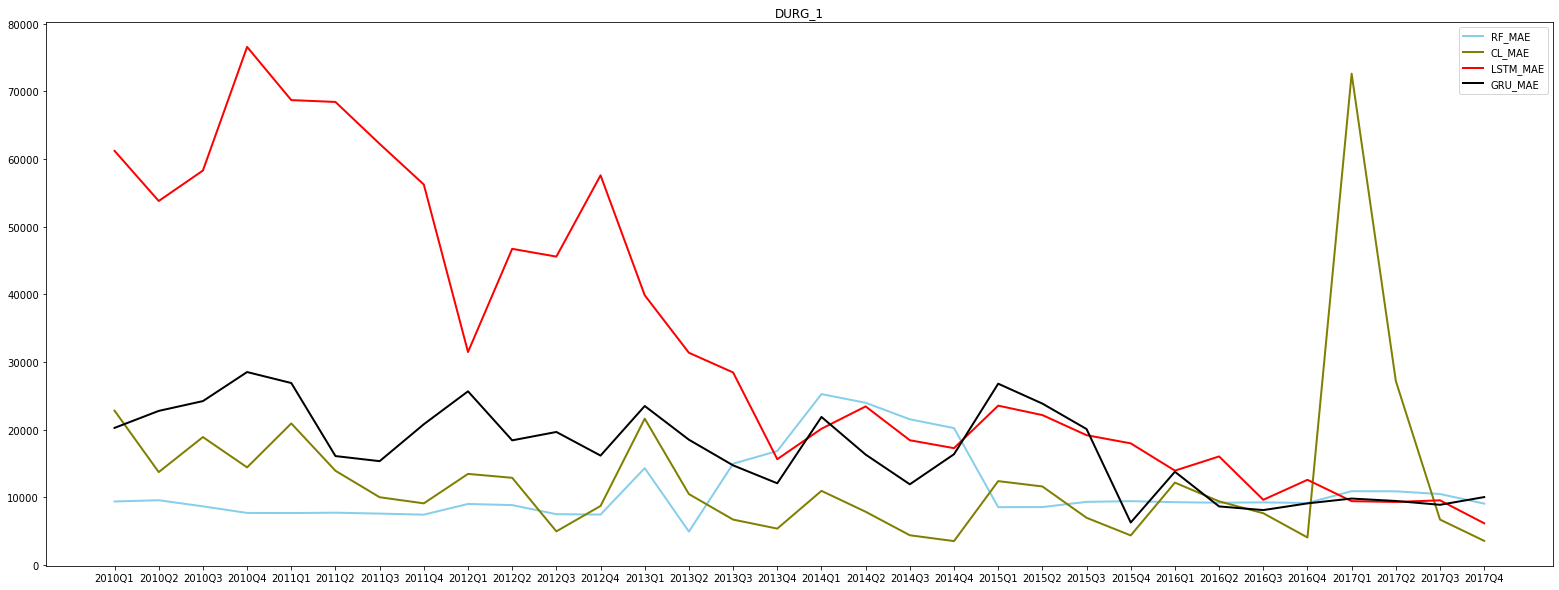

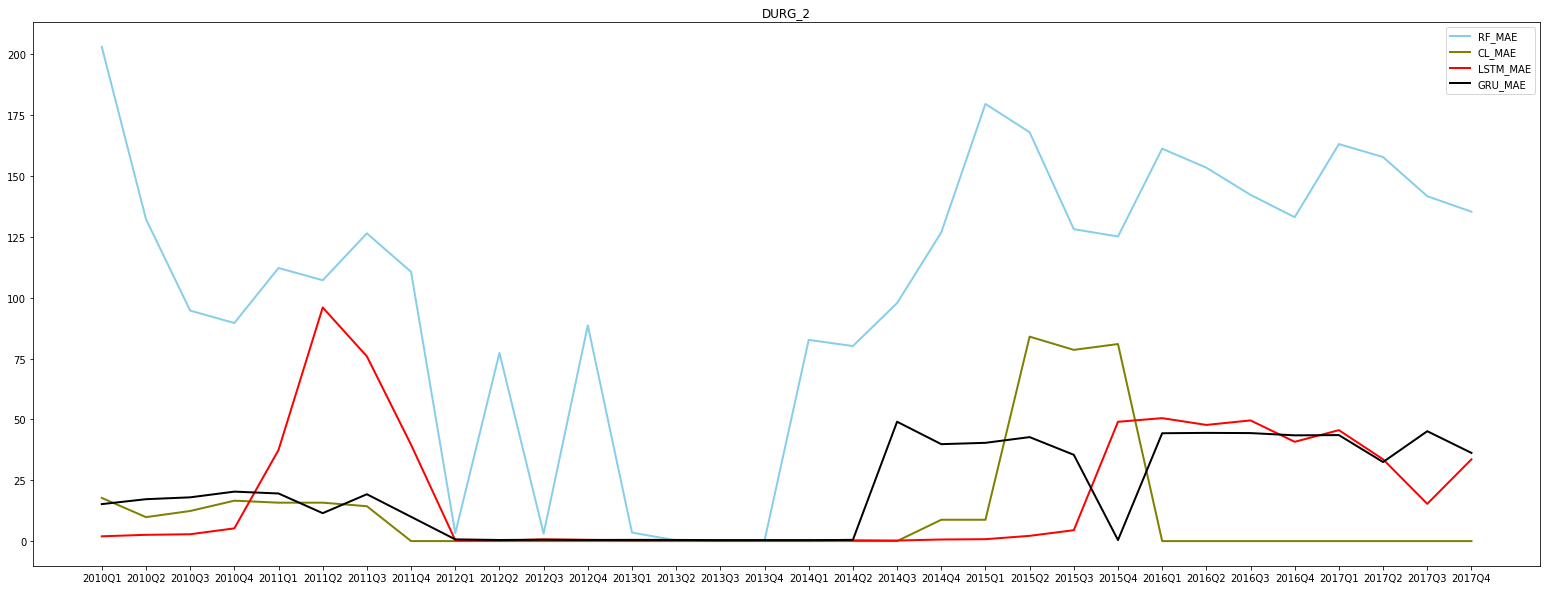

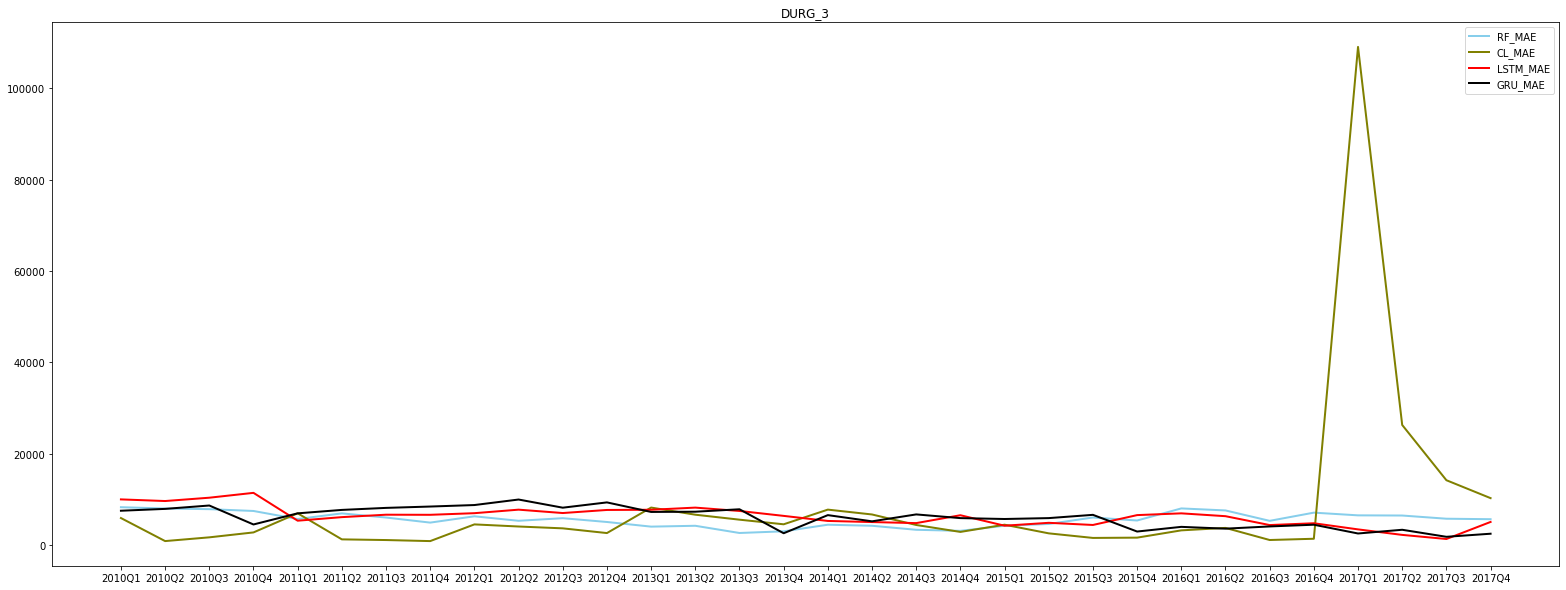

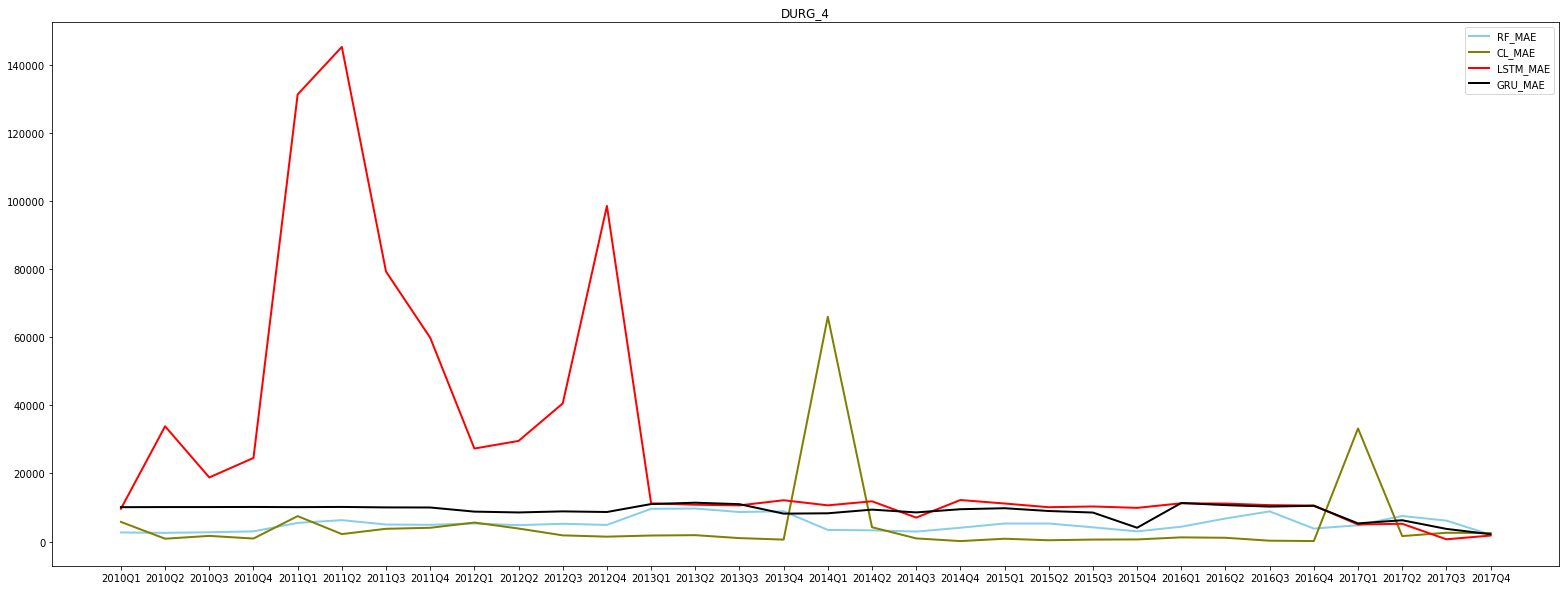

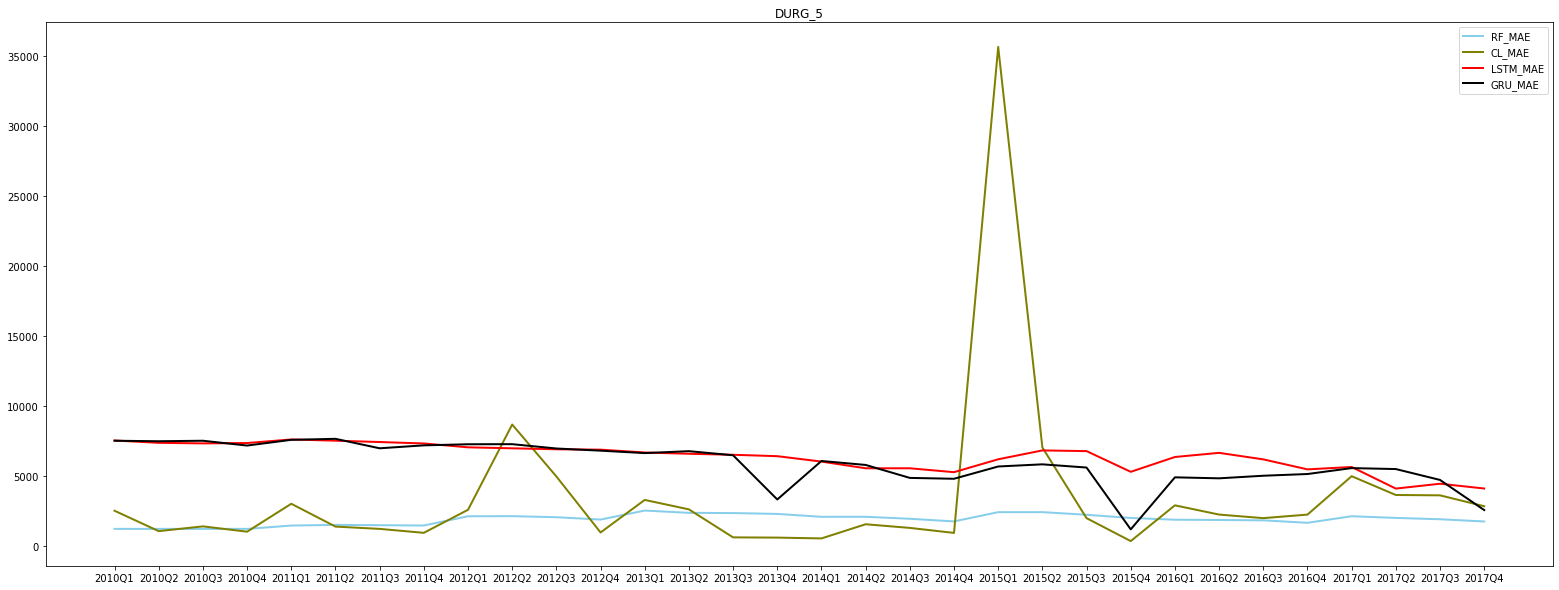

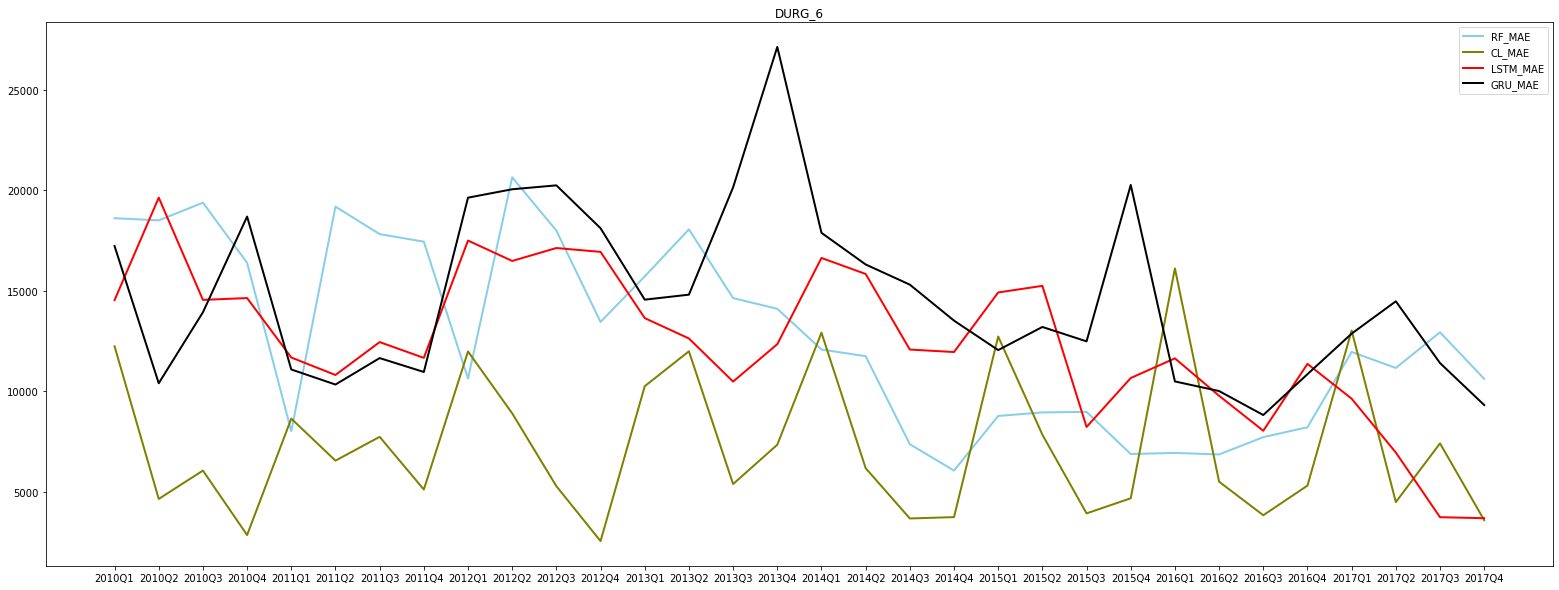

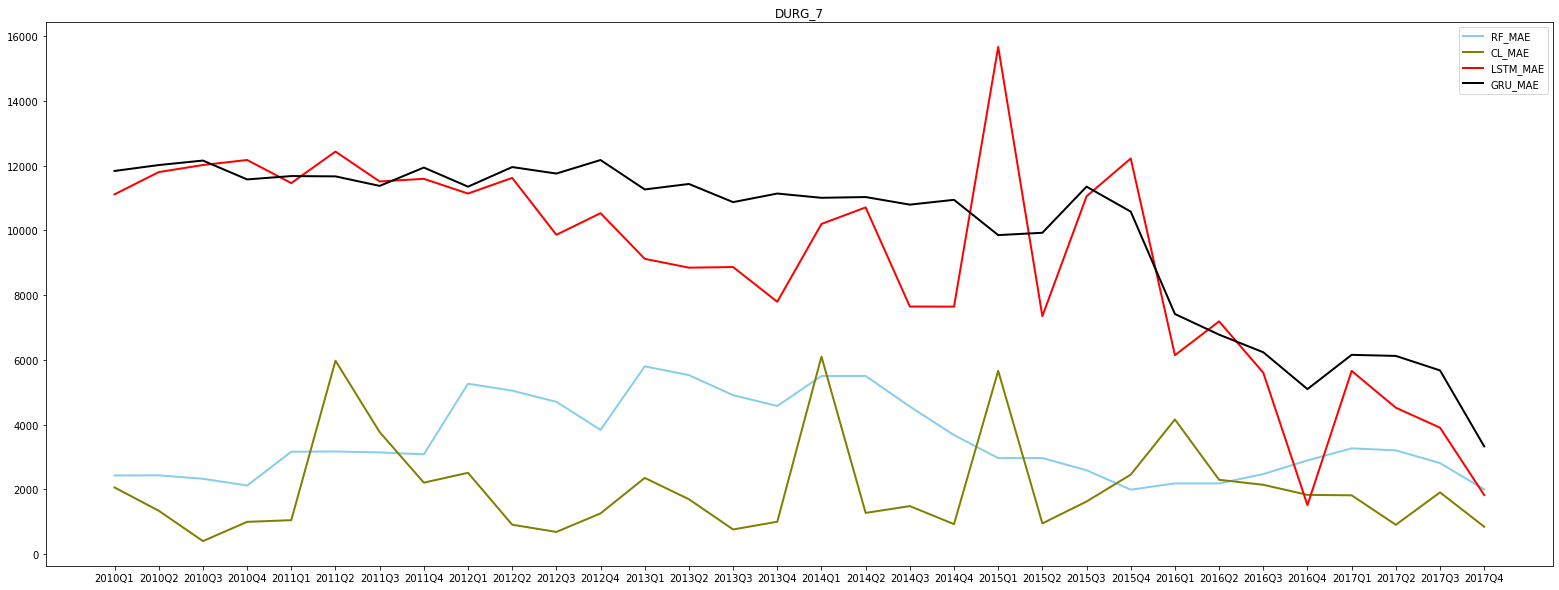

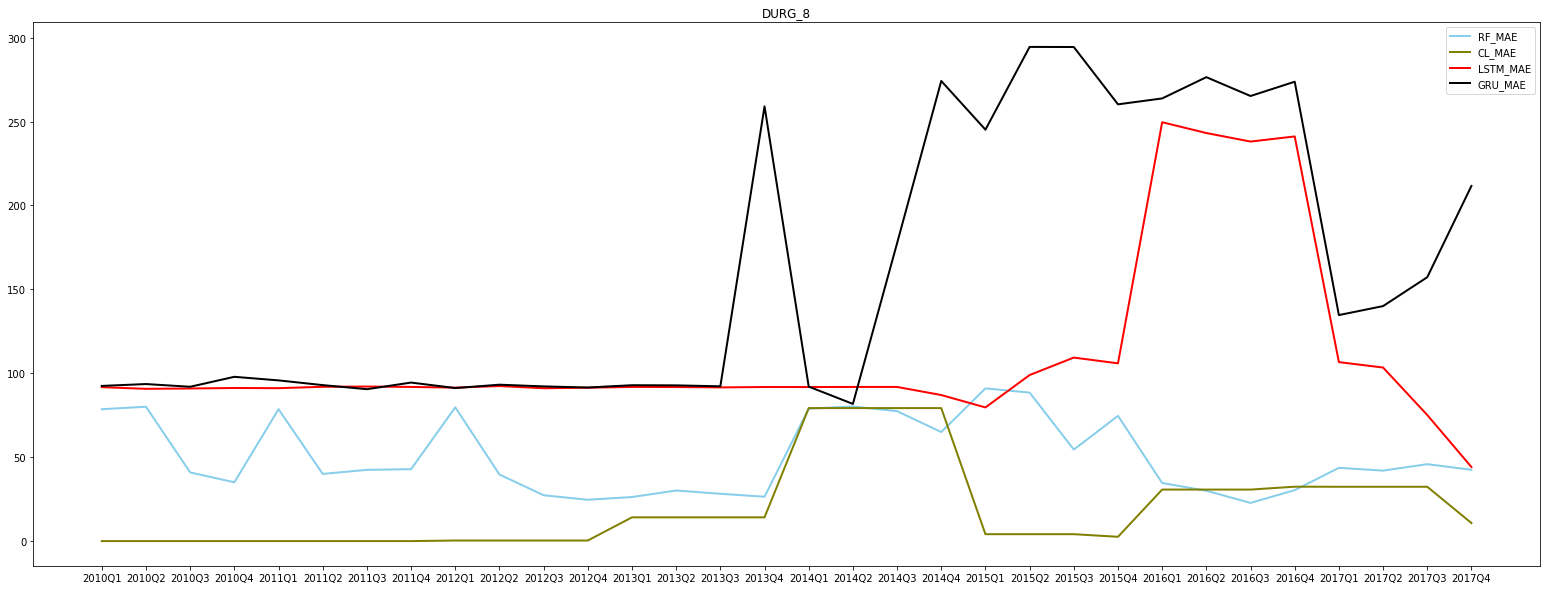

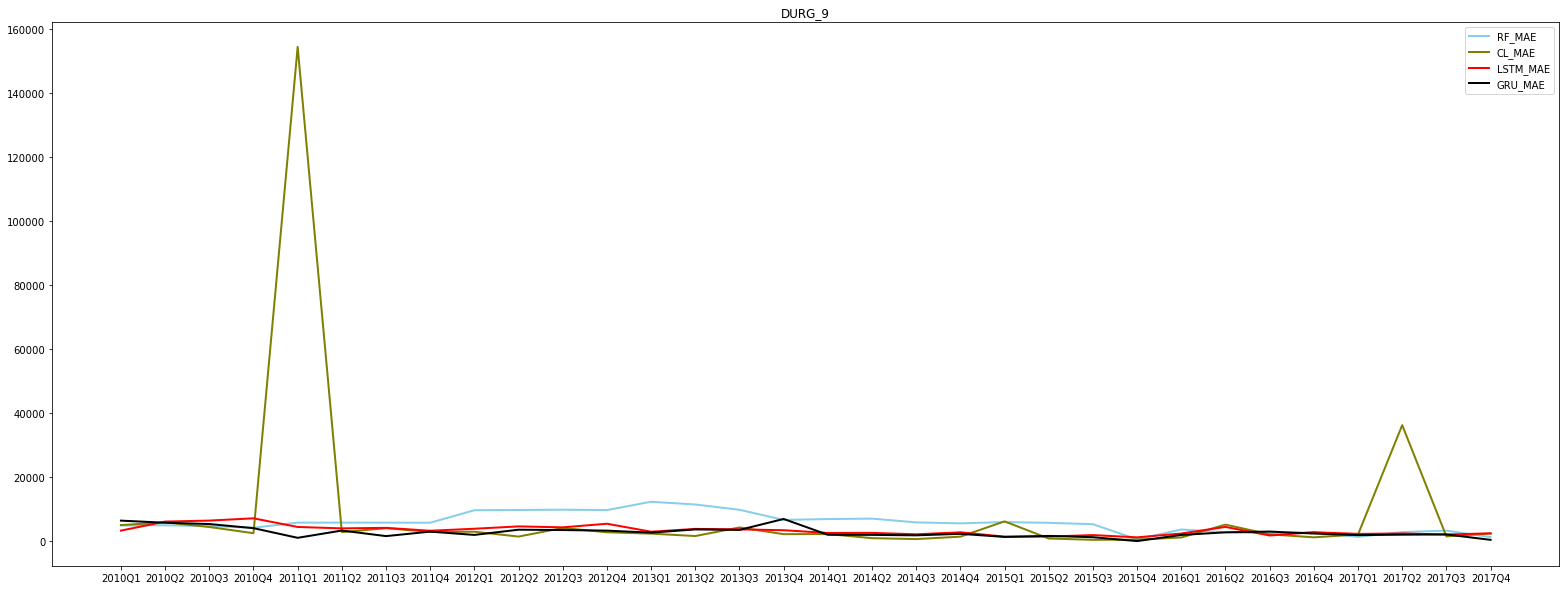

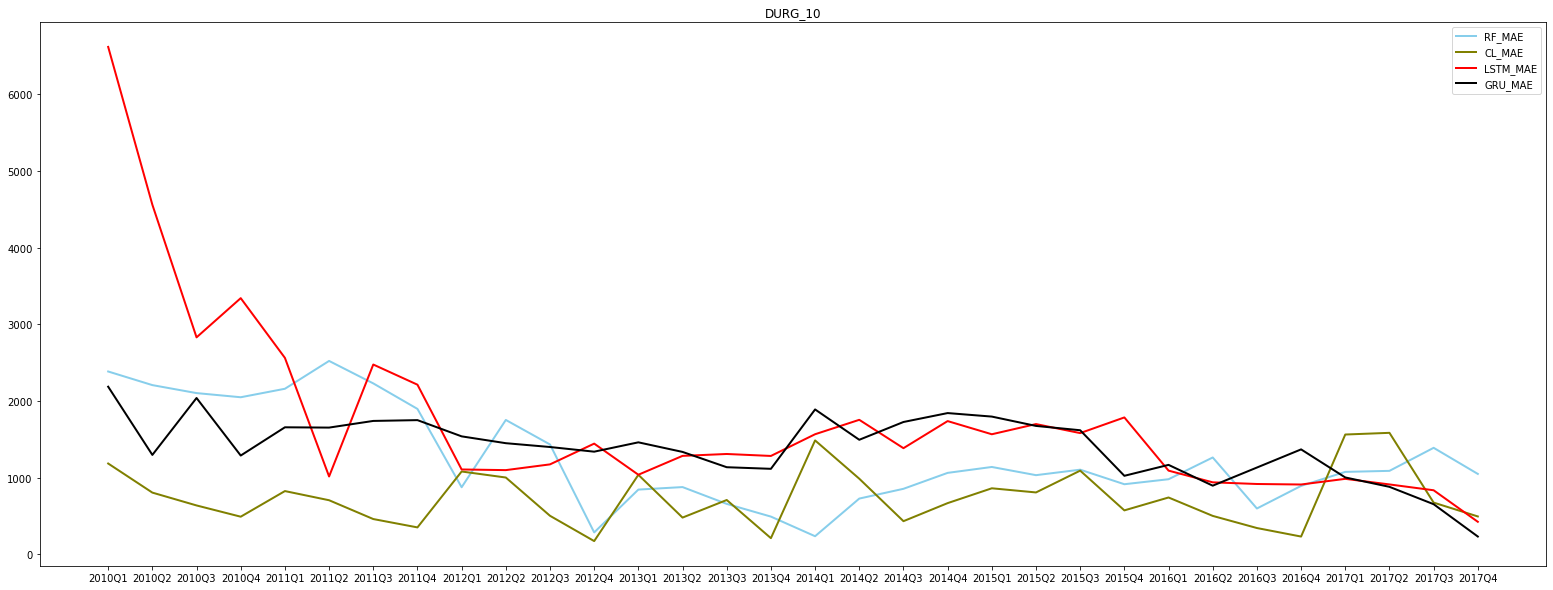

In [24]:
import matplotlib.pyplot as plt
for i in range(1,11):
    fig = plt.figure(figsize=(27,10))
    plt.plot( 'period', 'RF_MAE', data=RF_CCY_1[RF_CCY_1['DURG_Class'] == 'DURG_'+str(i)], marker='', color='skyblue', linewidth=2)
    plt.plot( 'period', 'CL_MAE', data=RF_CCY_1[RF_CCY_1['DURG_Class'] == 'DURG_'+str(i)], marker='', color='olive', linewidth=2)
    plt.plot( 'period', 'LSTM_MAE', data=RF_CCY_1[RF_CCY_1['DURG_Class'] == 'DURG_'+str(i)], marker='', color='red', linewidth=2)
    plt.plot( 'period', 'GRU_MAE', data=RF_CCY_1[RF_CCY_1['DURG_Class'] == 'DURG_'+str(i)], marker='', color='black', linewidth=2)
    plt.title("DURG_"+str(i))
    plt.legend()
    plt.show()

## Plots for different DURG numbers for after 8 period

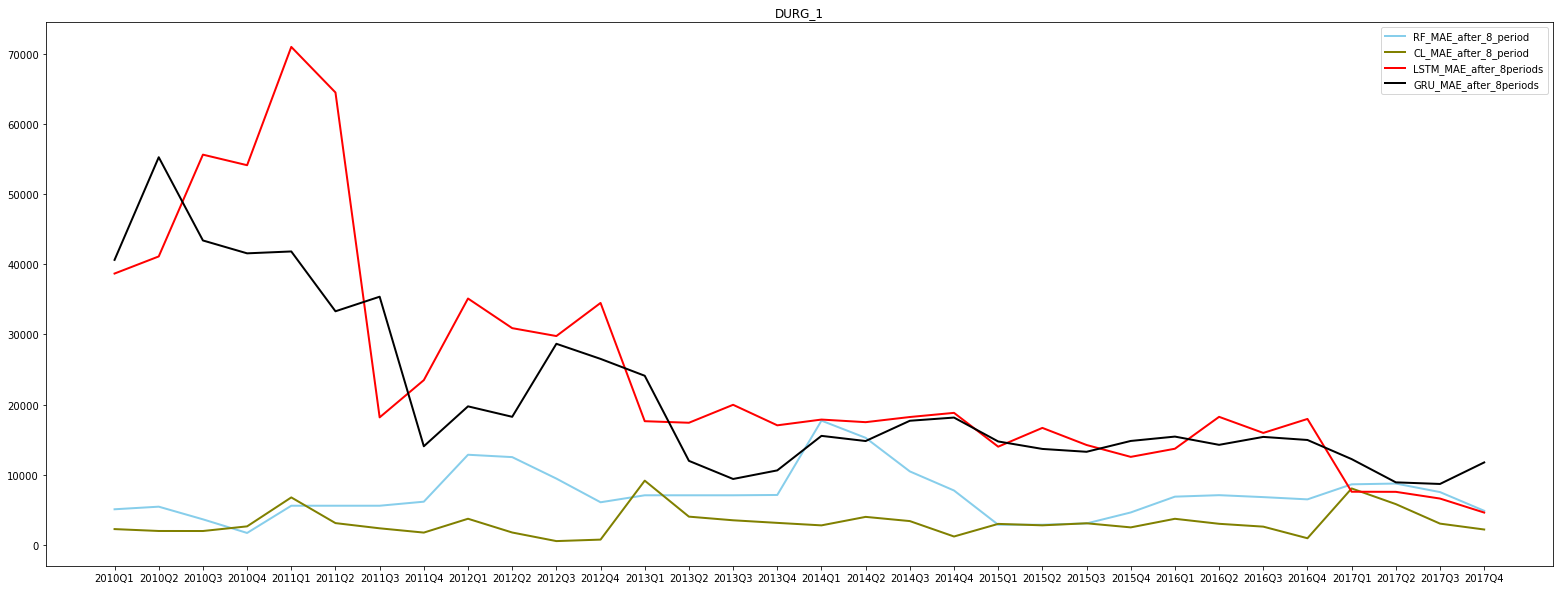

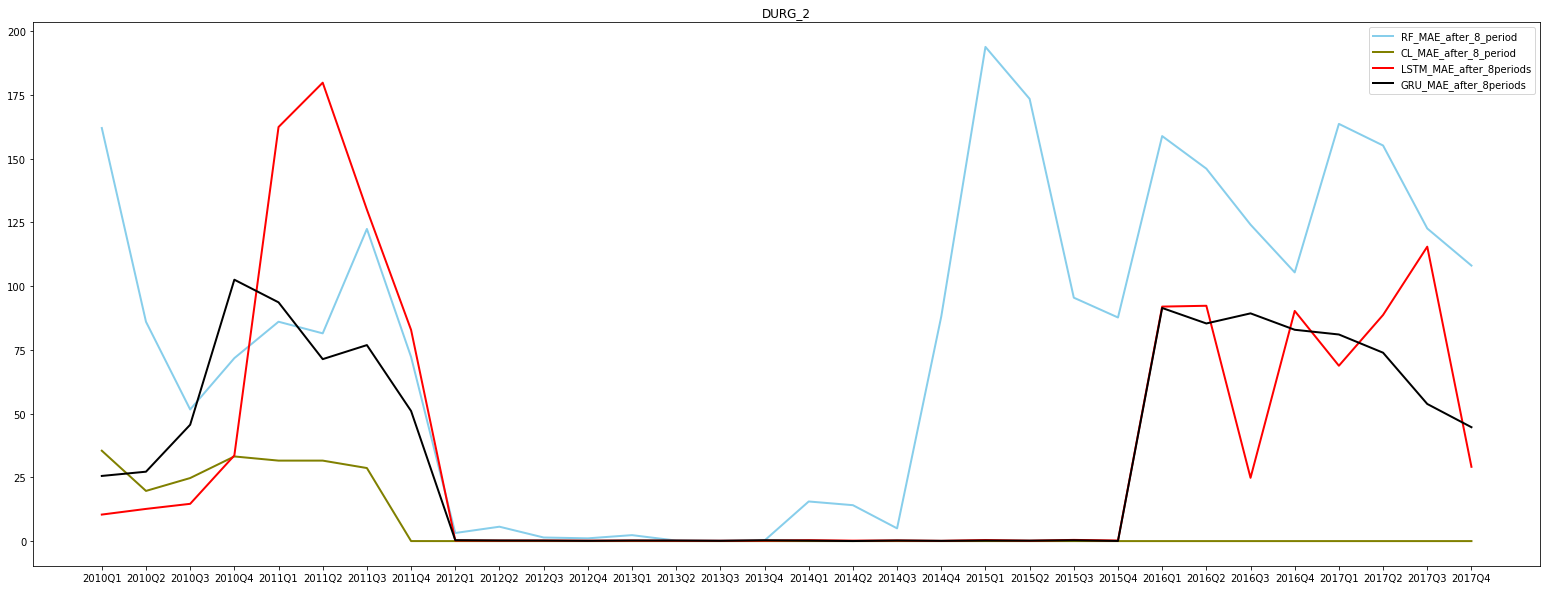

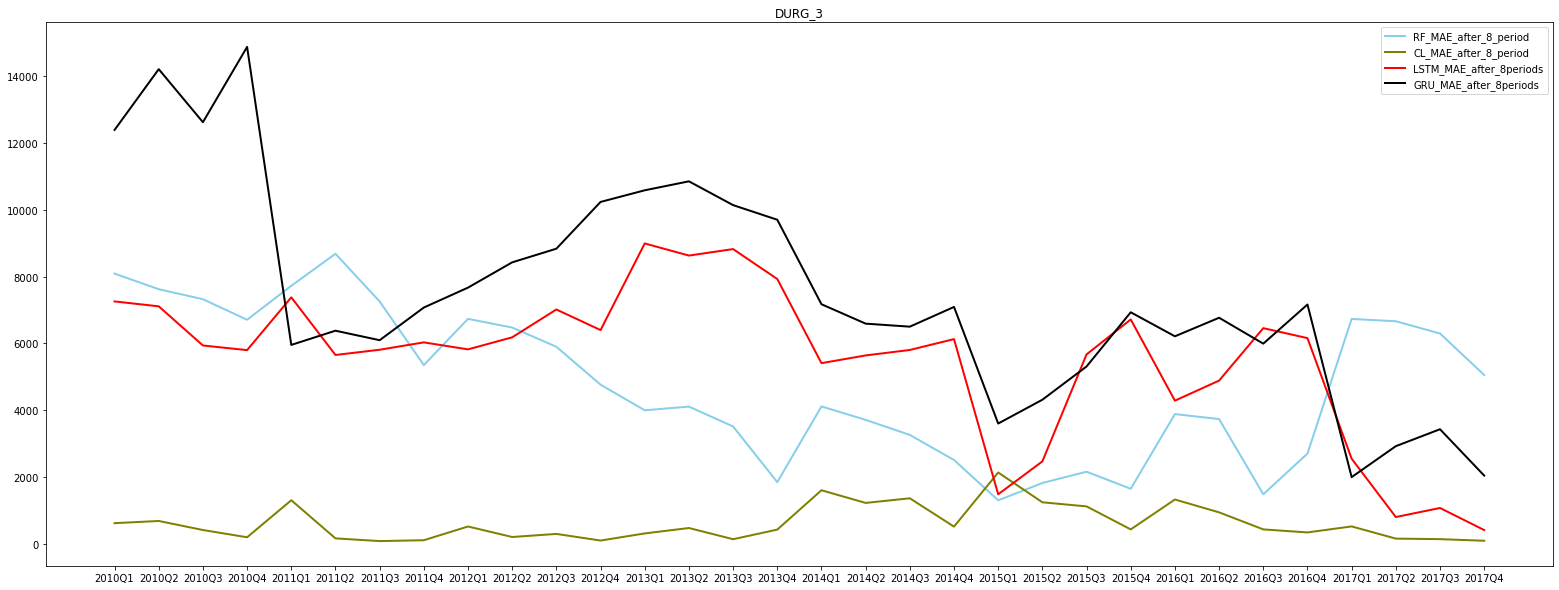

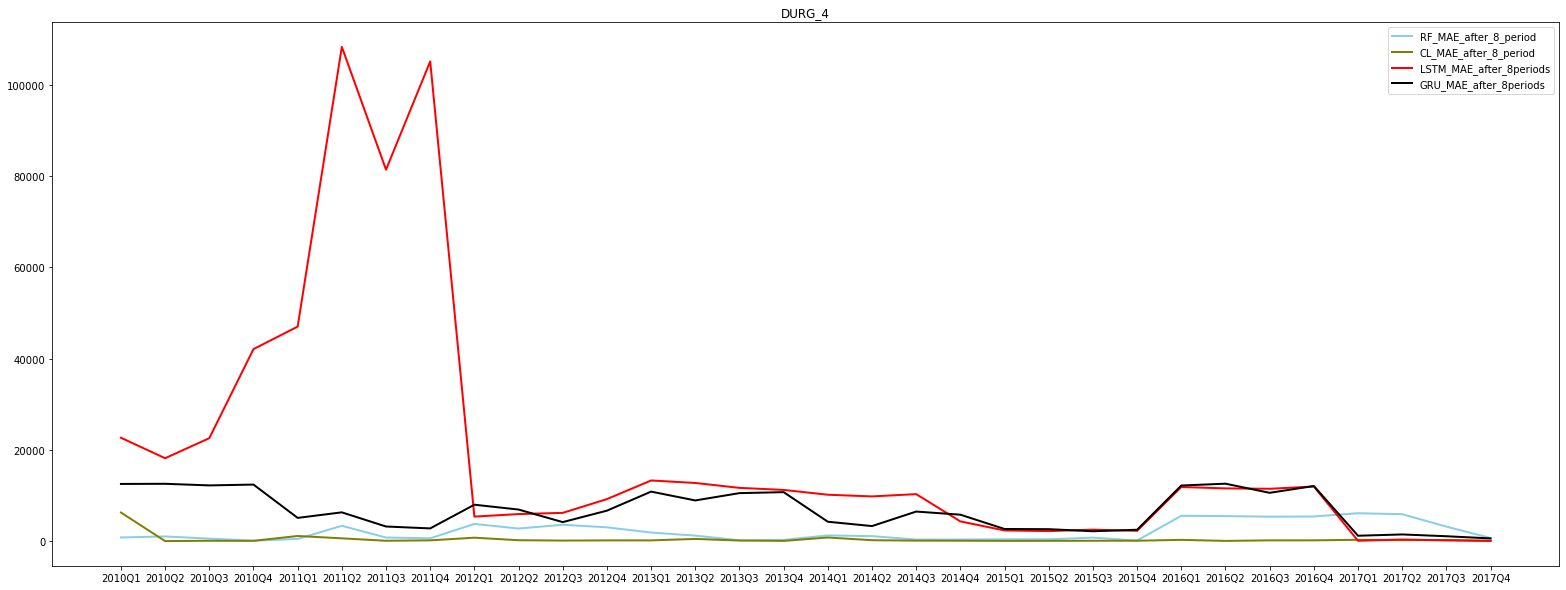

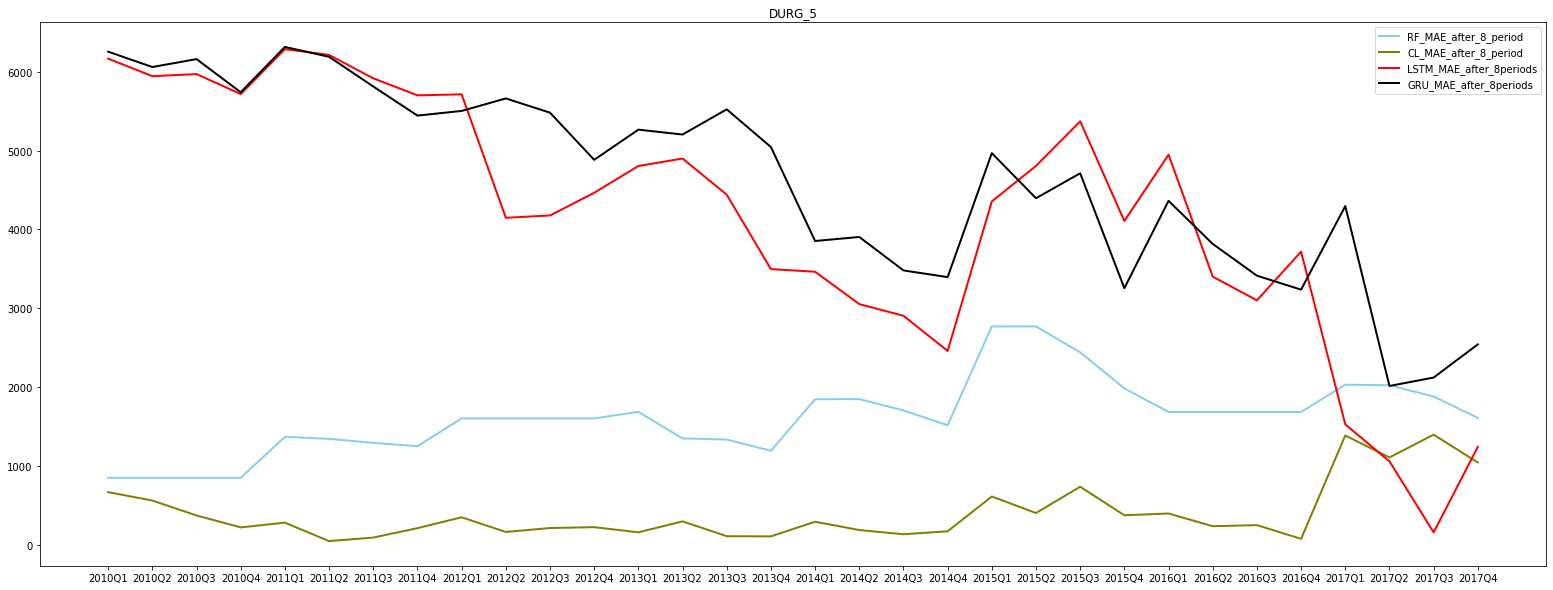

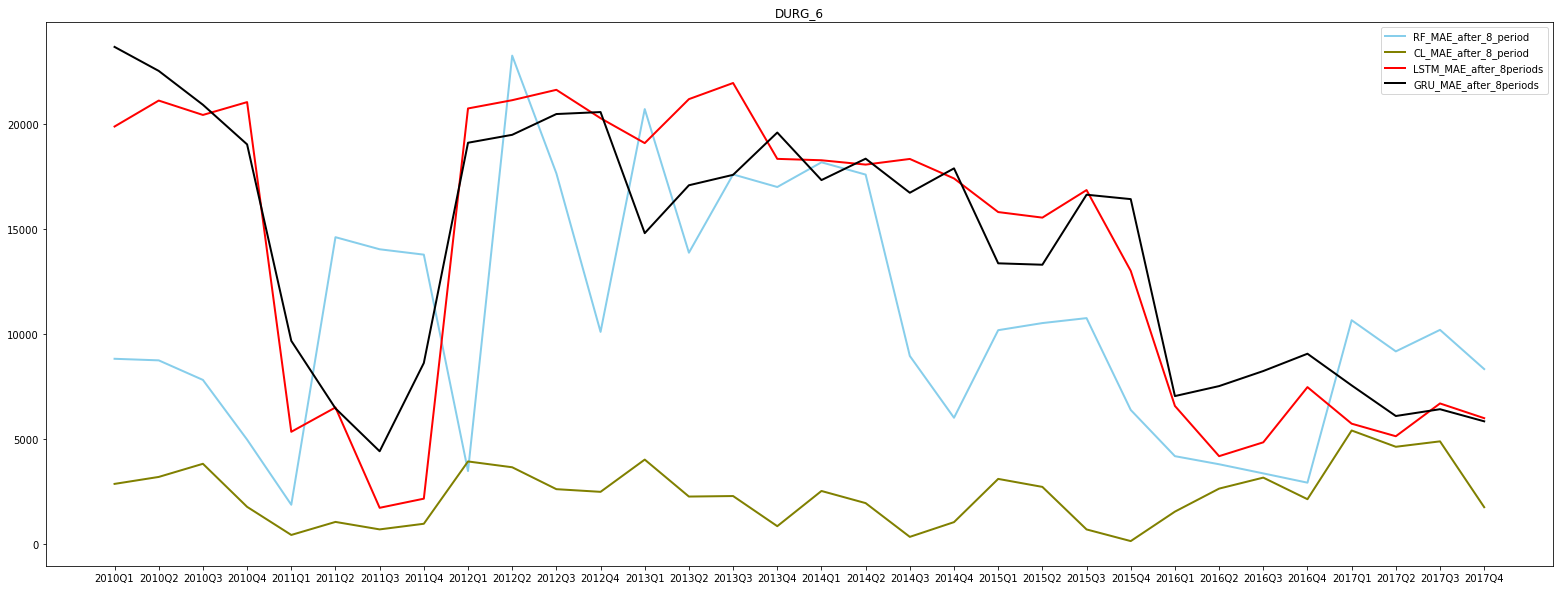

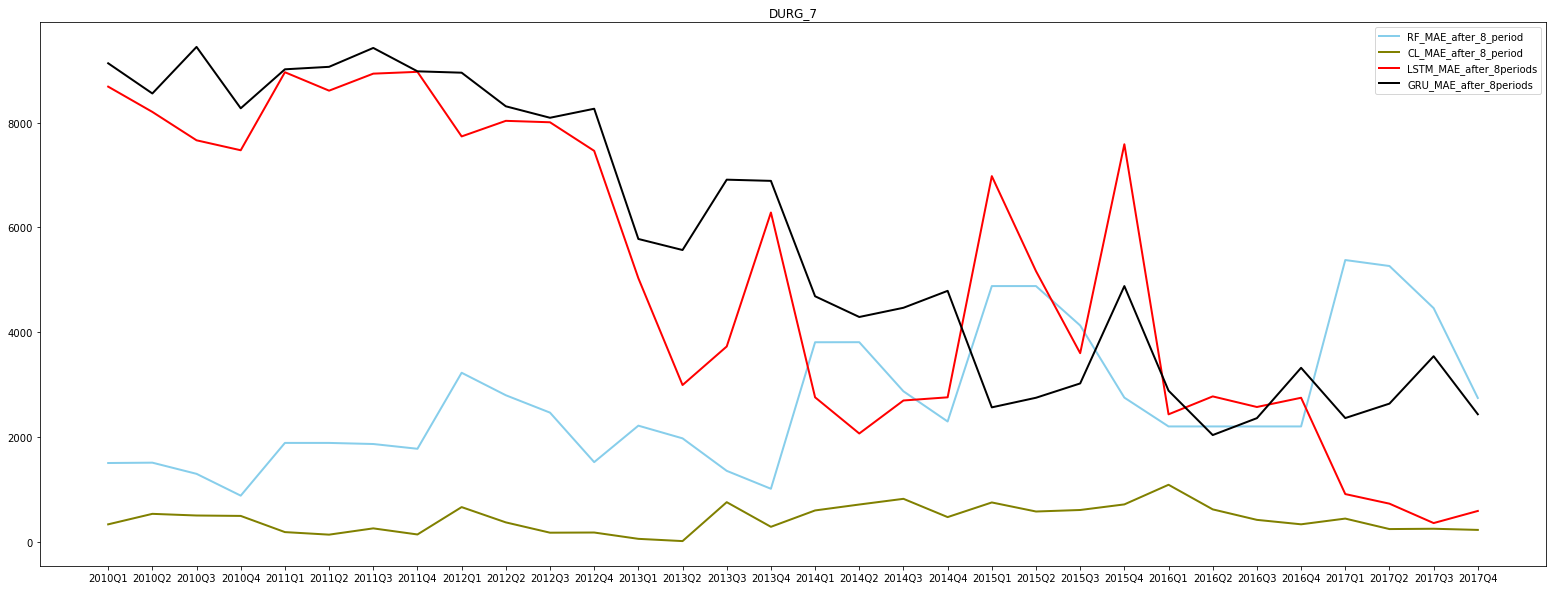

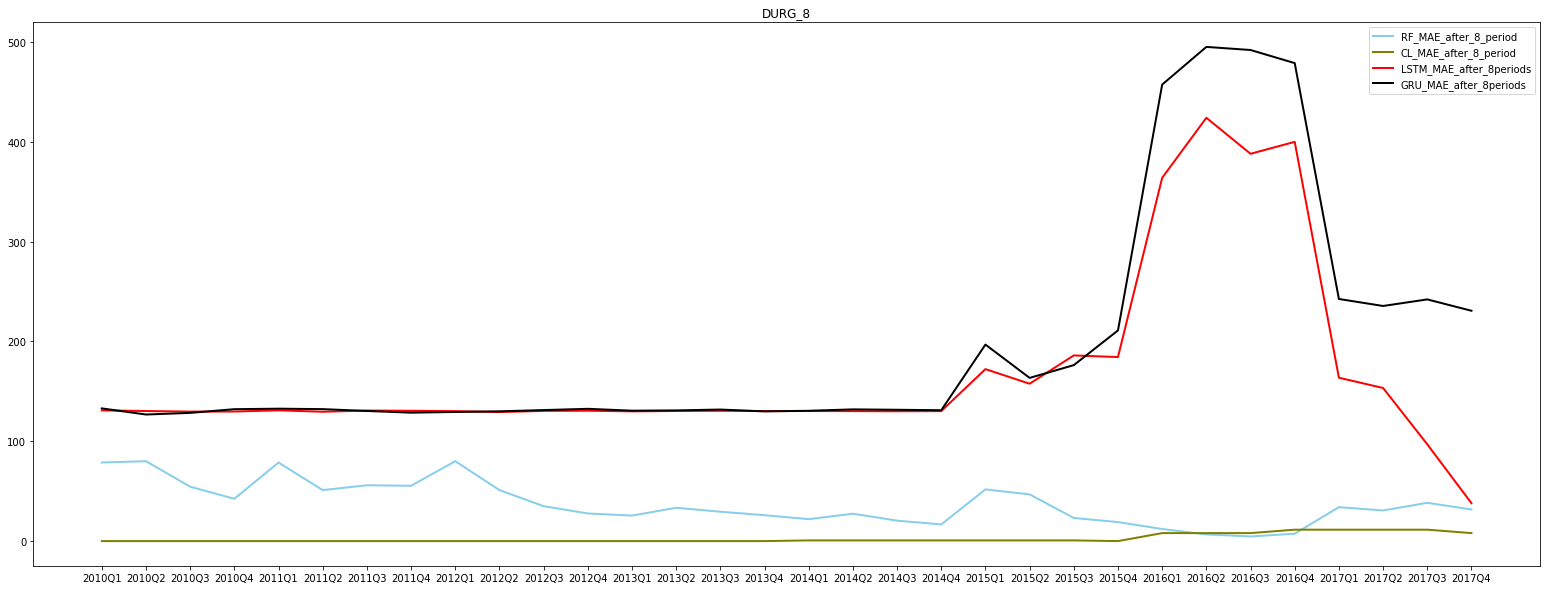

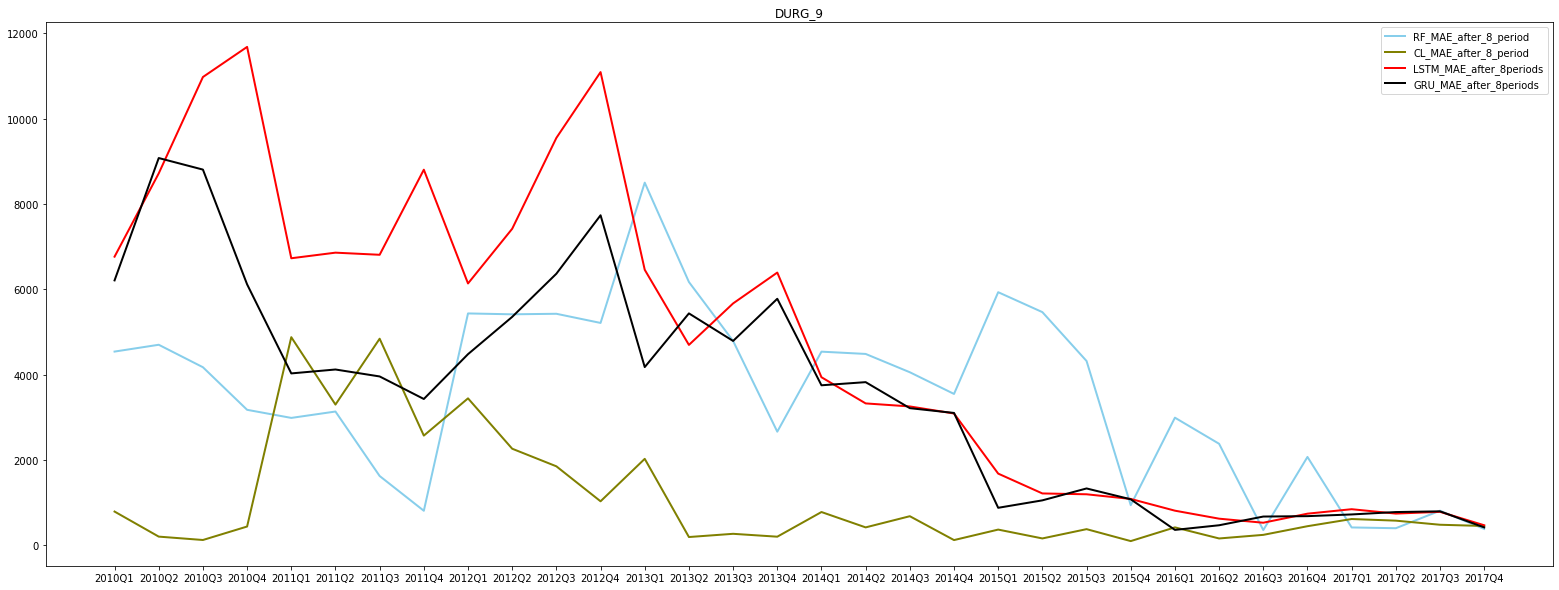

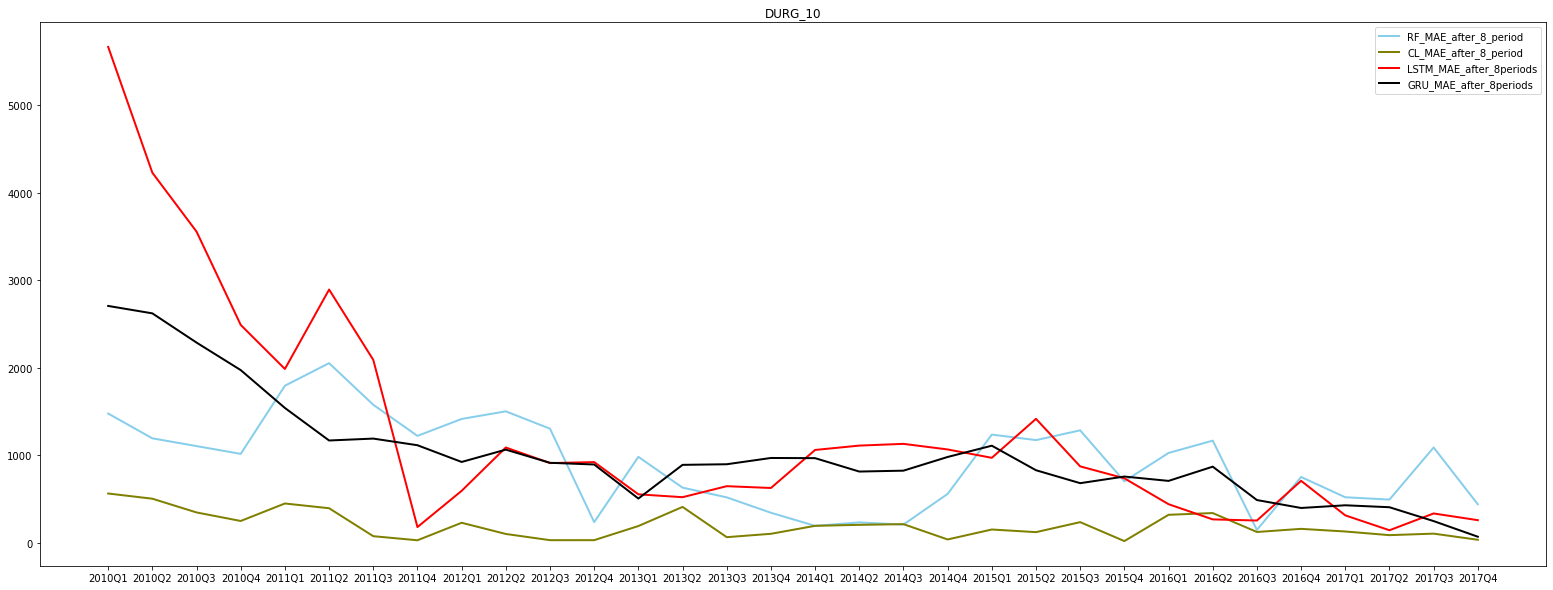

In [25]:
import matplotlib.pyplot as plt
for i in range(1,11):
    fig = plt.figure(figsize=(27,10))
    plt.plot( 'period', 'RF_MAE_after_8_period', data=RF_CCY_1[RF_CCY_1['DURG_Class'] == 'DURG_'+str(i)], marker='', color='skyblue', linewidth=2)
    plt.plot( 'period', 'CL_MAE_after_8_period', data=RF_CCY_1[RF_CCY_1['DURG_Class'] == 'DURG_'+str(i)], marker='', color='olive', linewidth=2)
    plt.plot( 'period', 'LSTM_MAE_after_8periods', data=RF_CCY_1[RF_CCY_1['DURG_Class'] == 'DURG_'+str(i)], marker='', color='red', linewidth=2)
    plt.plot( 'period', 'GRU_MAE_after_8periods', data=RF_CCY_1[RF_CCY_1['DURG_Class'] == 'DURG_'+str(i)], marker='', color='black', linewidth=2)
    plt.title("DURG_"+str(i))
    plt.legend()
    plt.show()

## Plot for all Durg numbers for full data

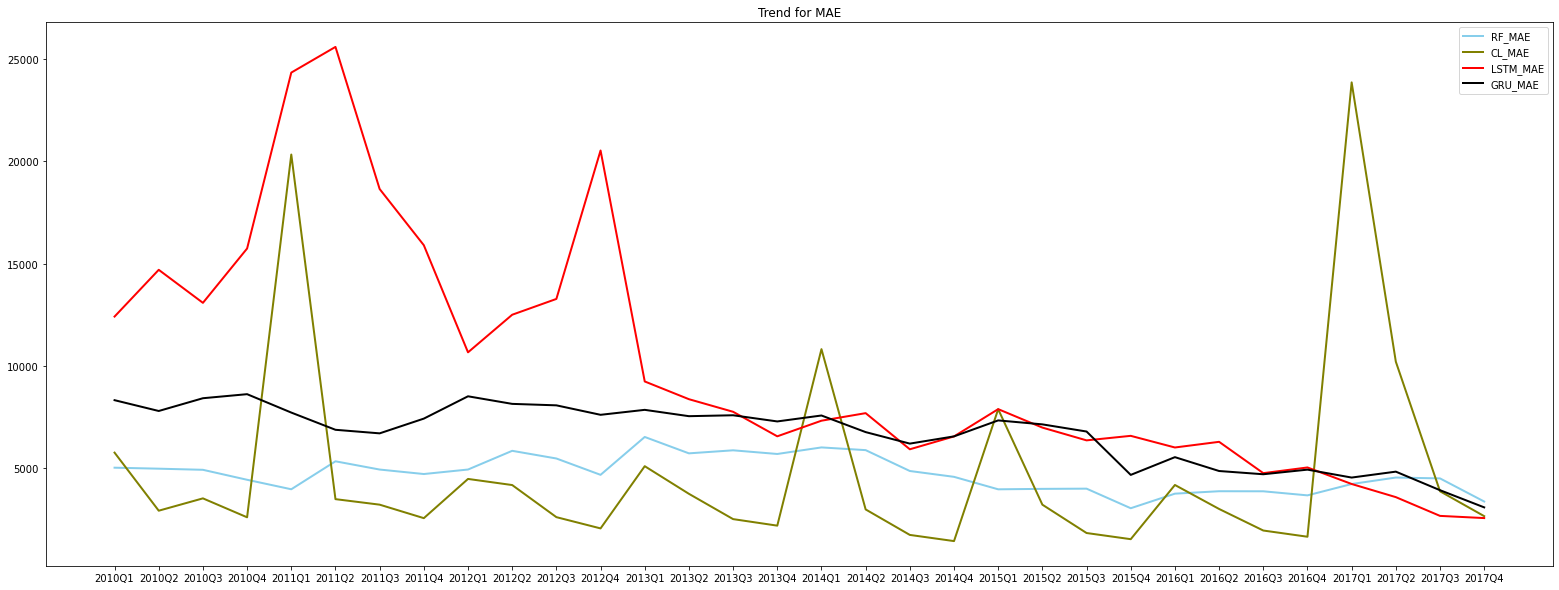

In [26]:
fig = plt.figure(figsize=(27,10))
plt.plot( 'period', 'RF_MAE', data=RF_CCY_1.groupby("period").mean().reset_index(), marker='', color='skyblue', linewidth=2)
plt.plot( 'period', 'CL_MAE', data=RF_CCY_1.groupby("period").mean().reset_index(), marker='', color='olive', linewidth=2)
plt.plot( 'period', 'LSTM_MAE', data=RF_CCY_1.groupby("period").mean().reset_index(), marker='', color='red', linewidth=2)
plt.plot( 'period', 'GRU_MAE', data=RF_CCY_1.groupby("period").mean().reset_index(), marker='', color='black', linewidth=2)
plt.title("Trend for MAE")
plt.legend()
plt.show()

## Plot for all DURG numbers for after 8 period

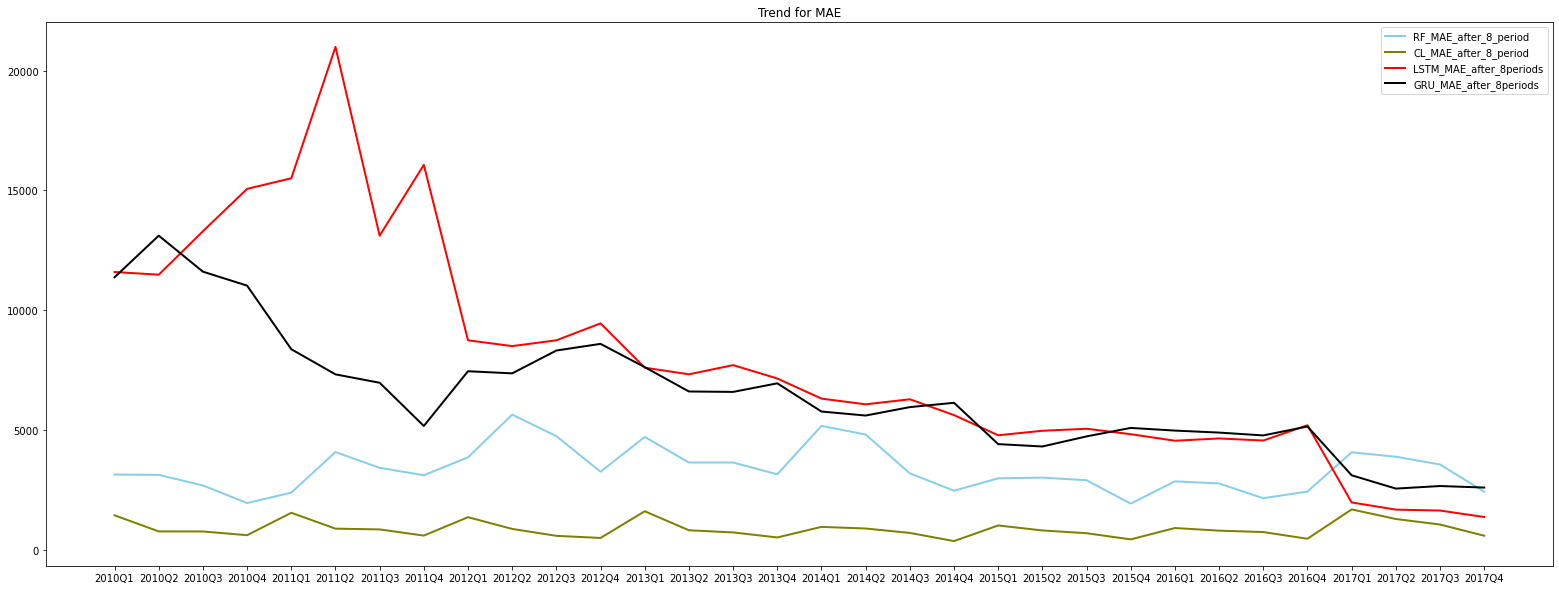

In [27]:
fig = plt.figure(figsize=(27,10))
plt.plot( 'period', 'RF_MAE_after_8_period', data=RF_CCY_1.groupby("period").mean().reset_index(), marker='', color='skyblue', linewidth=2)
plt.plot( 'period', 'CL_MAE_after_8_period', data=RF_CCY_1.groupby("period").mean().reset_index(), marker='', color='olive', linewidth=2)
plt.plot( 'period', 'LSTM_MAE_after_8periods', data=RF_CCY_1.groupby("period").mean().reset_index(), marker='', color='red', linewidth=2)
plt.plot( 'period', 'GRU_MAE_after_8periods', data=RF_CCY_1.groupby("period").mean().reset_index(), marker='', color='black', linewidth=2)
plt.title("Trend for MAE")
plt.legend()
plt.show()

# Output the data with premium

In [34]:
RF_CCY_1_with_premium = pd.read_csv("RF_Model_with_premium.csv")
RF_CCY_1_with_premium = RF_CCY_1_with_premium.drop('Unnamed: 0', axis = 1)

# LSTM full data
LSTM_2014 = pd.read_csv("result_LSTM_with_premium_2014.csv")
LSTM_2015_1 = pd.read_csv("result_LSTM_with_premium_2015_1.csv")
LSTM_2015_2 = pd.read_csv("result_LSTM_with_premium_2015_2.csv")
LSTM_2016 = pd.read_csv("result_LSTM_with_premium_2016.csv")
LSTM_2017 = pd.read_csv("result_LSTM_with_premium_2017.csv")
result_LSTM = pd.concat([LSTM_2014,LSTM_2015_1,LSTM_2015_2,LSTM_2016,LSTM_2017])
result_processed_LSTM = result_LSTM.copy()
result_processed_LSTM = result_processed_LSTM.rename(columns = {'0':"LSTM_MAE_with_premium", 'Unnamed: 0':"DURG_Class"})
result_processed_LSTM["reporting_year"] = result_processed_LSTM["reporting_year"].astype(str)
result_processed_LSTM["reporting_number"] = result_processed_LSTM["reporting_number"].astype(str)
LSTM_CCY_1 = result_processed_LSTM[["DURG_Class","reporting_year","reporting_number","LSTM_MAE_with_premium"]]
LSTM_CCY_1 = LSTM_CCY_1.groupby(["DURG_Class","reporting_year","reporting_number" ]).mean().reset_index()
LSTM_CCY_1 = LSTM_CCY_1.assign(period=lambda x:x["reporting_year"] +"Q"+x["reporting_number"])
LSTM_CCY_1['DURG_Class'] = pd.Categorical(LSTM_CCY_1['DURG_Class'], ["DURG_1","DURG_2","DURG_3","DURG_4","DURG_5","DURG_6","DURG_7","DURG_8","DURG_9","DURG_10"])
LSTM_CCY_1 = LSTM_CCY_1.sort_values(["reporting_year","reporting_number","DURG_Class"])
LSTM_CCY_1_value = list(LSTM_CCY_1["LSTM_MAE_with_premium"])
RF_CCY_1_with_premium["LSTM_MAE_with_premium"] = LSTM_CCY_1_value


# GRU full data
df_GRU_2014_2015 = pd.read_csv("result_GRU_with_premium_2014&2015.csv")
df_GRU_2016_2017 = pd.read_csv("result_GRU_with_premium_2016&2017.csv")
result_GRU = pd.concat([df_GRU_2014_2015,df_GRU_2016_2017])
result_processed_GRU = result_GRU.copy()
result_processed_GRU = result_processed_GRU.rename(columns = {'0':"GRU_MAE_with_premium", 'Unnamed: 0':"DURG_Class"})
result_processed_GRU["reporting_year"] = result_processed_GRU["reporting_year"].astype(str)
result_processed_GRU["reporting_number"] = result_processed_GRU["reporting_number"].astype(str)
GRU_CCY_1 = result_processed_GRU[["DURG_Class","reporting_year","reporting_number","GRU_MAE_with_premium"]]
GRU_CCY_1 = GRU_CCY_1.groupby(["DURG_Class","reporting_year","reporting_number" ]).mean().reset_index()
GRU_CCY_1 = GRU_CCY_1.assign(period=lambda x:x["reporting_year"] +"Q"+x["reporting_number"])
GRU_CCY_1['DURG_Class'] = pd.Categorical(GRU_CCY_1['DURG_Class'], ["DURG_1","DURG_2","DURG_3","DURG_4","DURG_5","DURG_6","DURG_7","DURG_8","DURG_9","DURG_10"])
GRU_CCY_1 = GRU_CCY_1.sort_values(["reporting_year","reporting_number","DURG_Class"])
GRU_CCY_1_value = list(GRU_CCY_1["GRU_MAE_with_premium"])
RF_CCY_1_with_premium["GRU_MAE_with_premium"] = GRU_CCY_1_value

# LSTM after 8 periods data
LSTM_2014 = pd.read_csv("result_LSTM_with_premium_2014_8period.csv")
LSTM_2015 = pd.read_csv("result_LSTM_with_premium_2015_8period.csv")
LSTM_2017 = pd.read_csv("result_LSTM_with_premium_2016&2017_8period.csv")
result_LSTM = pd.concat([LSTM_2014,LSTM_2015,LSTM_2017])
result_processed_LSTM = result_LSTM.copy()
result_processed_LSTM = result_processed_LSTM.rename(columns = {'0':"LSTM_MAE_after_8_period_with_premium", 'Unnamed: 0':"DURG_Class"})
result_processed_LSTM["reporting_year"] = result_processed_LSTM["reporting_year"].astype(str)
result_processed_LSTM["reporting_number"] = result_processed_LSTM["reporting_number"].astype(str)
LSTM_CCY_1 = result_processed_LSTM[["DURG_Class","reporting_year","reporting_number","LSTM_MAE_after_8_period_with_premium"]]
LSTM_CCY_1 = LSTM_CCY_1.groupby(["DURG_Class","reporting_year","reporting_number" ]).mean().reset_index()
LSTM_CCY_1 = LSTM_CCY_1.assign(period=lambda x:x["reporting_year"] +"Q"+x["reporting_number"])
LSTM_CCY_1['DURG_Class'] = pd.Categorical(LSTM_CCY_1['DURG_Class'], ["DURG_1","DURG_2","DURG_3","DURG_4","DURG_5","DURG_6","DURG_7","DURG_8","DURG_9","DURG_10"])
LSTM_CCY_1 = LSTM_CCY_1.sort_values(["reporting_year","reporting_number","DURG_Class"])
LSTM_CCY_1_value = list(LSTM_CCY_1["LSTM_MAE_after_8_period_with_premium"])
RF_CCY_1_with_premium["LSTM_MAE_after_8_period_with_premium"] = LSTM_CCY_1_value


# GRU after 8 periods data
df_GRU_2014_2015 = pd.read_csv("result_GRU_with_premium_2014&2015_8periods.csv")
df_GRU_2016_2017 = pd.read_csv("result_GRU_with_premium_2016&2017_8periods.csv")
result_GRU = pd.concat([df_GRU_2014_2015,df_GRU_2016_2017])
result_processed_GRU = result_GRU.copy()
result_processed_GRU = result_processed_GRU.rename(columns = {'0':"GRU_MAE_after_8_period_with_premium", 'Unnamed: 0':"DURG_Class"})
result_processed_GRU["reporting_year"] = result_processed_GRU["reporting_year"].astype(str)
result_processed_GRU["reporting_number"] = result_processed_GRU["reporting_number"].astype(str)
GRU_CCY_1 = result_processed_GRU[["DURG_Class","reporting_year","reporting_number","GRU_MAE_after_8_period_with_premium"]]
GRU_CCY_1 = GRU_CCY_1.groupby(["DURG_Class","reporting_year","reporting_number" ]).mean().reset_index()
GRU_CCY_1 = GRU_CCY_1.assign(period=lambda x:x["reporting_year"] +"Q"+x["reporting_number"])
GRU_CCY_1['DURG_Class'] = pd.Categorical(GRU_CCY_1['DURG_Class'], ["DURG_1","DURG_2","DURG_3","DURG_4","DURG_5","DURG_6","DURG_7","DURG_8","DURG_9","DURG_10"])
GRU_CCY_1 = GRU_CCY_1.sort_values(["reporting_year","reporting_number","DURG_Class"])
GRU_CCY_1_value = list(GRU_CCY_1["GRU_MAE_after_8_period_with_premium"])
RF_CCY_1_with_premium["GRU_MAE_after_8_period_with_premium"] = GRU_CCY_1_value

RF_CCY_1_with_premium = RF_CCY_1_with_premium[["DURG_Class","reporting_year","reporting_number","RF_MAE_with_premium","CL_MAE_with_premium","LSTM_MAE_with_premium","GRU_MAE_with_premium","RF_MAE_after_8_period_with_premium","CL_MAE_after_8_period_with_premium","LSTM_MAE_after_8_period_with_premium",
"GRU_MAE_after_8_period_with_premium","period"]]

In [33]:
Average_RF_CCY_1_MAE_with_premium = RF_CCY_1_with_premium["RF_MAE_with_premium"].mean()
Average_CL_CCY_1_MAE_with_premium = RF_CCY_1_with_premium["CL_MAE_with_premium"].mean()
Average_LSTM_CCY_1_MAE_with_premium = RF_CCY_1_with_premium["LSTM_MAE_with_premium"].mean()
Average_GRU_CCY_1_MAE_with_premium = RF_CCY_1_with_premium["GRU_MAE_with_premium"].mean()
Average_RF_CCY_1_MAE_after_8_period_with_premium = RF_CCY_1_with_premium["RF_MAE_after_8_period_with_premium"].mean()
Average_CL_CCY_1_MAE_after_8_period_with_premium = RF_CCY_1_with_premium["CL_MAE_after_8_period_with_premium"].mean()
Average_LSTM_CCY_1_MAE_after_8_period_with_premium = RF_CCY_1_with_premium["LSTM_MAE_after_8_period_with_premium"].mean()
Average_GRU_CCY_1_MAE_after_8_period_with_premium = RF_CCY_1_with_premium["GRU_MAE_after_8_period_with_premium"].mean()
print("Average MAE for RF with premium: {} ".format(Average_RF_CCY_1_MAE_with_premium))
print("Average MAE for CL with premium: {} ".format(Average_CL_CCY_1_MAE_with_premium))
print("Average MAE for LSTM with premium: {} ".format(Average_LSTM_CCY_1_MAE_with_premium))
print("Average MAE for GRU with premium: {} ".format(Average_GRU_CCY_1_MAE_with_premium))
print("Average MAE for RF after 8 period with premium: {} ".format(Average_RF_CCY_1_MAE_after_8_period_with_premium))
print("Average MAE for CL after 8 period with premium: {} ".format(Average_CL_CCY_1_MAE_after_8_period_with_premium))
print("Average MAE for LSTM after 8 period with premium: {} ".format(Average_LSTM_CCY_1_MAE_after_8_period_with_premium))
print("Average MAE for GRU after 8 period with premium: {} ".format(Average_GRU_CCY_1_MAE_after_8_period_with_premium))

Average MAE for RF with premium: 4169.26951105417 
Average MAE for CL with premium: 5176.808019235783 
Average MAE for LSTM with premium: 8759.427167255024 
Average MAE for GRU with premium: 8581.157653167349 
Average MAE for RF after 8 period with premium: 2803.460042697263 
Average MAE for CL after 8 period with premium: 832.6668073696588 
Average MAE for LSTM after 8 period with premium: 4435.06246669922 
Average MAE for GRU after 8 period with premium: 4668.463036173084 


### Plots for different Durg number for full data

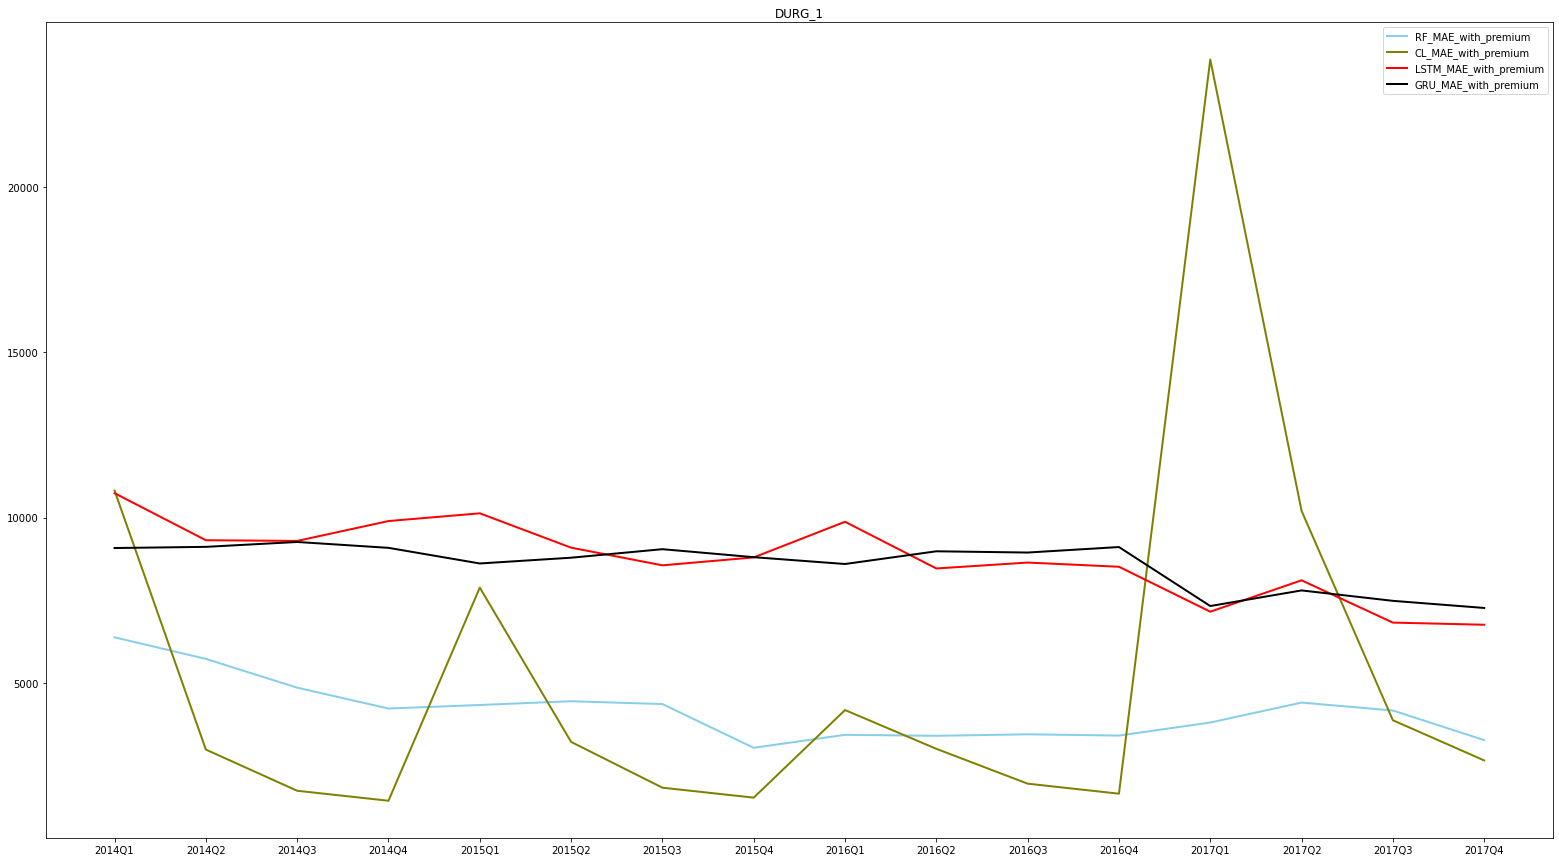

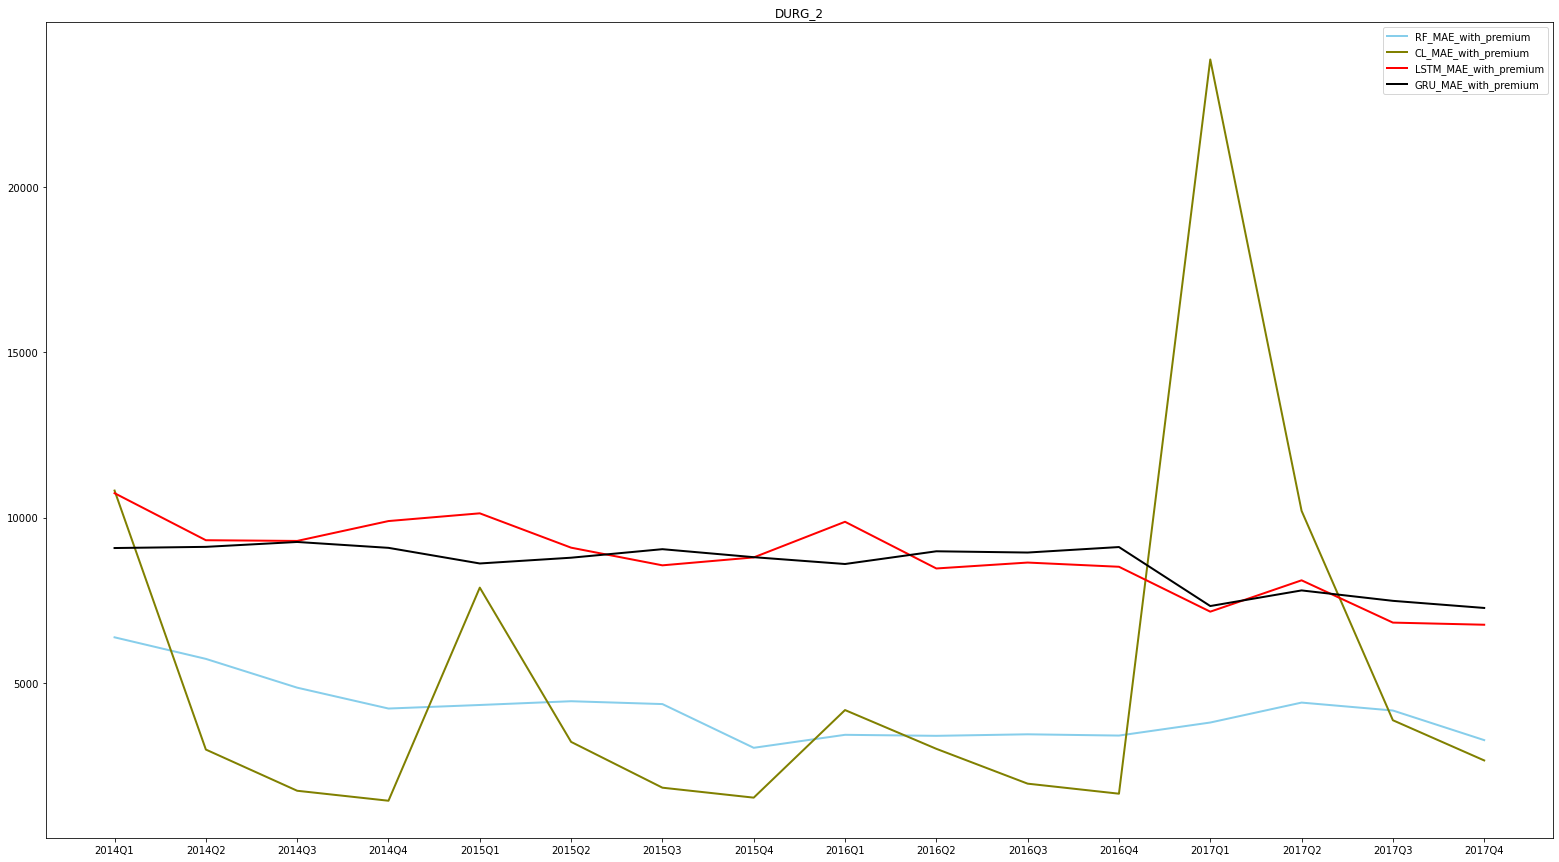

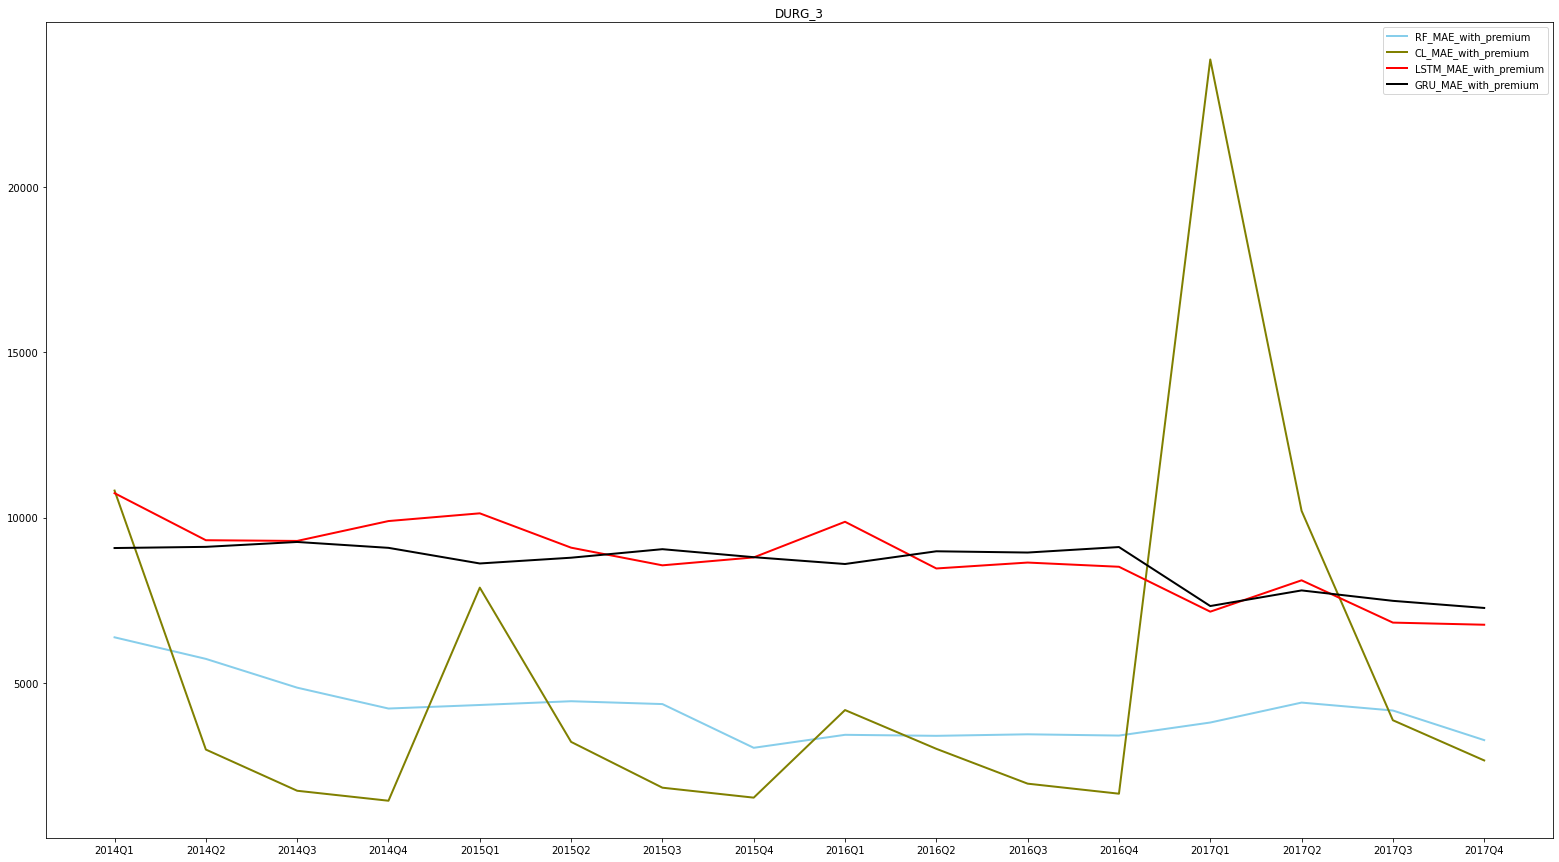

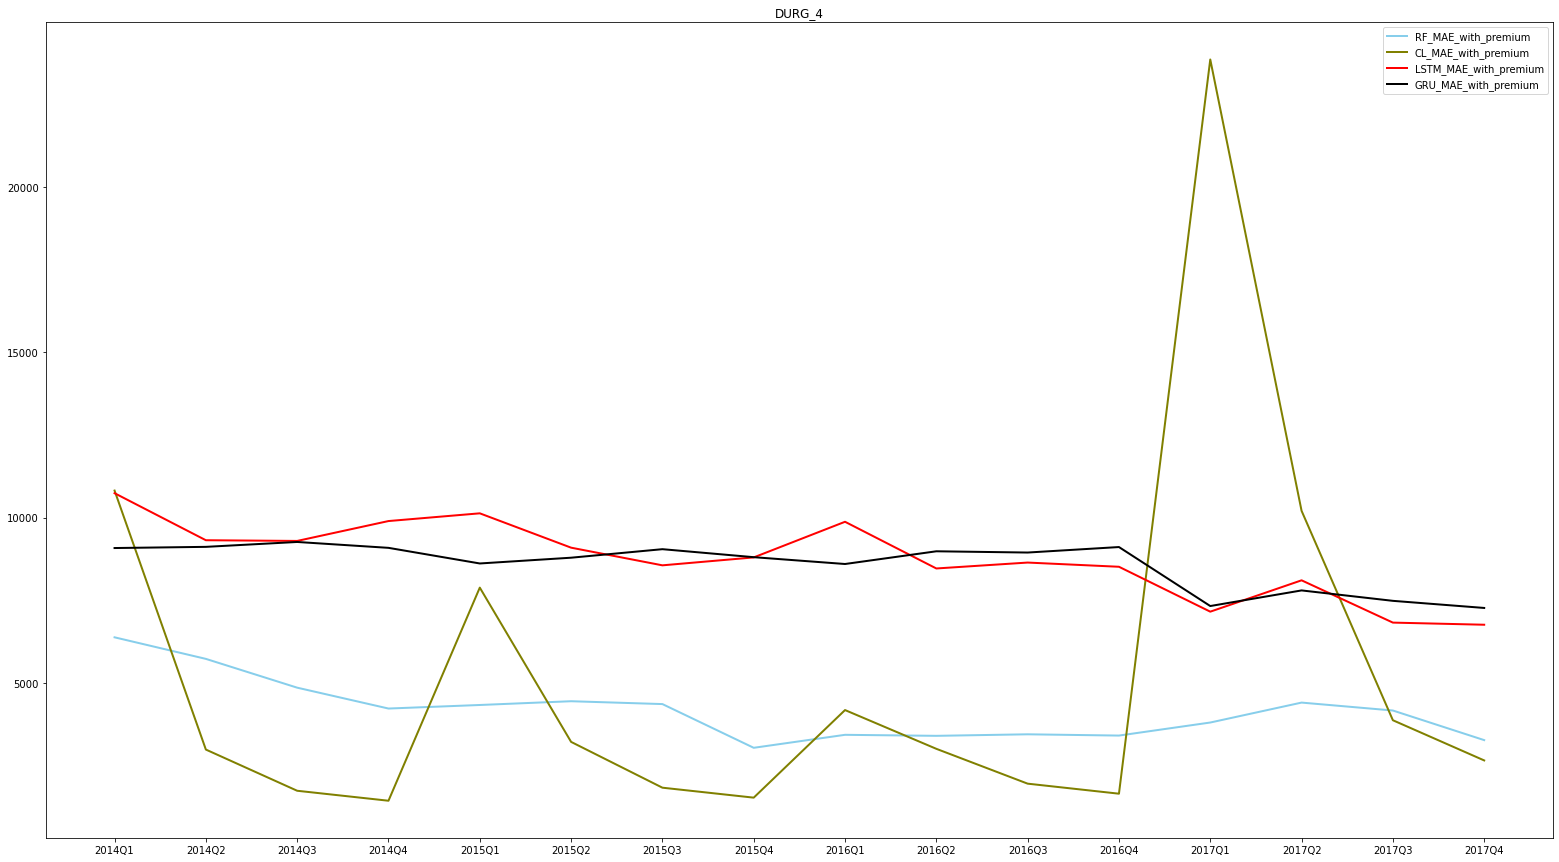

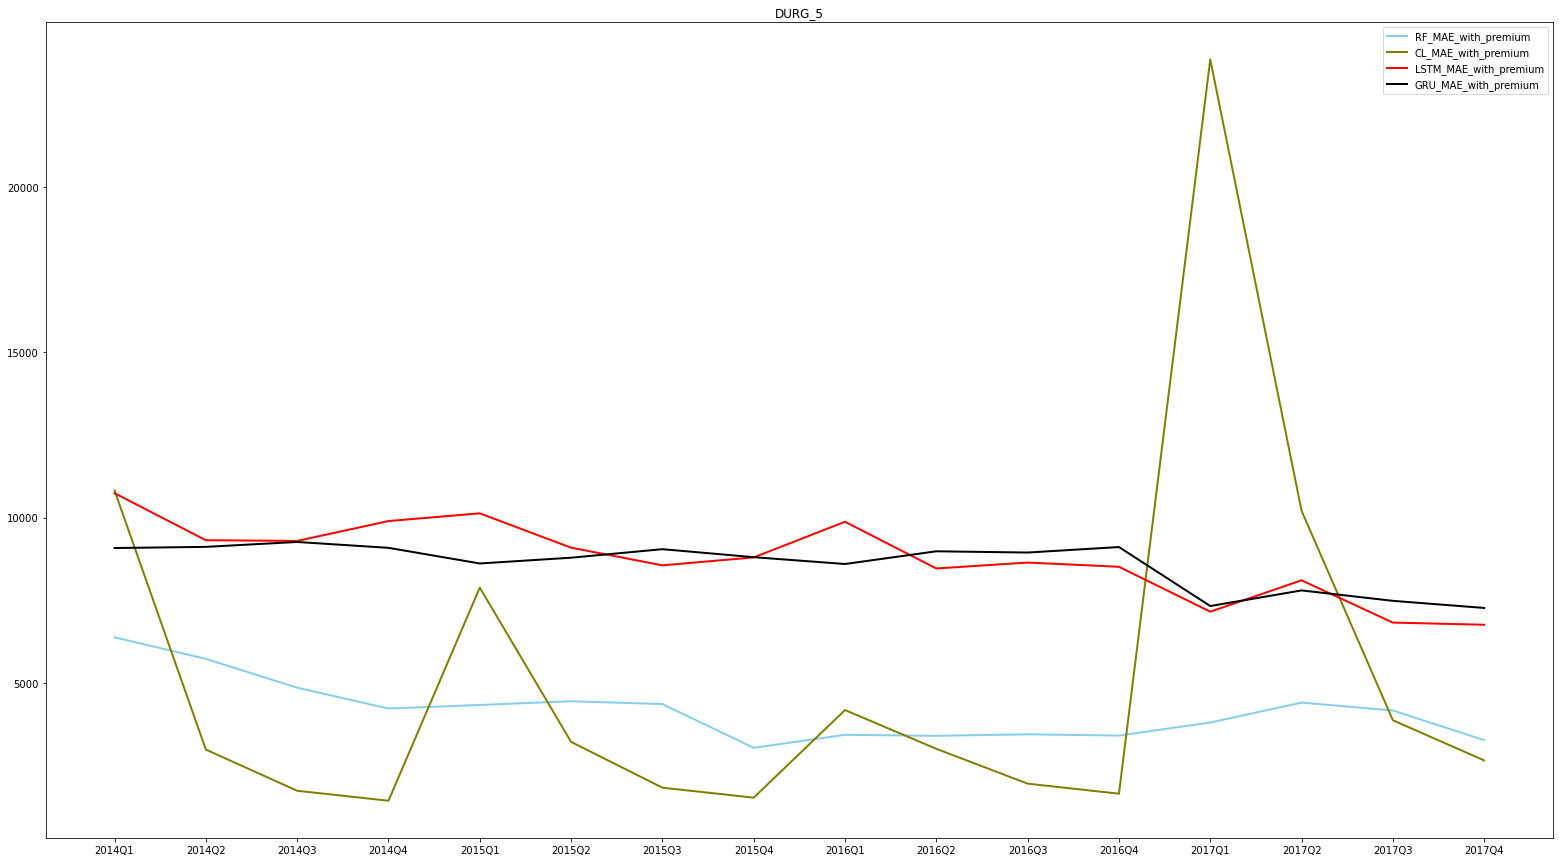

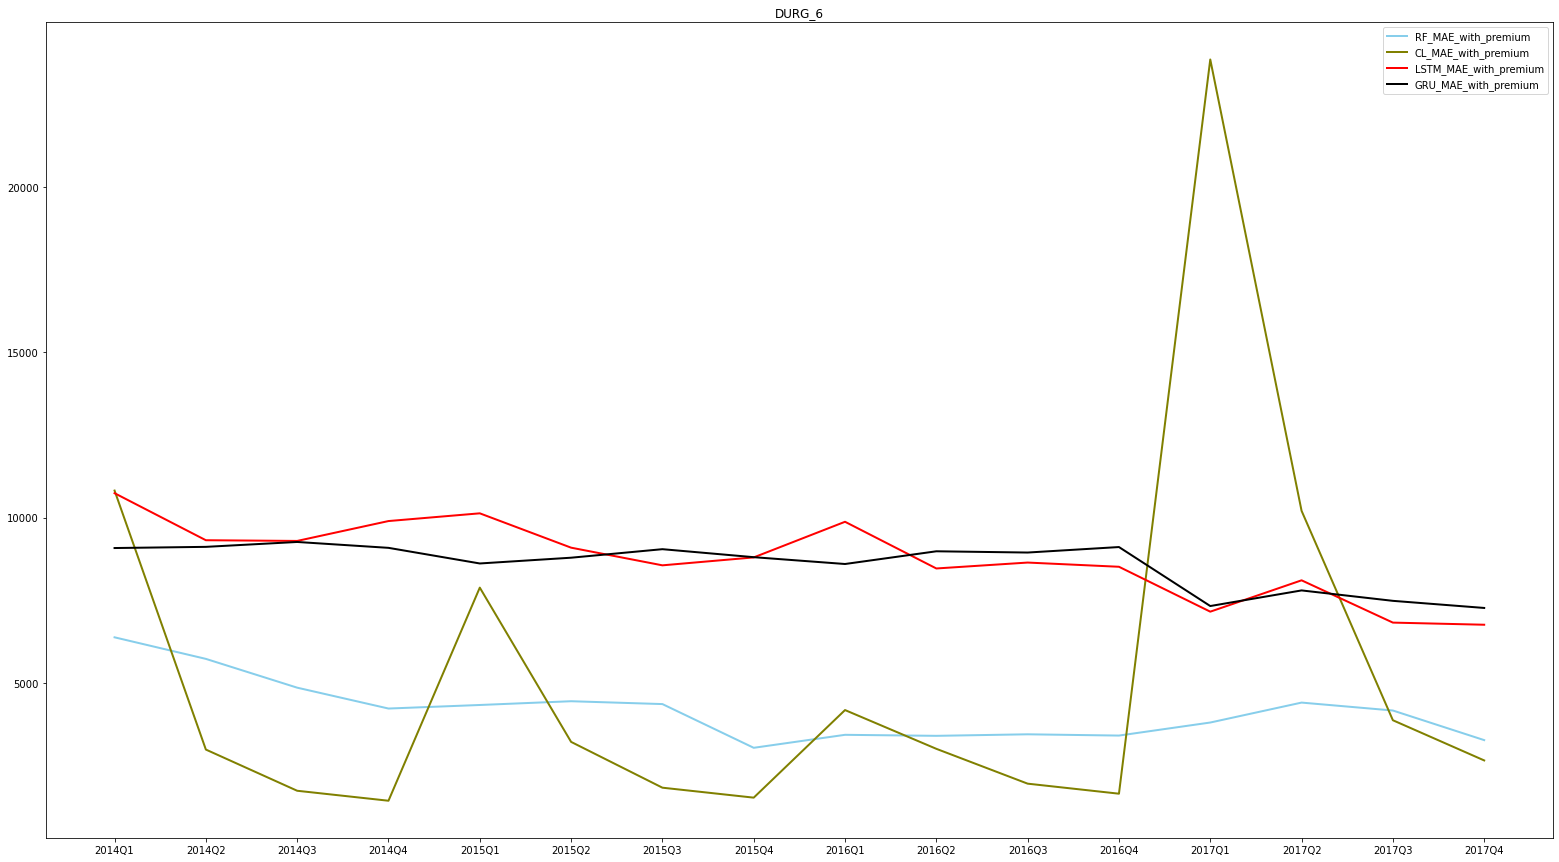

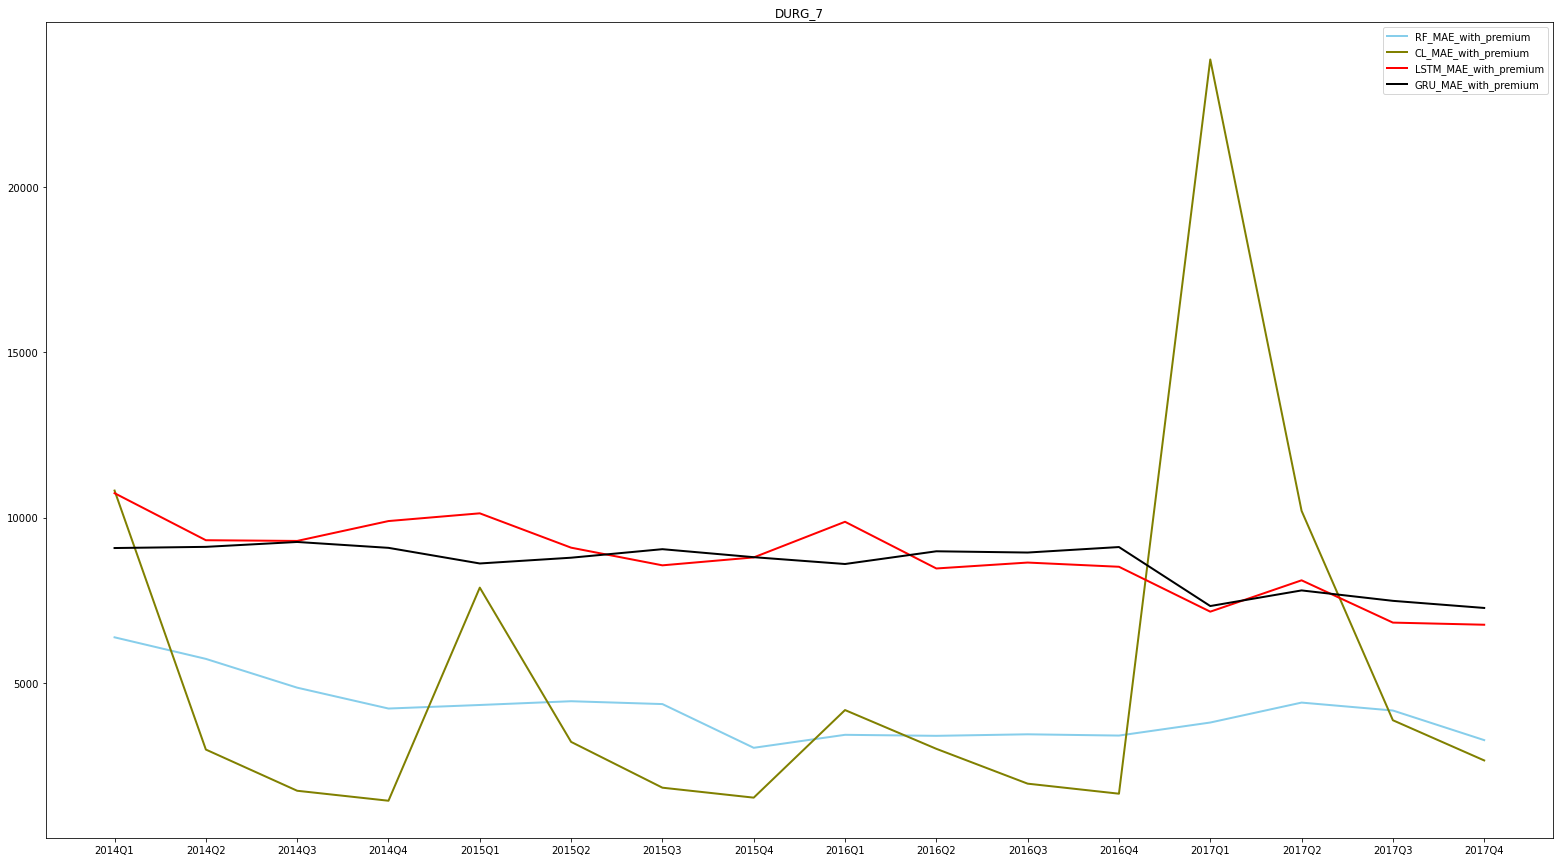

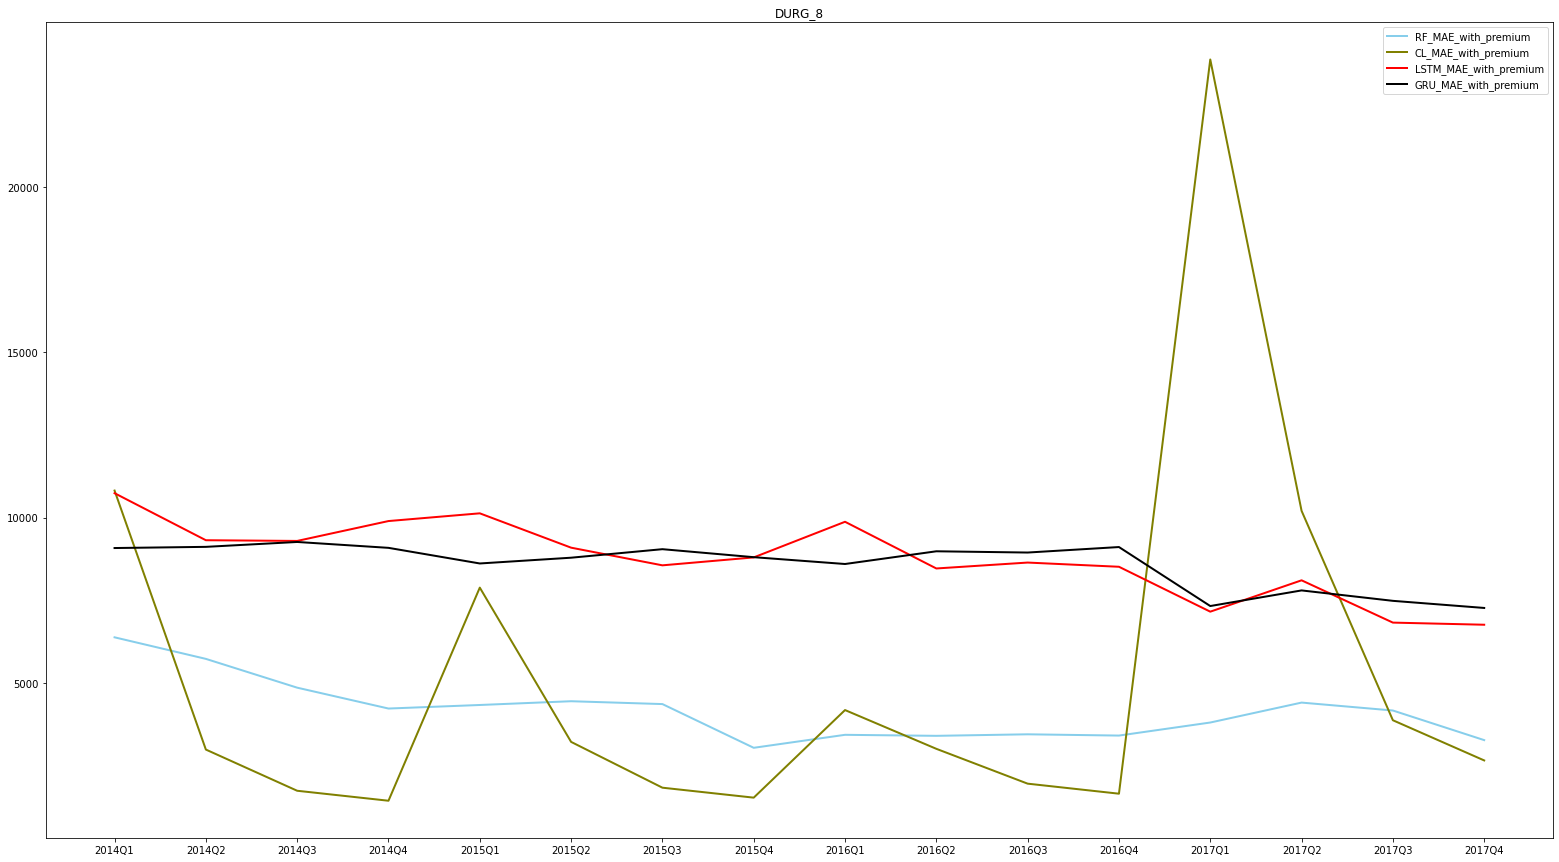

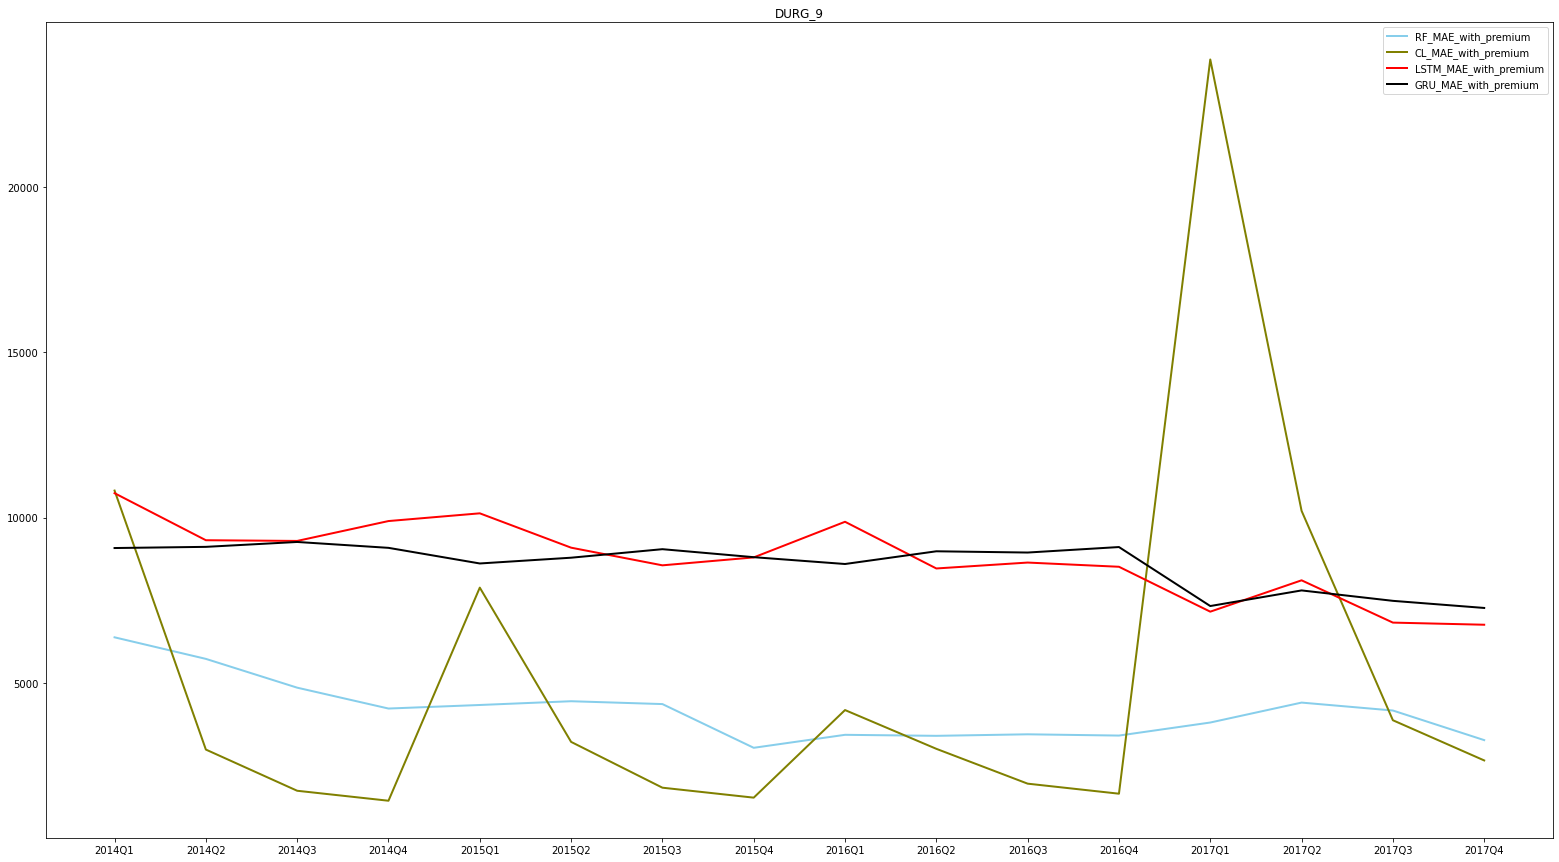

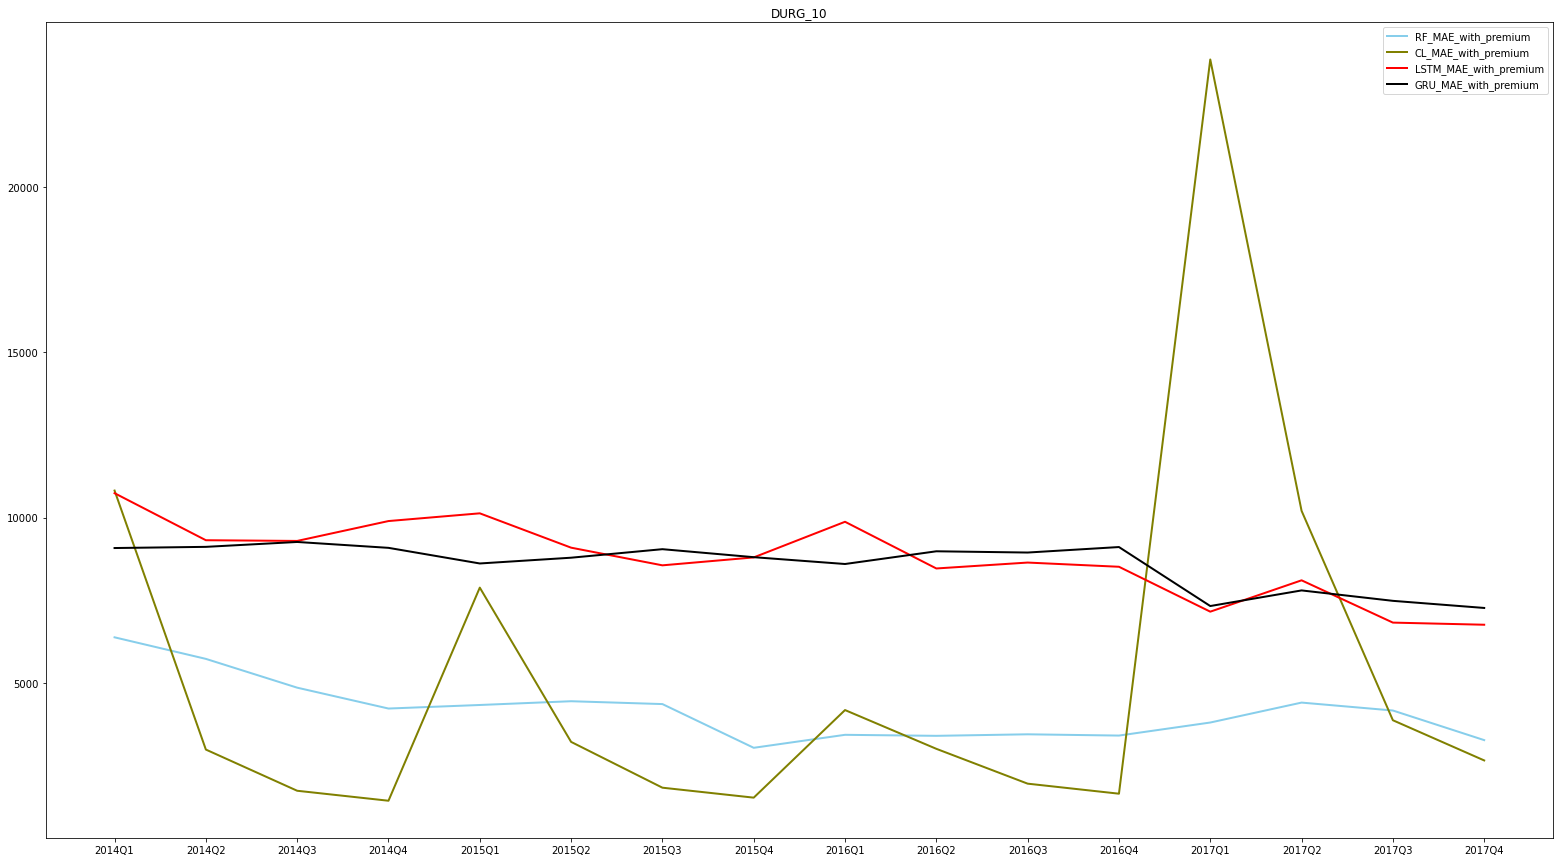

In [35]:
import matplotlib.pyplot as plt
for i in range(1,11):
    fig = plt.figure(figsize=(27,15))
    plt.plot( 'period', 'RF_MAE_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='skyblue', linewidth=2)
    plt.plot( 'period', 'CL_MAE_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='olive', linewidth=2)
    plt.plot( 'period', 'LSTM_MAE_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='red', linewidth=2)
    plt.plot( 'period', 'GRU_MAE_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='black', linewidth=2)
    plt.title("DURG_"+str(i))
    plt.legend()
    plt.show()

### Plots for different Durg number for after 8 periods data

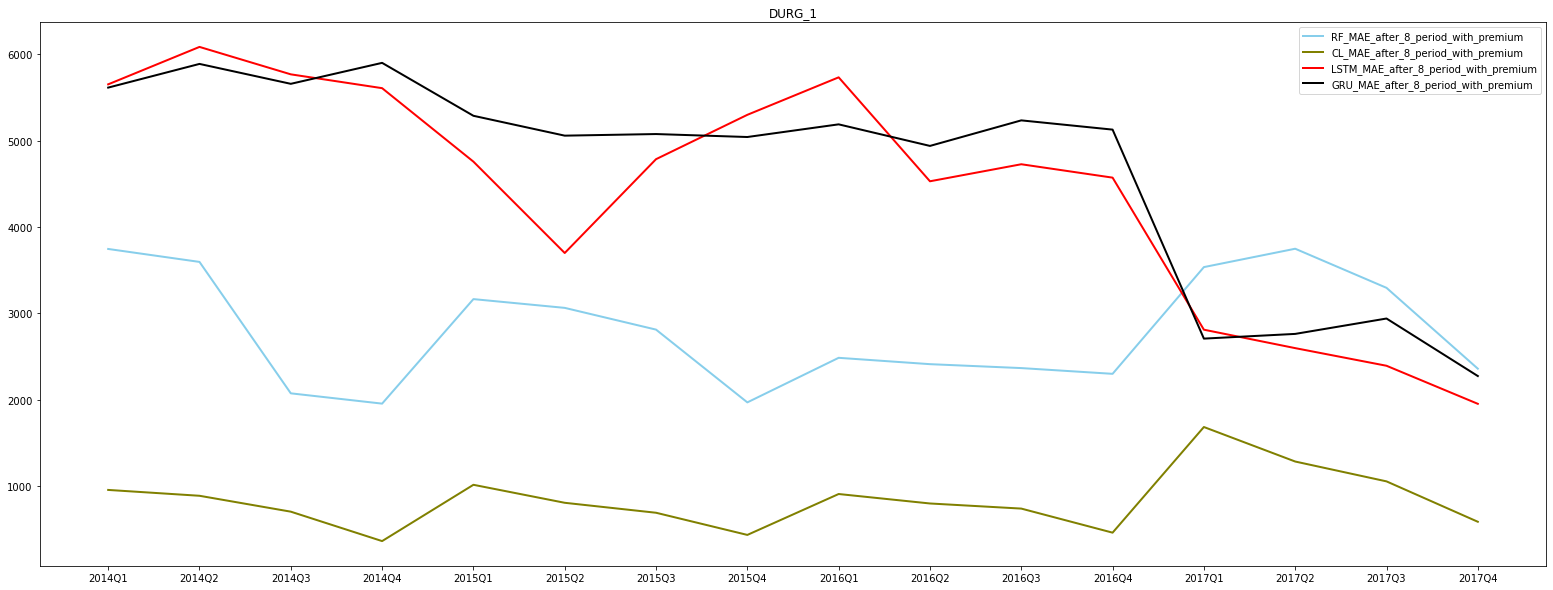

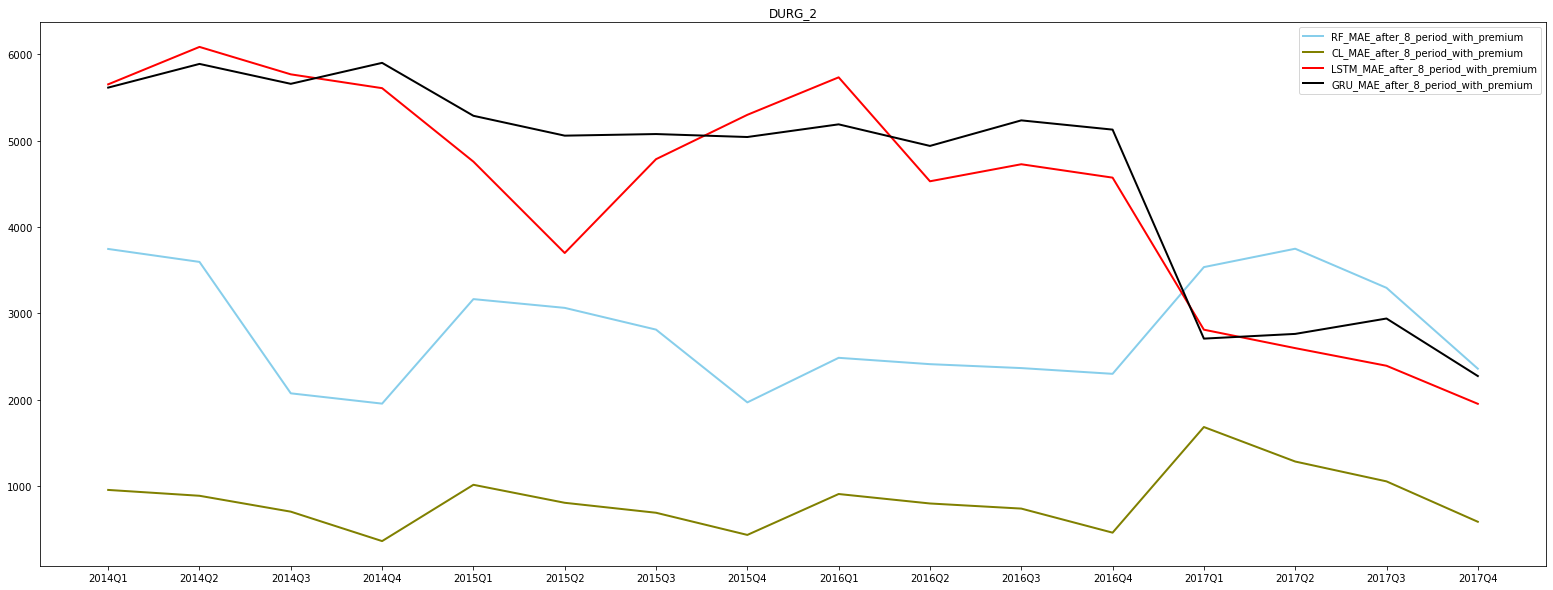

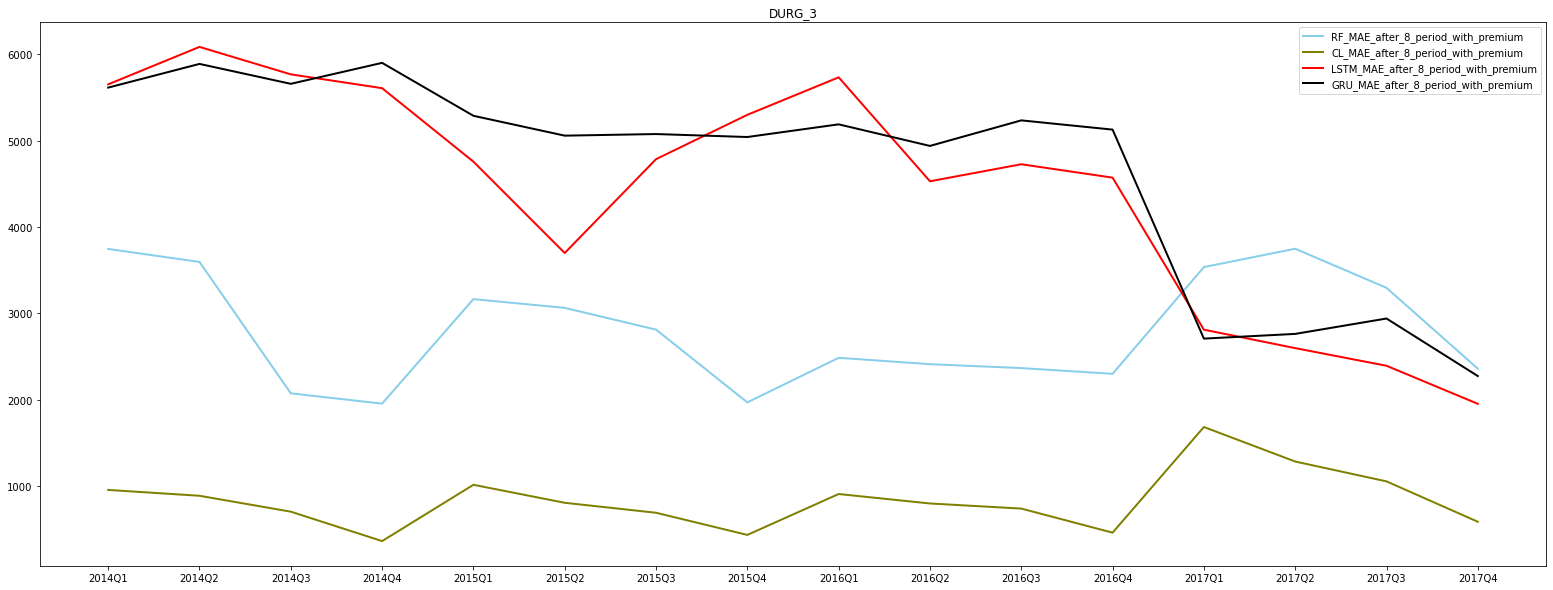

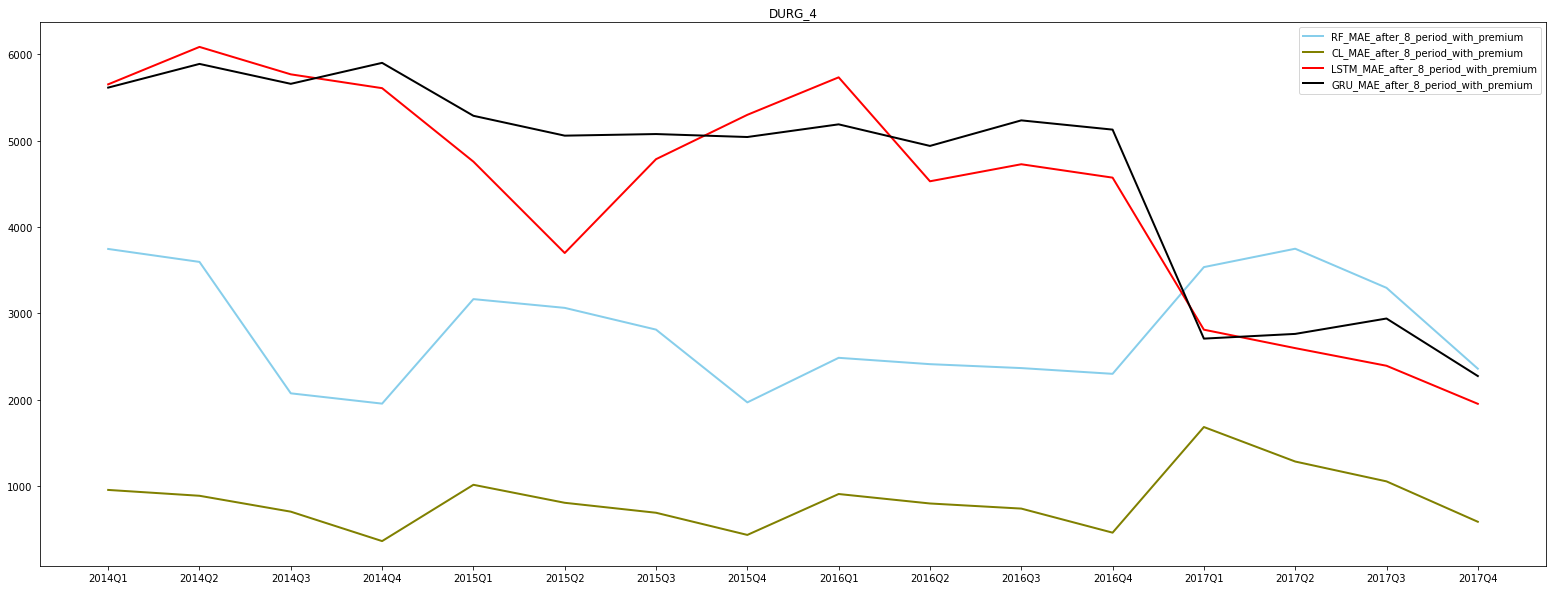

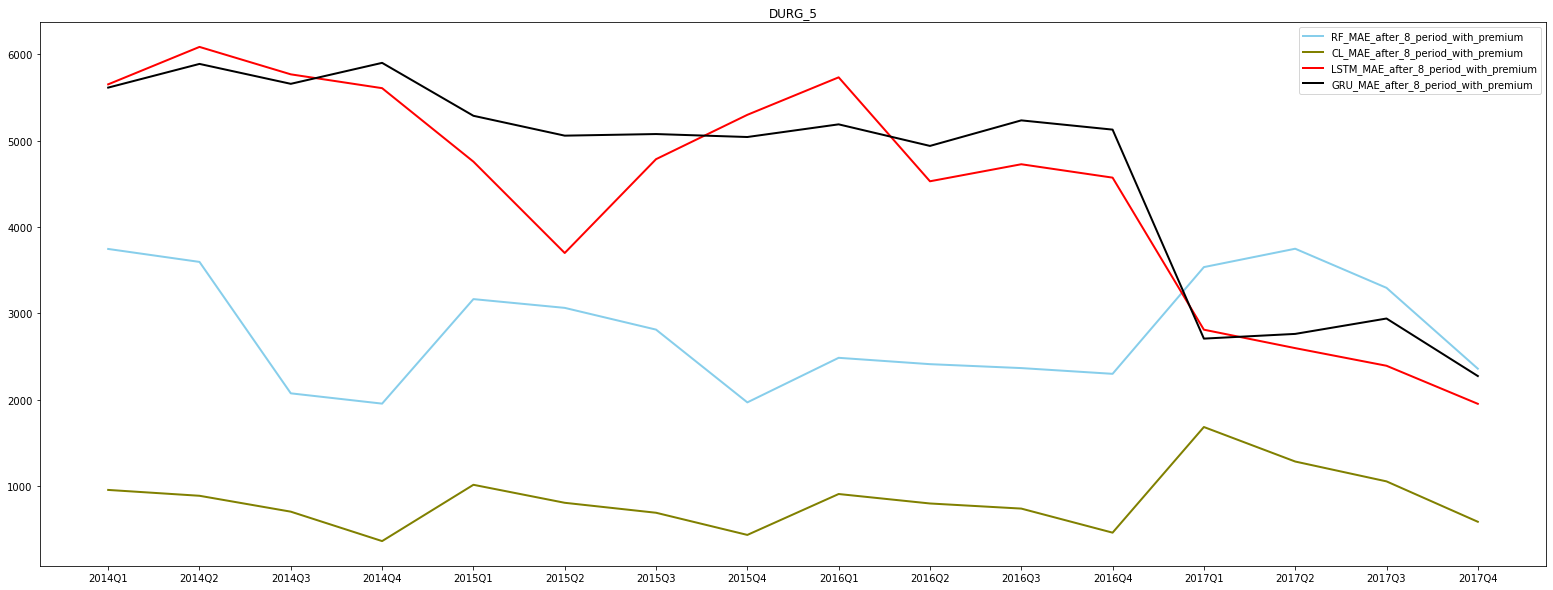

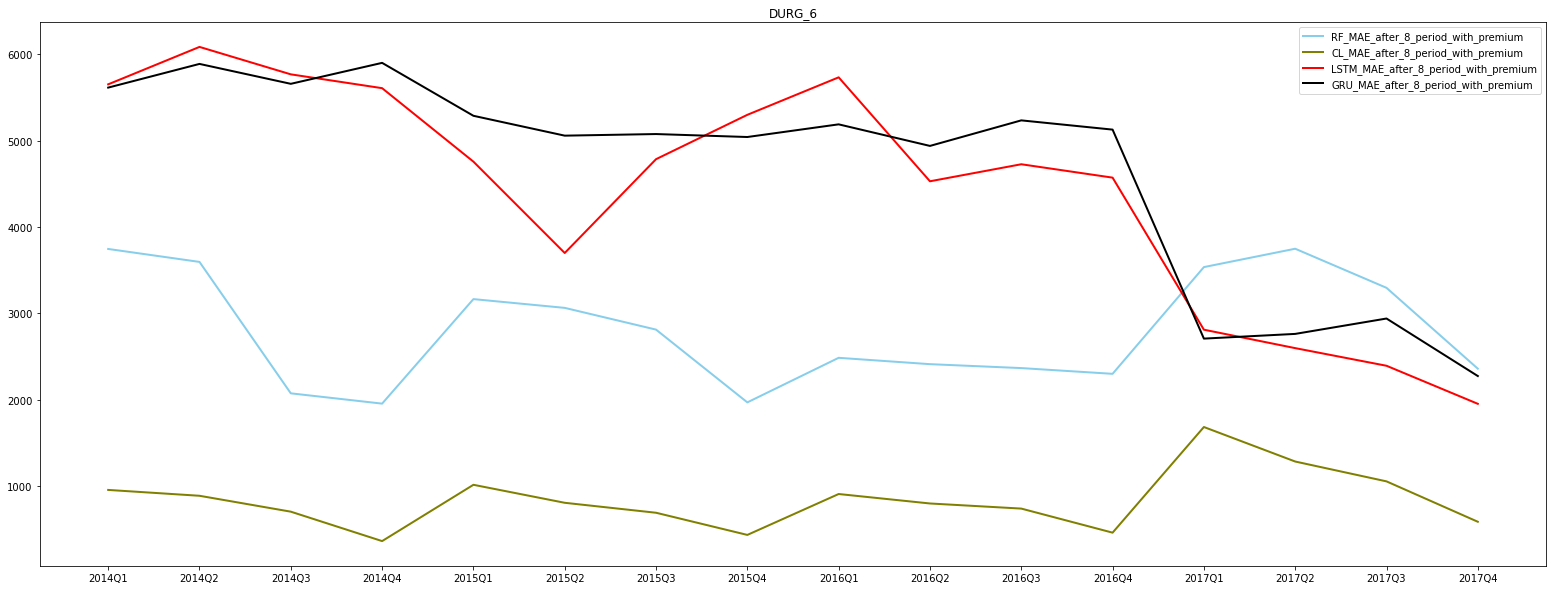

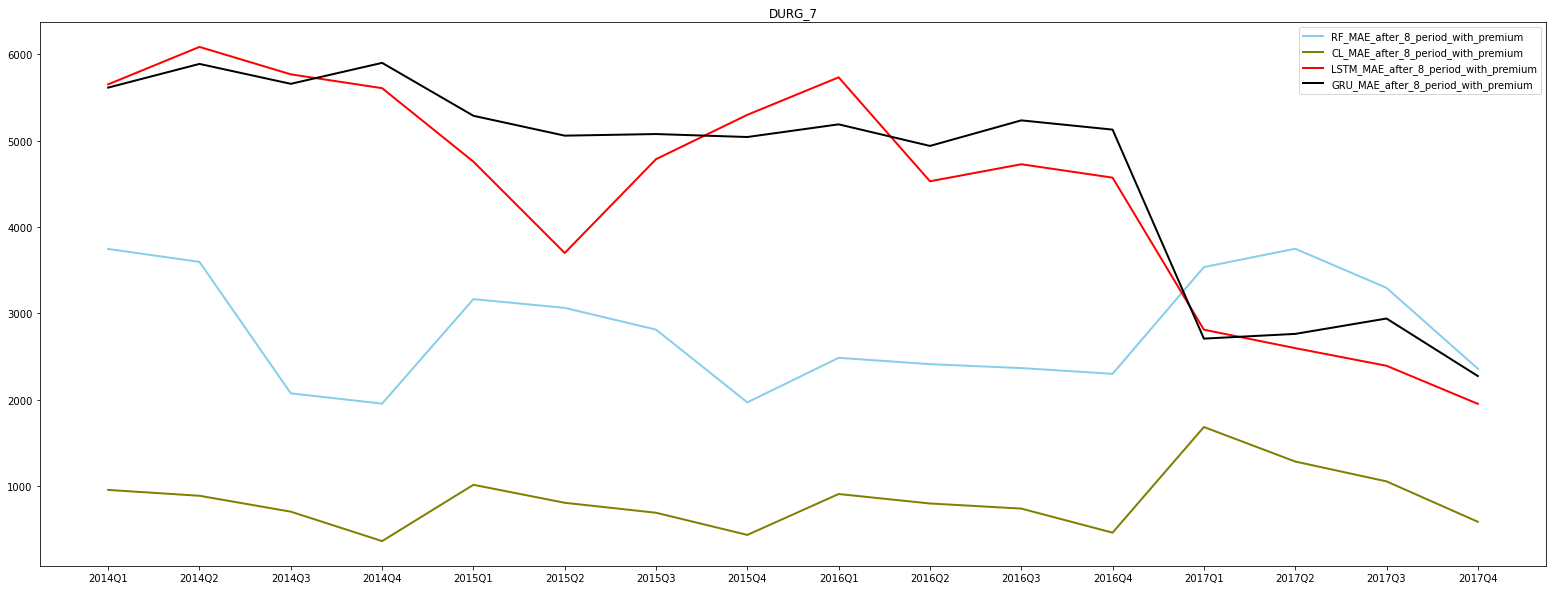

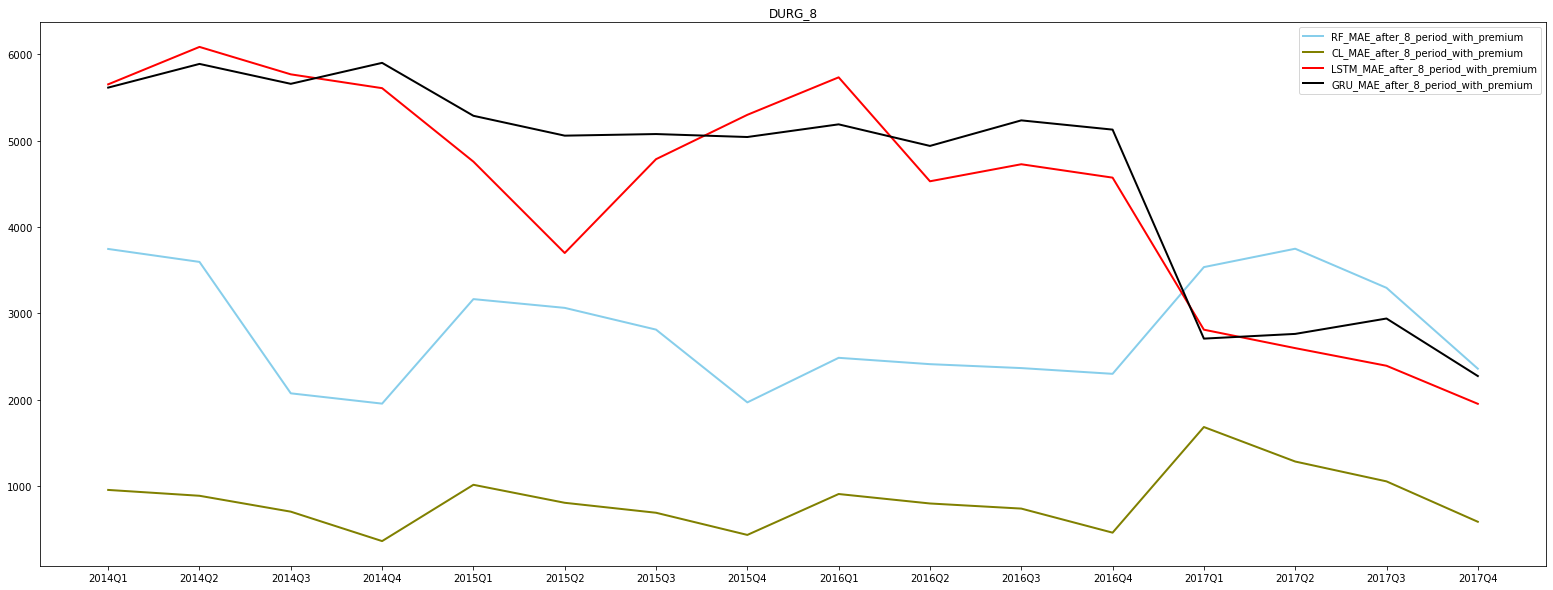

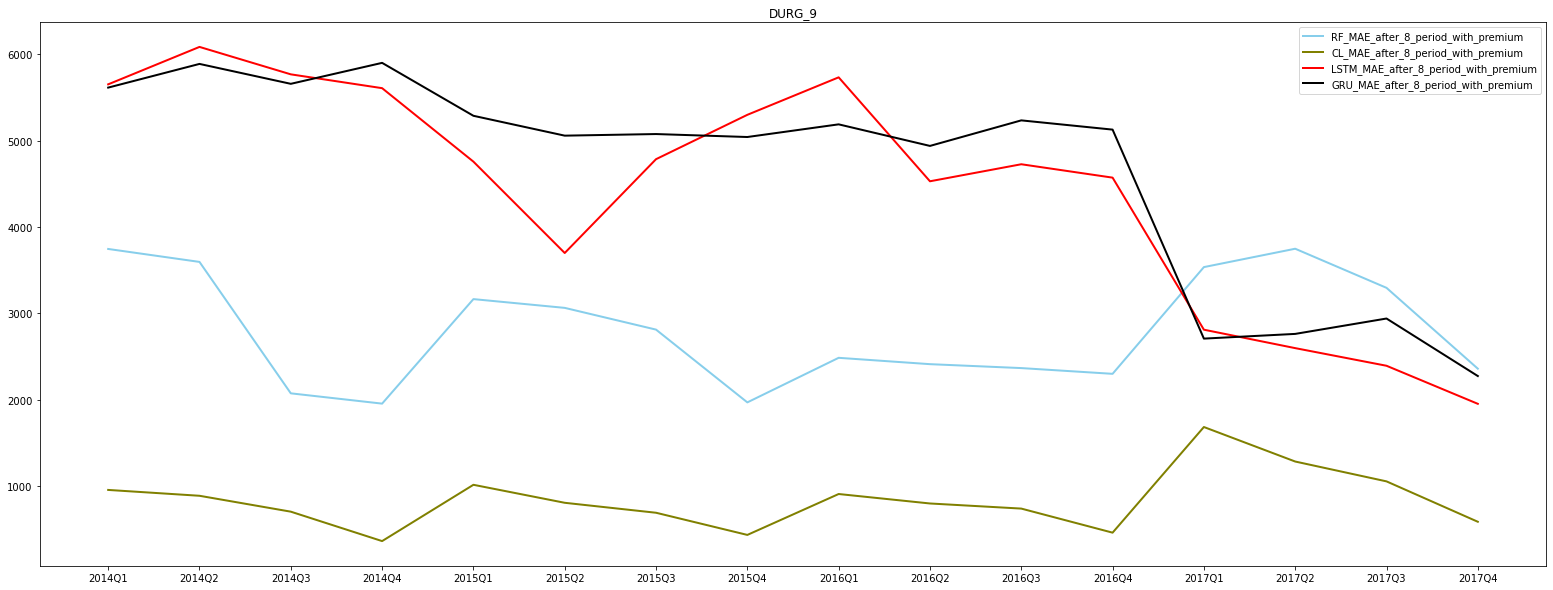

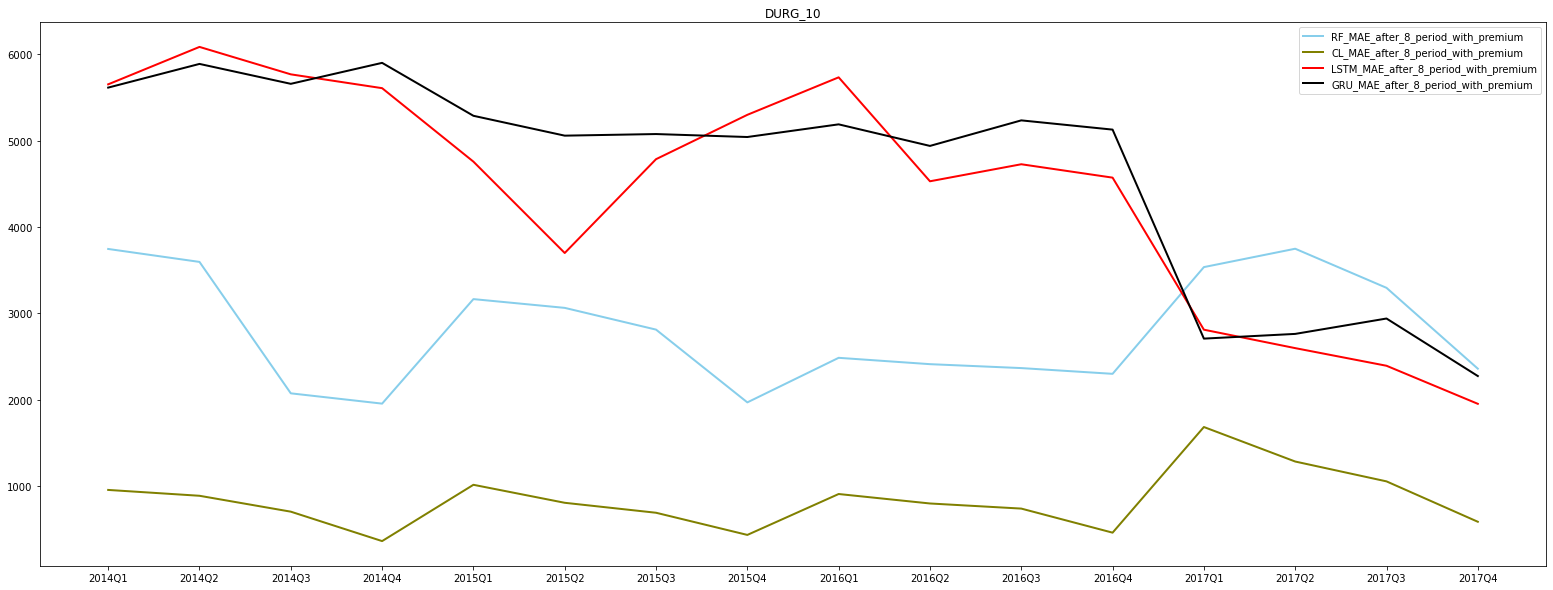

In [37]:
import matplotlib.pyplot as plt
for i in range(1,11):
    fig = plt.figure(figsize=(27,10))
    plt.plot( 'period', 'RF_MAE_after_8_period_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='skyblue', linewidth=2)
    plt.plot( 'period', 'CL_MAE_after_8_period_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='olive', linewidth=2)
    plt.plot( 'period', 'LSTM_MAE_after_8_period_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='red', linewidth=2)
    plt.plot( 'period', 'GRU_MAE_after_8_period_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='black', linewidth=2)
    plt.title("DURG_"+str(i))
    plt.legend()
    plt.show()

### Plot for all Durg numbers for full data

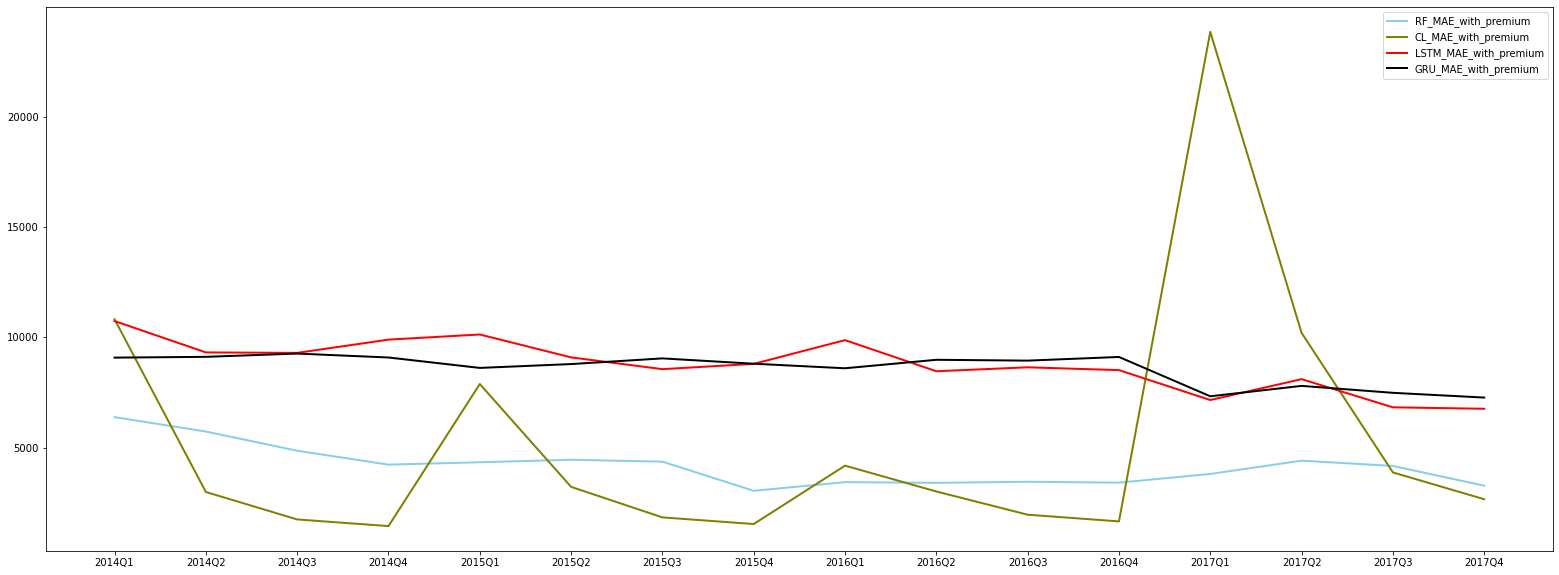

In [42]:
fig = plt.figure(figsize=(27,10))
plt.plot( 'period', 'RF_MAE_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='skyblue', linewidth=2)
plt.plot( 'period', 'CL_MAE_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='olive', linewidth=2)
plt.plot( 'period', 'LSTM_MAE_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='red', linewidth=2)
plt.plot( 'period', 'GRU_MAE_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='black', linewidth=2)
plt.legend()
plt.show()

### Plot for all Durg numbers for after 8 periods data

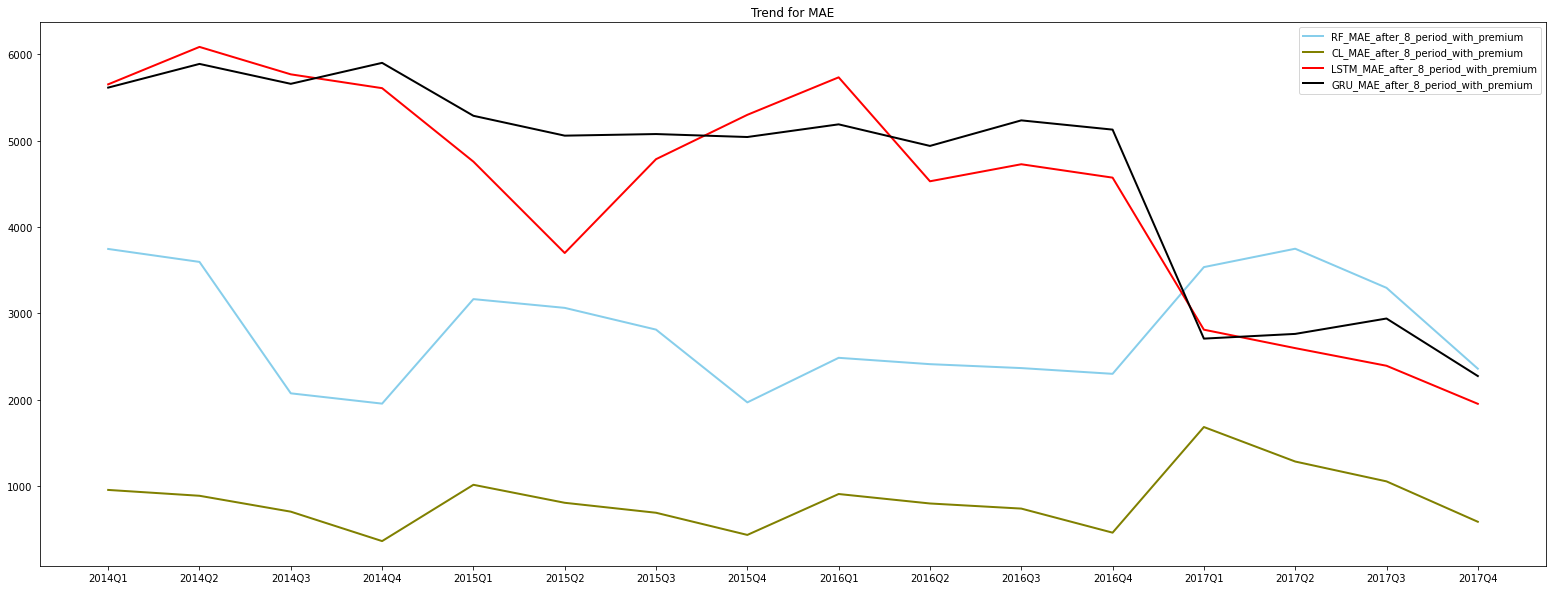

In [39]:
fig = plt.figure(figsize=(27,10))
plt.plot( 'period', 'RF_MAE_after_8_period_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='skyblue', linewidth=2)
plt.plot( 'period', 'CL_MAE_after_8_period_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='olive', linewidth=2)
plt.plot( 'period', 'LSTM_MAE_after_8_period_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='red', linewidth=2)
plt.plot( 'period', 'GRU_MAE_after_8_period_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='black', linewidth=2)
plt.title("Trend for MAE")
plt.legend()
plt.show()

# Comparing with premium and without premium

In [50]:
RF_without_premium = RF_CCY_1[RF_CCY_1["reporting_year"] >= 2014]
Average_RF_without_premium_MAE = RF_without_premium["RF_MAE"].mean()
Average_RF_without_premium_MAE_after_8_period = RF_without_premium["RF_MAE_after_8_period"].mean()
Average_LSTM_without_premium_MAE = RF_without_premium["LSTM_MAE"].mean()
Average_LSTM_without_premium_MAE_after_8_period = RF_without_premium["LSTM_MAE_after_8periods"].mean()
Average_GRU_without_premium_MAE = RF_without_premium["GRU_MAE"].mean()
Average_GRU_without_premium_MAE_after_8_period = RF_without_premium["GRU_MAE_after_8periods"].mean()
print("Average MAE for RF without premium: {} ".format(Average_RF_without_premium_MAE))
print("Average MAE for RF with premium: {} ".format(Average_RF_CCY_1_MAE_with_premium))
print("Average MAE for RF after 8 period without premium: {} ".format(Average_RF_without_premium_MAE_after_8_period))
print("Average MAE for RF after 8 period with premium: {} ".format(Average_RF_CCY_1_MAE_after_8_period_with_premium))
print("Average MAE for LSTM without premium: {} ".format(Average_LSTM_without_premium_MAE))
print("Average MAE for LSTM with premium: {} ".format(Average_LSTM_CCY_1_MAE_with_premium))
print("Average MAE for LSTM after 8 periods without premium: {} ".format(Average_LSTM_without_premium_MAE_after_8_period))
print("Average MAE for LSTM after 8 periods with premium: {} ".format(Average_LSTM_CCY_1_MAE_after_8_period_with_premium))
print("Average MAE for GRU without premium: {} ".format(Average_GRU_without_premium_MAE))
print("Average MAE for GRU with premium: {} ".format(Average_GRU_CCY_1_MAE_with_premium))
print("Average MAE for GRU after 8 periods without premium: {} ".format(Average_GRU_without_premium_MAE_after_8_period))
print("Average MAE for GRU after 8 periods with premium: {} ".format(Average_GRU_CCY_1_MAE_after_8_period_with_premium))

Average MAE for RF without premium: 4260.145424261984 
Average MAE for RF with premium: 4169.26951105417 
Average MAE for RF after 8 period without premium: 3159.5848719368587 
Average MAE for RF after 8 period with premium: 2803.460042697263 
Average MAE for LSTM without premium: 5652.820079792077 
Average MAE for LSTM with premium: 8759.427167255024 
Average MAE for LSTM after 8 periods without premium: 4341.808694377981 
Average MAE for LSTM after 8 periods with premium: 4435.06246669922 
Average MAE for GRU without premium: 5591.390547898251 
Average MAE for GRU with premium: 8581.157653167349 
Average MAE for GRU after 8 periods without premium: 4541.27686835328 
Average MAE for GRU after 8 periods with premium: 4668.463036173084 


In [54]:
print("Average MAE for RF without premium: {} ".format(Average_RF_without_premium_MAE))
print("Average MAE for RF with premium: {} ".format(Average_RF_CCY_1_MAE_with_premium))
print("Average MAE for LSTM without premium: {} ".format(Average_LSTM_without_premium_MAE))
print("Average MAE for LSTM with premium: {} ".format(Average_LSTM_CCY_1_MAE_with_premium))
print("Average MAE for GRU without premium: {} ".format(Average_GRU_without_premium_MAE))
print("Average MAE for GRU with premium: {} ".format(Average_GRU_CCY_1_MAE_with_premium))

Average MAE for RF without premium: 4260.145424261984 
Average MAE for RF with premium: 4169.26951105417 
Average MAE for LSTM without premium: 5652.820079792077 
Average MAE for LSTM with premium: 8759.427167255024 
Average MAE for GRU without premium: 5591.390547898251 
Average MAE for GRU with premium: 8581.157653167349 


### Plot for all Durg numbers for full data

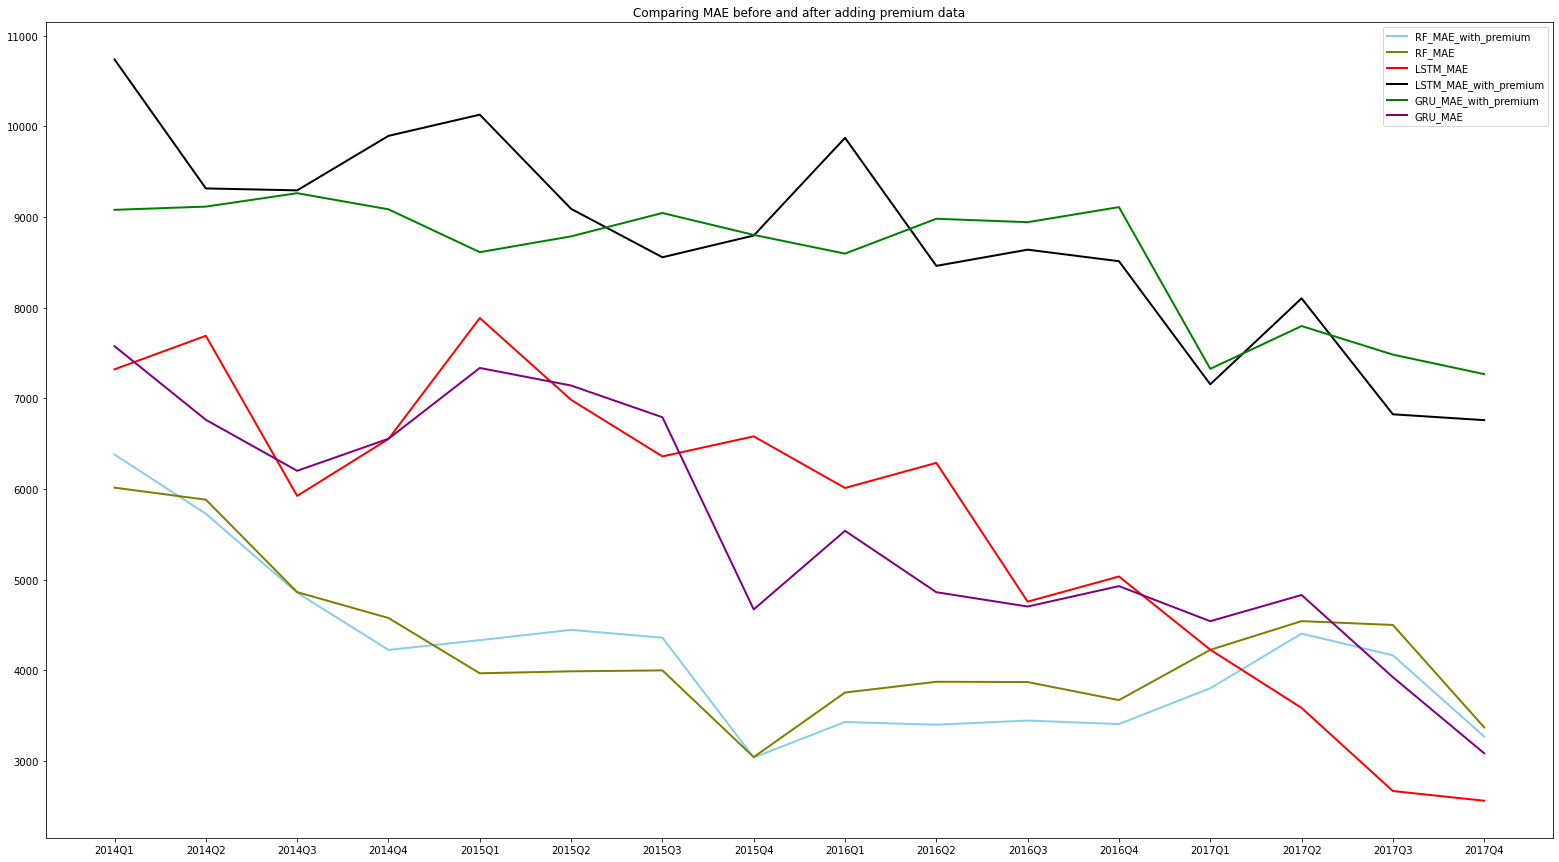

In [43]:
fig = plt.figure(figsize=(27,15))
plt.plot( 'period', 'RF_MAE_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='skyblue', linewidth=2)
plt.plot( 'period', 'RF_MAE', data=RF_CCY_1[RF_CCY_1["reporting_year"] >= 2014].groupby("period").mean().reset_index(), marker='', color='olive', linewidth=2)
plt.plot( 'period', 'LSTM_MAE', data=RF_CCY_1[RF_CCY_1["reporting_year"] >= 2014].groupby("period").mean().reset_index(), marker='', color='red', linewidth=2)
plt.plot( 'period', 'LSTM_MAE_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='black', linewidth=2)
plt.plot( 'period', 'GRU_MAE_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='green', linewidth=2)
plt.plot( 'period', 'GRU_MAE', data=RF_CCY_1[RF_CCY_1["reporting_year"] >= 2014].groupby("period").mean().reset_index(), marker='', color='purple', linewidth=2)
plt.title("Comparing MAE before and after adding premium data")
plt.legend()
plt.show()

### Plot for all Durg numbers for after 8 periods data

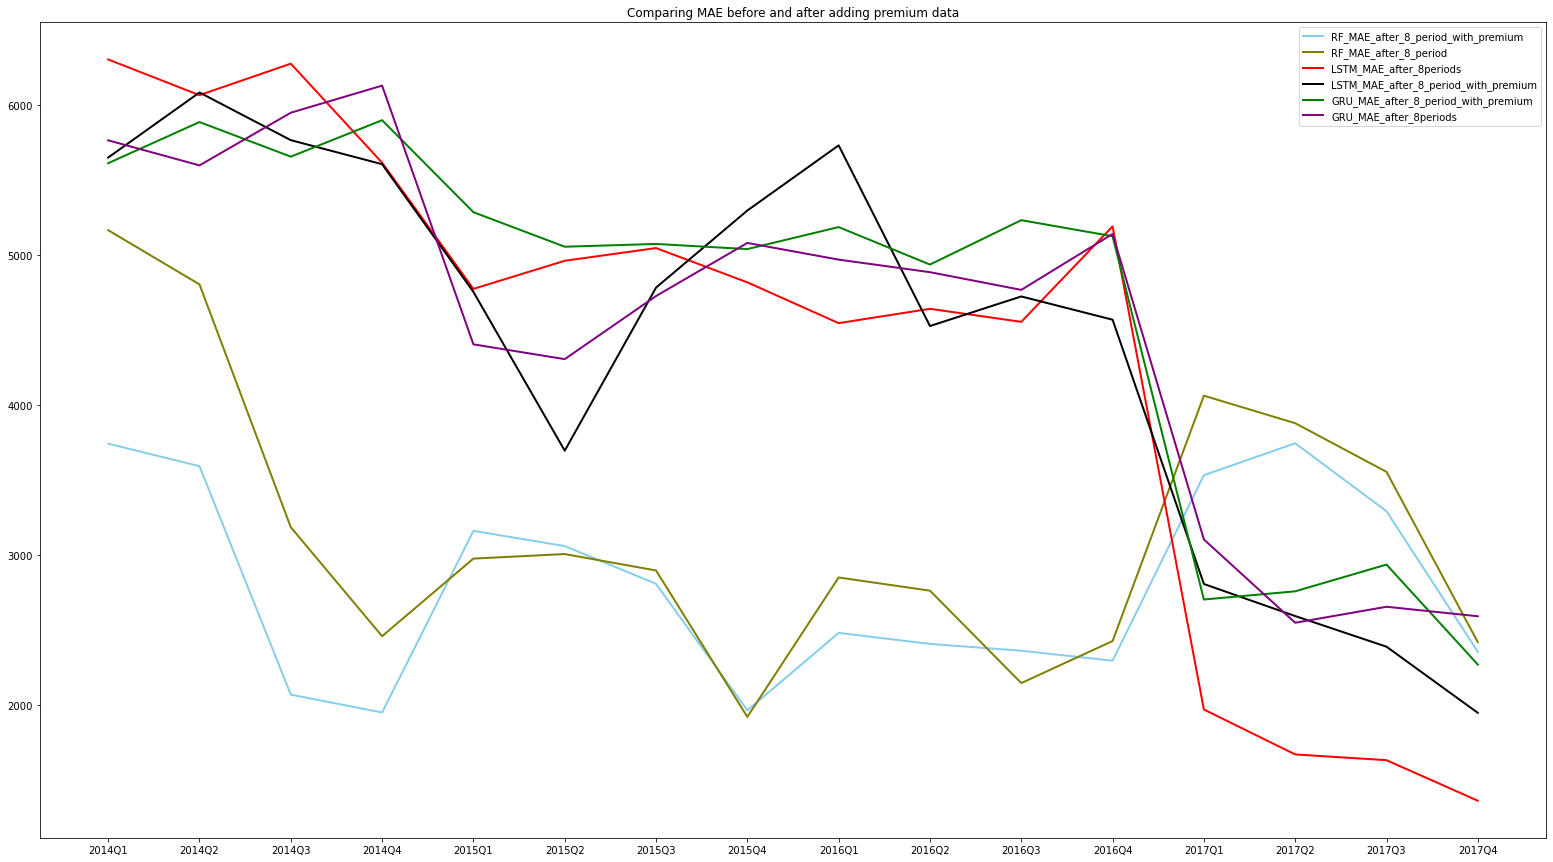

In [53]:
fig = plt.figure(figsize=(27,15))
plt.plot( 'period', 'RF_MAE_after_8_period_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='skyblue', linewidth=2)
plt.plot( 'period', 'RF_MAE_after_8_period', data=RF_CCY_1[RF_CCY_1["reporting_year"] >= 2014].groupby("period").mean().reset_index(), marker='', color='olive', linewidth=2)
plt.plot( 'period', 'LSTM_MAE_after_8periods', data=RF_CCY_1[RF_CCY_1["reporting_year"] >= 2014].groupby("period").mean().reset_index(), marker='', color='red', linewidth=2)
plt.plot( 'period', 'LSTM_MAE_after_8_period_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='black', linewidth=2)
plt.plot( 'period', 'GRU_MAE_after_8_period_with_premium', data=RF_CCY_1_with_premium.groupby("period").mean().reset_index(), marker='', color='green', linewidth=2)
plt.plot( 'period', 'GRU_MAE_after_8periods', data=RF_CCY_1[RF_CCY_1["reporting_year"] >= 2014].groupby("period").mean().reset_index(), marker='', color='purple', linewidth=2)
plt.title("Comparing MAE after 8 periods before and after adding premium data")
plt.legend()
plt.show()